<a href="https://colab.research.google.com/github/CarlosSotero/NFL_Stats_Players/blob/main/NFL_Moderna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bibliotecas nescessárias**

In [436]:
import kagglehub

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, PowerTransformer, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.base import clone
from yellowbrick.cluster import kelbow_visualizer, silhouette_visualizer

## **Download dos datasets**

In [437]:
# Download latest version
path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'nfl-stats-1999-2022' dataset.
Path to dataset files: /kaggle/input/nfl-stats-1999-2022


In [438]:
# Mostra os arquivos que vieram no caminho do kagglehub
print(os.listdir(path))


['yearly_player_stats_defense.csv', 'yearly_player_stats_offense.csv', 'yearly_team_stats_offense.csv', 'weekly_player_stats_offense.csv', 'yearly_team_stats_defense.csv', 'weekly_player_stats_defense.csv', 'weekly_team_stats_defense.csv', 'weekly_team_stats_offense.csv']


In [439]:
# Carregar os datasets anuais por jogador (ofensivo e defensivo)
offense_path = path + "/yearly_player_stats_offense.csv"
defense_path = path + "/yearly_player_stats_defense.csv"
df_offense = pd.read_csv(offense_path)
df_defense = pd.read_csv(defense_path)

# Colunas do df de ataque selecionadas
offense_cols = [
    'player_id', 'player_name', 'position', 'team', 'season', 'age', 'games_played_season',
    'height', 'weight', 'college', 'draft_year', 'draft_round', 'draft_pick', 'years_exp',
    'pass_attempts', 'complete_pass', 'passing_yards', 'pass_touchdown', 'interception',
    'passer_rating', 'comp_pct', 'ypa',
    'rush_attempts', 'rushing_yards', 'rush_touchdown', 'fumble', 'fumble_lost', 'ypc',
    'targets', 'receptions', 'receiving_yards', 'receiving_touchdown', 'yards_after_catch', 'yptarget', 'ypr',
    'total_yards', 'total_tds', 'fantasy_points_ppr', 'fantasy_points_standard',
    'season_ypg', 'season_yptouch', 'season_average_ppr_ppg', 'offense_snaps', 'offense_pct'
]

# DF de Ataque com as colunas selecionadas
df_offense_reduzido = df_offense[offense_cols]
print("Shape do DF Ofensivo reduzido:", df_offense_reduzido.shape)


# Colunas do df de defesa selecionadas
defense_cols = [
    'player_id', 'player_name', 'position', 'team', 'season', 'age', 'games_played_season',
    'height', 'weight', 'college', 'draft_year', 'draft_round', 'draft_pick', 'seasons_played',
    'solo_tackle', 'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit',
    'interception', 'fumble_forced', 'safety', 'def_touchdown',
    'defense_snaps', 'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard'
]

# DF de Defesa com as colunas selecionadas
df_defense_reduzido = df_defense[defense_cols]
print("Shape do DF Defensivo reduzido:", df_defense_reduzido.shape)


Shape do DF Ofensivo reduzido: (7133, 44)
Shape do DF Defensivo reduzido: (16148, 27)


##**LImpeza dos Dados**

In [440]:
print("🟦 OFENSIVO -----------------------")
print(df_offense_reduzido.info())
print("\n")
print("🟥 DEFENSIVO ----------------------")
print(df_defense_reduzido.info())

🟦 OFENSIVO -----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133 entries, 0 to 7132
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_id                7133 non-null   object 
 1   player_name              7133 non-null   object 
 2   position                 7133 non-null   object 
 3   team                     7133 non-null   object 
 4   season                   7133 non-null   int64  
 5   age                      7133 non-null   float64
 6   games_played_season      7133 non-null   int64  
 7   height                   7133 non-null   float64
 8   weight                   7133 non-null   float64
 9   college                  7133 non-null   object 
 10  draft_year               7133 non-null   float64
 11  draft_round              6043 non-null   float64
 12  draft_pick               6043 non-null   float64
 13  years_exp                7115 non-null   fl

### **Ataque**

In [441]:
# Criando uma cópia do DF de ataque
df_ataque_limpo = df_offense_reduzido.copy()

# Loop para preencher os valores ausentes
for col in df_ataque_limpo.columns:
  if df_ataque_limpo[col].dtype == 'object':
    df_ataque_limpo[col].fillna('Desconhecido', inplace=True)
  else:
    df_ataque_limpo[col].fillna(0, inplace=True)

# Substituindo o 0 por 'Desconhecido' na coluna 'college'
if 'college' in df_ataque_limpo.columns:
  df_ataque_limpo['college'] = df_ataque_limpo['college'].replace(['0', 0], 'Desconhecido')


# Alterando o tipo das colunas de float para int
for col in ['draft_year', 'draft_round', 'draft_pick', 'years_exp', 'age']:
  if col in df_ataque_limpo.columns:
    df_ataque_limpo[col] = df_ataque_limpo[col].astype(int, errors='ignore')

print("Ataque limpo:", df_ataque_limpo.shape)
print("Nulos restantes:", df_ataque_limpo.isnull().sum().sum())

Ataque limpo: (7133, 44)
Nulos restantes: 0


/tmp/ipython-input-207400779.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ataque_limpo[col].fillna('Desconhecido', inplace=True)
/tmp/ipython-input-207400779.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [442]:
print('Amostra de 10 jogadores aleatórios do ataque:')
df_ataque_limpo.sample(10)

Amostra de 10 jogadores aleatórios do ataque:


player_id      player_name position team  season  age  \
2018  00-0030506     Travis Kelce       TE   KC    2016   26   
2026  00-0030524     Landry Jones       QB  PIT    2016   27   
5245  00-0036429  Charlie Woerner       TE   SF    2021   23   
5135  00-0035603  Kendall Blanton       TE   LA    2021   25   
5141  00-0035632     Amani Hooker       FS  TEN    2021   23   
5946  00-0038120      Breece Hall       RB  NYJ    2022   21   
3149  00-0032562        Cole Wick       TE   SF    2018   24   
3787  00-0033733        Greg Ward       WR  PHI    2019   24   
1113  00-0029263   Russell Wilson       QB  SEA    2014   25   
6635  00-0033110     Tyler Higbee       TE   LA    2024   31   

      games_played_season  height  weight           college  ...    ypr  \
2018                    1    77.0   250.0        Cincinnati  ...  15.40   
2026                    7    76.0   225.0          Oklahoma  ...   0.00   
5245                    1    77.0   250.0           Georgia  ...   0.00   
5135                    2    78.0   262.0          Missouri  ...  10.71   
5141                    1    71.0   210.0              Iowa  ...   6.00   
5946                    7    71.0   217.0        Iowa State  ...  11.47   
3149                    1    78.0   257.0    Incarnate Word  ...   0.00   
3787                    4    71.0   186.0           Houston  ...   9.95   
1113                    3    71.0   206.0         Wisconsin  ...   0.00   
6635                    2    78.0   255.0  Western Kentucky  ...   7.86   

      total_yards  total_tds  fantasy_points_ppr  fantasy_points_standard  \
2018         77.0        0.0               12.70                     7.70   
2026        554.0        4.0               41.92                    41.92   
5245          0.0        0.0                0.00                     0.00   
5135         75.0        2.0               20.50                    13.50   
5141          6.0        0.0                1.60                     0.60   
5946        681.0        6.0              112.10                    93.10   
3149          0.0        0.0                0.00                     0.00   
3787        214.0        2.0               48.40                    27.40   
1113        810.0        7.0               69.56                    69.56   
6635         55.0        2.0               18.50                    11.50   

      season_ypg  season_yptouch  season_average_ppr_ppg  offense_snaps  \
2018       77.00           15.40                   12.70           58.0   
2026       11.31            6.15                    5.99          160.0   
5245        0.00            0.00                    0.00           21.0   
5135       18.75           10.71                   10.25           69.0   
5141        6.00            6.00                    1.60            0.0   
5946       13.90            6.88                   16.01          233.0   
3149        0.00            0.00                    0.00            4.0   
3787       13.38            9.73                   12.10          241.0   
1113       90.00            9.64                   23.19          176.0   
6635       13.75            7.86                    9.25           44.0   

      offense_pct  
2018     0.983051  
2026     0.333333  
5245     0.388889  
5135     0.460000  
5141     0.000000  
5946     0.489496  
3149     0.040000  
3787     0.772436  
1113     1.000000  
6635     0.357724  

[10 rows x 44 columns]

###**Defesa**

In [443]:
# Criando uma cópia do DF de ataque
df_defesa_limpo = df_defense_reduzido.copy()

# Remove linhas que estão sem o nome e a posição dos jogadores
df_defesa_limpo = df_defesa_limpo.dropna(subset=['player_name', 'position'])

# Loop para preencher os valores ausentes
for col in df_defesa_limpo.columns:
  if df_defesa_limpo[col].dtype == 'object':
    df_defesa_limpo[col].fillna('Desconhecido', inplace=True)
  else:
    df_defesa_limpo[col].fillna(0, inplace=True)

# Substituindo o 0 por 'Desconhecido' na coluna 'college'
if 'college' in df_defesa_limpo.columns:
  df_defesa_limpo['college'] = df_defesa_limpo['college'].replace(['0', 0], 'Desconhecido')

# Alterando o tipo das colunas de float para int
for col in ['draft_year', 'draft_round', 'draft_pick', 'age']:
    if col in df_defesa_limpo.columns:
        df_defesa_limpo[col] = df_defesa_limpo[col].astype(int, errors='ignore')

print("Defensivo limpo:", df_defesa_limpo.shape)
print("Nulos restantes:", df_defesa_limpo.isnull().sum().sum())

Defensivo limpo: (12332, 27)
Nulos restantes: 0


/tmp/ipython-input-2341386716.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_defesa_limpo[col].fillna('Desconhecido', inplace=True)
/tmp/ipython-input-2341386716.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [444]:
print('Amostra de 10 jogadores aleatórios da defesa:')
df_defesa_limpo.sample(10)

Amostra de 10 jogadores aleatórios da defesa:


player_id        player_name position team  season  age  \
15805  00-0038121     Alontae Taylor       CB   NO    2024   26   
11135  00-0029239     Brandon Bolden       RB   NE    2021   31   
9731   00-0035404      Porter Gustin       LB  CLE    2019   22   
1553   00-0025995        Jordan Senn      OLB  CAR    2013    0   
411    00-0025440        Eric Wright       CB   TB    2012    0   
95     00-0022034       Mario Haggan      MLB   LA    2012    0   
14839  00-0039002       Sydney Brown        S  PHI    2023   23   
4491   00-0030538  Johnathan Cyprien        S  JAX    2015   25   
14856  00-0039061    Desjuan Johnson       DT   LA    2023   24   
14288  00-0036166       Dane Jackson       CB  BUF    2023   27   

       games_played_season  height  weight                college  ...  sack  \
15805                 17.0    72.0   199.0              Tennessee  ...  18.0   
11135                  4.0    71.0   220.0            Mississippi  ...   0.0   
9731                   6.0    77.0   260.0    Southern California  ...   4.0   
1553                   1.0     0.0     0.0           Desconhecido  ...   0.0   
411                   10.0     0.0     0.0           Desconhecido  ...   0.0   
95                     5.0     0.0     0.0           Desconhecido  ...   3.0   
14839                  9.0    70.0   211.0               Illinois  ...   0.0   
4491                  14.0    71.0   211.0  Florida International  ...   0.0   
14856                  5.0    75.0   280.0                 Toledo  ...   7.0   
14288                 12.0    71.0   180.0             Pittsburgh  ...   0.0   

       qb_hit  interception  fumble_forced  safety  def_touchdown  \
15805    22.0           0.0              5     0.0            0.0   
11135     0.0           0.0              0     0.0            0.0   
9731      5.0           0.0              0     0.0            0.0   
1553      0.0           0.0              0     0.0            0.0   
411       1.0           2.0              1     0.0            2.0   
95        3.0           0.0              4     0.0            0.0   
14839     5.0           2.0              2     0.0            2.0   
4491      2.0           2.0              3     0.0            0.0   
14856     7.0           0.0              4     0.0            0.0   
14288     1.0           0.0              3     0.0            0.0   

       defense_snaps  defense_pct  fantasy_points_ppr  fantasy_points_standard  
15805         1076.0     0.913413                   0                        0  
11135            0.0     0.000000                   0                        0  
9731           225.0     0.569620                   0                        0  
1553             5.0     0.089286                   0                        0  
411            495.0     0.731167                   0                        0  
95               0.0     0.000000                   0                        0  
14839          291.0     0.486622                   0                        0  
4491          1014.0     0.999015                   0                        0  
14856           76.0     0.233129                   0                        0  
14288          567.0     0.762097                   0                        0  

[10 rows x 27 columns]

### **Análises dos dados**

In [445]:
# Verificando a quantidade por de valores unicos por temporada
print(df_ataque_limpo['season'].value_counts().sort_index())
print(df_defesa_limpo['season'].value_counts().sort_index())


season
2012    411
2013    421
2014    480
2015    455
2016    515
2017    545
2018    593
2019    618
2020    650
2021    638
2022    626
2023    604
2024    577
Name: count, dtype: int64
season
2012     865
2013     877
2014     912
2015     912
2016     925
2017     927
2018     942
2019     968
2020     995
2021    1050
2022     984
2023     983
2024     992
Name: count, dtype: int64


In [446]:
# Conferindo as posições do Ataque e Defesa
print('Posições ataque:', df_ataque_limpo['position'].unique())

print('Posições defesa:', df_defesa_limpo['position'].unique())

Posições ataque: ['QB' 'WR' 'TE' 'P' 'RB' 'FS' 'FB' 'CB' 'LS' 'ILB' 'DT' 'DE' 'NT' 'SS' 'K'
 'T' 'OLB' 'MLB']
Posições defesa: ['ILB' 'CB' 'FS' 'OLB' 'DE' 'MLB' 'NT' 'DT' 'SS' 'LB' 'S' 'WR' 'RB' 'TE'
 'DB' 'FB' 'T' 'C' 'G']


In [447]:
# Diagnóstico: quantos jogadores estão fora de posição
ataque_incorreto = df_ataque_limpo.query("offense_snaps == 0")
defesa_incorreta = df_defesa_limpo.query("defense_snaps == 0")

print("Jogadores de defesa no dataset de ataque:")
print(ataque_incorreto[['player_name', 'position', 'offense_snaps']])

print("\nJogadores de ataque no dataset de defesa:")
print(defesa_incorreta[['player_name', 'position', 'defense_snaps']])

# Verifique o tamanho
n_ataque = len(df_ataque_limpo)
n_defesa = len(df_defesa_limpo)
pct_ataque_incorreto = len(ataque_incorreto) / n_ataque * 100
pct_defesa_incorreta = len(defesa_incorreta) / n_defesa * 100

print(f"\n{pct_ataque_incorreto:.2f}% dos registros de ataque são jogadores de defesa.")
print(f"{pct_defesa_incorreta:.2f}% dos registros de defesa são jogadores de ataque.")


Jogadores de defesa no dataset de ataque:
               player_name position  offense_snaps
14           Shane Lechler        P            0.0
68         Dustin Colquitt        P            0.0
104               Sam Koch        P            0.0
105               Sam Koch        P            0.0
120            Eric Weddle       FS            0.0
...                    ...      ...            ...
6886         Divine Deablo      MLB            0.0
6963           Dane Belton       SS            0.0
6972  Carrington Valentine       CB            0.0
7103           Jaden Hicks       SS            0.0
7104       Kamren Kinchens       FS            0.0

[179 rows x 3 columns]

Jogadores de ataque no dataset de defesa:
                player_name position  defense_snaps
16             Takeo Spikes      ILB            0.0
38          Richard Seymour       DT            0.0
40             Andre Carter       DE            0.0
69           Quentin Jammer       CB            0.0
72           Quinti

In [448]:
# Contabilizando os jogadores de ataque que estão no df de defesa
defesa_incorreta['position'].value_counts()

position
WR     308
CB     234
DE     167
DT     142
LB     131
S      104
RB      94
TE      58
OLB     40
ILB     24
FS      23
MLB     21
SS      21
NT      11
T        7
FB       3
DB       2
G        2
C        1
Name: count, dtype: int64

In [449]:
# Eliminando os jogadores com 0 snaps dos dfs
df_ataque_limpo = df_ataque_limpo.query("offense_snaps > 0")
df_defesa_limpo = df_defesa_limpo.query("defense_snaps > 0")


###**Feature Engineering**

####**Ataque**

In [450]:
#  Total de Touchdowns
df_ataque_limpo['total_touchdown'] = df_ataque_limpo['pass_touchdown'] + df_ataque_limpo['rush_touchdown']


# Jardas por tentativa de passe (protege contra divisão por zero)
df_ataque_limpo['yards_per_pass_attempt'] = np.where(
    df_ataque_limpo['pass_attempts'] > 0,
    df_ataque_limpo['passing_yards'] / df_ataque_limpo['pass_attempts'],
    0
)

# Jardas por tentativa de corrida
df_ataque_limpo['yards_per_carry'] = np.where(
    df_ataque_limpo['rush_attempts'] > 0,
    df_ataque_limpo['rushing_yards'] / df_ataque_limpo['rush_attempts'],
    0
)

# Jardas por recepção
df_ataque_limpo['yards_per_reception'] = np.where(
    df_ataque_limpo['receptions'] > 0,
    df_ataque_limpo['receiving_yards'] / df_ataque_limpo['receptions'],
    0
)

# Taxa de recepção
df_ataque_limpo['catch_rate'] = np.where(
    df_ataque_limpo['targets'] > 0,
    df_ataque_limpo['receptions'] / df_ataque_limpo['targets'],
    0
)

# Total de "touches" (corridas + recepções)
df_ataque_limpo['touches'] = df_ataque_limpo['rush_attempts'] + df_ataque_limpo['receptions']

# Jardas por toque
df_ataque_limpo['yards_per_touch'] = np.where(
    df_ataque_limpo['touches'] > 0,
    df_ataque_limpo['total_yards'] / df_ataque_limpo['touches'],
    0
)


In [451]:
# 5 jogadores aleatorios de ataque
df_ataque_limpo.sample(5)

player_id        player_name position team  season  age  \
866   00-0023437       Ronnie Brown       RB  LAC    2014   32   
1267  00-0031237  Teddy Bridgewater       QB  MIN    2014   21   
1460  00-0027791       James Starks       RB   GB    2015   29   
6083  00-0033881        Evan Engram       TE  JAX    2023   28   
6308  00-0036550     Rashod Bateman       WR  BAL    2023   23   

      games_played_season  height  weight      college  ...  \
866                     8    72.0   223.0       Auburn  ...   
1267                   13    74.0   210.0   Louisville  ...   
1460                    1    74.0   218.0      Buffalo  ...   
6083                   17    75.0   240.0  Mississippi  ...   
6308                   15    73.0   193.0    Minnesota  ...   

      season_average_ppr_ppg  offense_snaps  offense_pct  total_touchdown  \
866                     1.96           82.0     0.212435              0.0   
1267                   16.13          794.0     0.968293             16.0   
1460                    6.70           39.0     0.527027              0.0   
6083                   13.08          917.0     0.786449              4.0   
6308                    4.70          584.0     0.578218              1.0   

      yards_per_pass_attempt  yards_per_carry  yards_per_reception  \
866                 0.000000         4.214286             9.750000   
1267                7.484615         4.446809             0.000000   
1460                0.000000         3.285714             1.000000   
6083                0.000000         0.000000             8.447368   
6308                0.000000        18.000000            11.468750   

      catch_rate  touches  yards_per_touch  
866     0.571429     18.0         5.444444  
1267    0.000000     47.0        66.553191  
1460    1.000000     11.0         2.454545  
6083    0.814286    114.0         8.447368  
6308    0.603774     33.0        11.666667  

[5 rows x 51 columns]

###**Defesa**

In [452]:
# Colunas no df de defesa
df_defesa_limpo.columns

Index(['player_id', 'player_name', 'position', 'team', 'season', 'age',
       'games_played_season', 'height', 'weight', 'college', 'draft_year',
       'draft_round', 'draft_pick', 'seasons_played', 'solo_tackle',
       'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit', 'interception',
       'fumble_forced', 'safety', 'def_touchdown', 'defense_snaps',
       'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard'],
      dtype='object')

In [453]:
# Tackle totais
df_defesa_limpo['tackles_total'] = df_defesa_limpo['solo_tackle'] + df_defesa_limpo['assist_tackle']

# Taxa de sacks por snap
df_defesa_limpo['sack_rate'] = df_defesa_limpo['sack'] / df_defesa_limpo['defense_snaps']

# Tackles por jogo
df_defesa_limpo['tackles_per_game'] = df_defesa_limpo['tackles_total'] / df_defesa_limpo['games_played_season']

# Jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
df_defesa_limpo['impact_plays'] = (
    df_defesa_limpo['sack'] +
    df_defesa_limpo['interception'] +
    df_defesa_limpo['fumble_forced'] +
    df_defesa_limpo['safety'] +
    df_defesa_limpo['def_touchdown']
)


In [454]:
# 5 jogadores aleatorios de defesa
df_defesa_limpo.sample(5)

player_id       player_name position team  season  age  \
6491   00-0029799   Lerentee McCray       DE  JAX    2017   27   
12350  00-0036935     Kelvin Joseph       CB  DAL    2021   21   
14546  00-0037130  Reed Blankenship        S  PHI    2023   24   
5610   00-0031084      Eric Pinkins       LB  NYG    2016   25   
11664  00-0034071     Danny Johnson       CB  WAS    2021   26   

       games_played_season  height  weight              college  ...  safety  \
6491                   3.0    75.0   249.0              Florida  ...     0.0   
12350                  4.0    73.0   195.0             Kentucky  ...     0.0   
14546                 15.0    73.0   203.0     Middle Tennessee  ...     0.0   
5610                   1.0    75.0   225.0      San Diego State  ...     0.0   
11664                  9.0    69.0   190.0  Southern University  ...     0.0   

       def_touchdown  defense_snaps  defense_pct  fantasy_points_ppr  \
6491             0.0           12.0     0.063830                   0   
12350            0.0          161.0     0.607547                   0   
14546            0.0          943.0     0.893839                   0   
5610             0.0            3.0     0.050000                   0   
11664            0.0          298.0     0.523726                   0   

       fantasy_points_standard  tackles_total  sack_rate  tackles_per_game  \
6491                         0            8.0   0.583333          2.666667   
12350                        0           15.0   0.000000          3.750000   
14546                        0          115.0   0.000000          7.666667   
5610                         0            1.0   0.000000          1.000000   
11664                        0           20.0   0.000000          2.222222   

       impact_plays  
6491            7.0  
12350           0.0  
14546           6.0  
5610            0.0  
11664           2.0  

[5 rows x 31 columns]

##**Análise Exploratória**

###**Ataque**

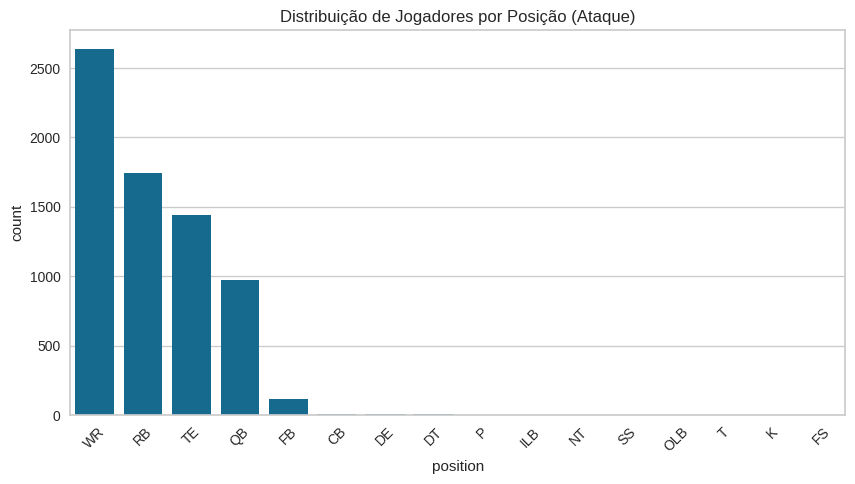

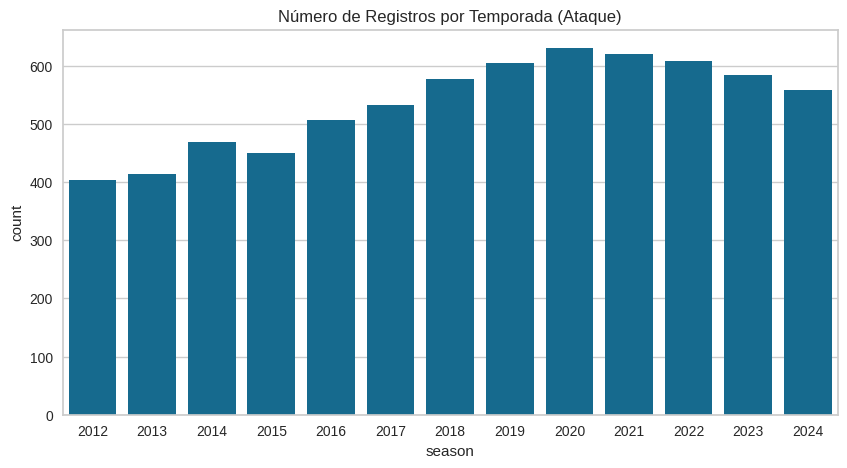

In [455]:
# Gráfico para verificar a distribuição dos jogadores por posição
plt.figure(figsize=(10,5))
sns.countplot(data=df_ataque_limpo, x='position', order=df_ataque_limpo['position'].value_counts().index)
plt.title('Distribuição de Jogadores por Posição (Ataque)')
plt.xticks(rotation=45)
plt.show()

# Número de registros por temporada
plt.figure(figsize=(10,5))
sns.countplot(data=df_ataque_limpo, x='season')
plt.title('Número de Registros por Temporada (Ataque)')
plt.show()


In [456]:
# Estatísticas do ataque
df_ataque_limpo.describe()[['passing_yards', 'rushing_yards', 'receiving_yards', 'total_touchdown', 'fantasy_points_ppr']]

passing_yards  rushing_yards  receiving_yards  total_touchdown  \
count    6954.000000    6954.000000      6954.000000      6954.000000   
mean      234.644953     102.130860       221.098504         3.616192   
std       842.062334     239.783109       306.600714         6.347103   
min        -7.000000     -31.000000       -15.000000         0.000000   
25%         0.000000       0.000000        11.000000         0.000000   
50%         0.000000       2.000000        85.000000         1.000000   
75%         0.000000      61.000000       310.000000         4.000000   
max      5477.000000    2027.000000      1964.000000        56.000000   

       fantasy_points_ppr  
count         6954.000000  
mean            78.678392  
std             89.907939  
min             -4.720000  
25%             11.200000  
50%             41.400000  
75%            119.700000  
max            513.980000

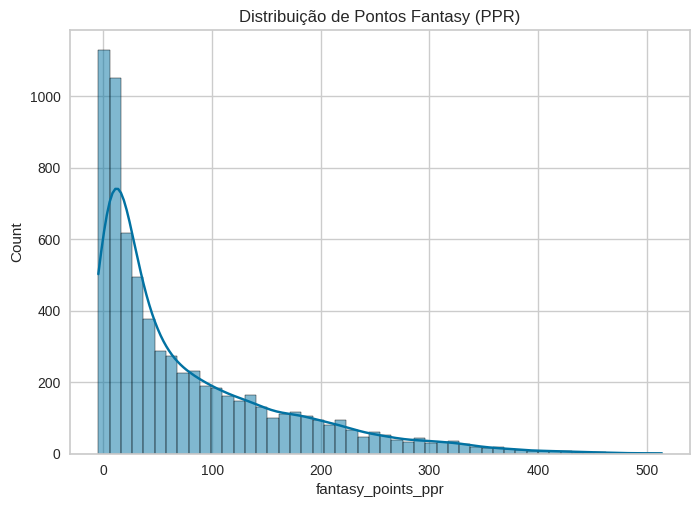

In [457]:
# Distribuição de Pontos do Fantasy
sns.histplot(df_ataque_limpo['fantasy_points_ppr'], bins=50, kde=True)
plt.title('Distribuição de Pontos Fantasy (PPR)')
plt.show()


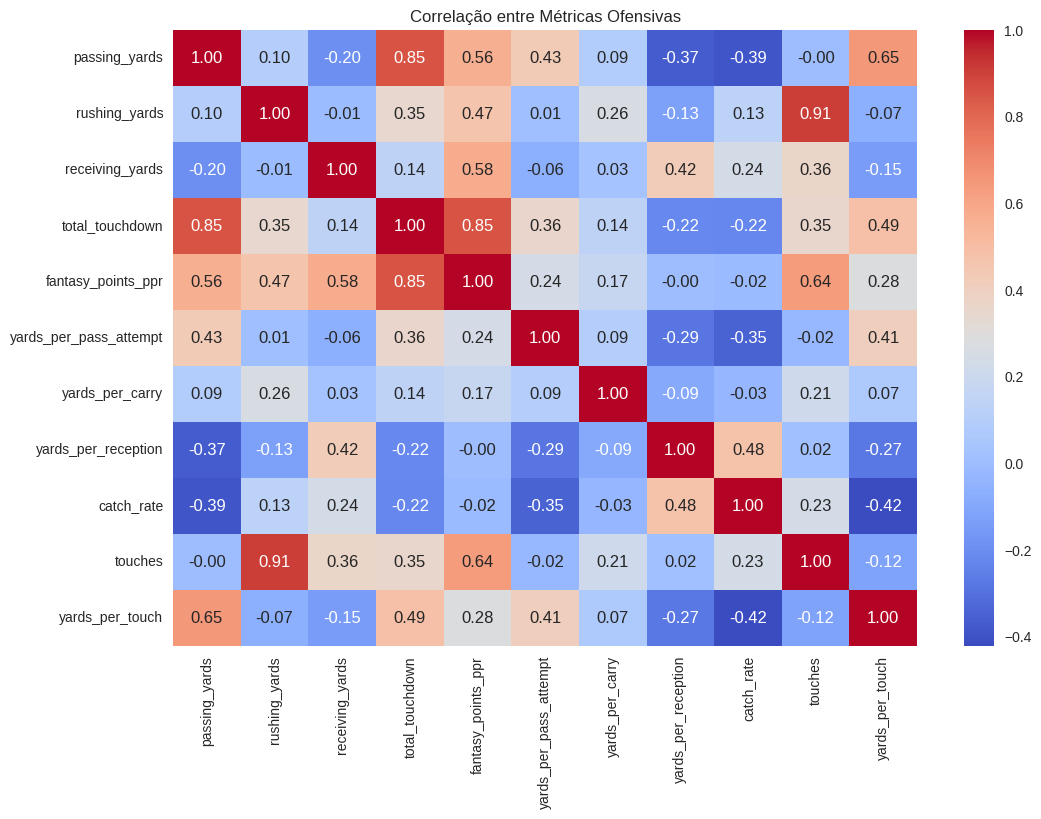

In [458]:
# Correlação entre variáveis
corr_cols = ['passing_yards', 'rushing_yards', 'receiving_yards', 'total_touchdown', 'fantasy_points_ppr', 'yards_per_pass_attempt',
             'yards_per_carry',  'yards_per_reception', 'catch_rate', 'touches', 'yards_per_touch']
plt.figure(figsize=(12, 8))
sns.heatmap(df_ataque_limpo[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Métricas Ofensivas')
plt.show()


#### **QBs**

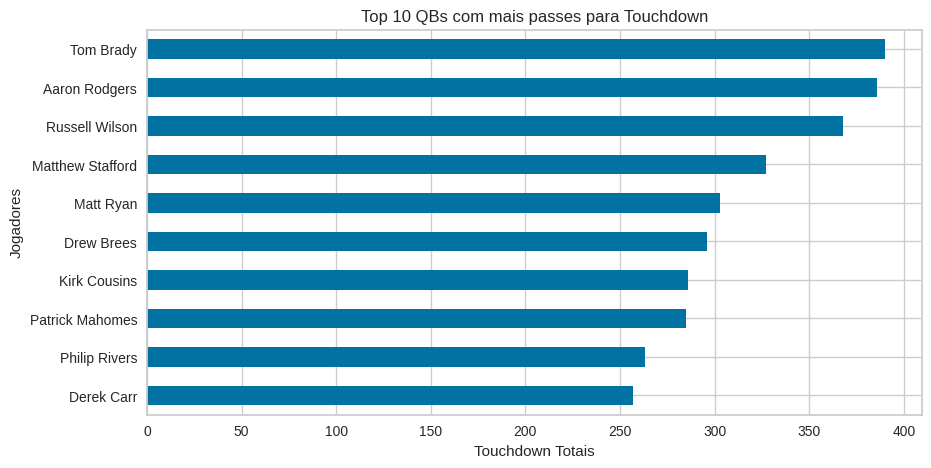

In [459]:
# Top QBs com mais passes para touchdown
qbs= df_ataque_limpo[df_ataque_limpo['position'] == 'QB']
top_qbs_touch = qbs.groupby('player_name')['pass_touchdown'].sum().nlargest(10)
top_qbs_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes para Touchdown')
plt.ylabel('Jogadores')
plt.xlabel('Touchdown Totais')
plt.show()


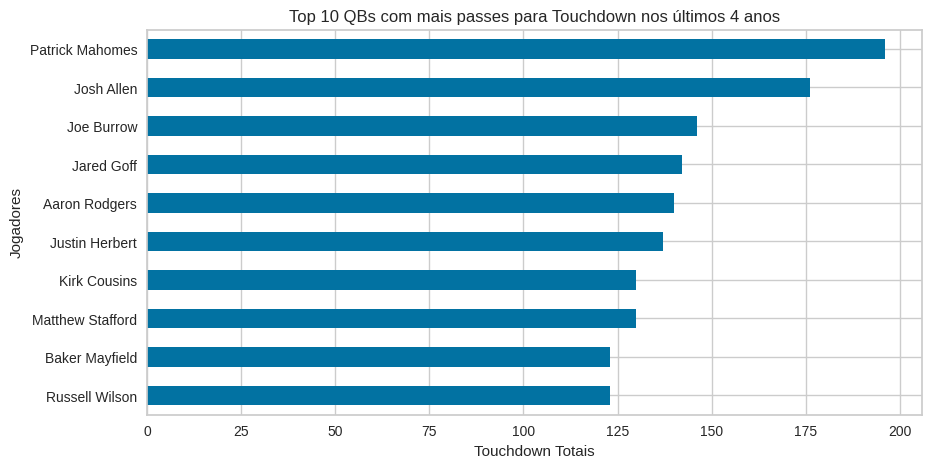

In [460]:
# Top QBs com mais passes para touchdown nos últimos 4 anos
qbs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'QB') & (df_ataque_limpo['season'] >= 2020)]
top_qbs_touch_recente = qbs_recentes.groupby('player_name')['pass_touchdown'].sum().nlargest(10)
top_qbs_touch_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes para Touchdown nos últimos 4 anos')
plt.xlabel('Touchdown Totais')
plt.ylabel('Jogadores')
plt.show()

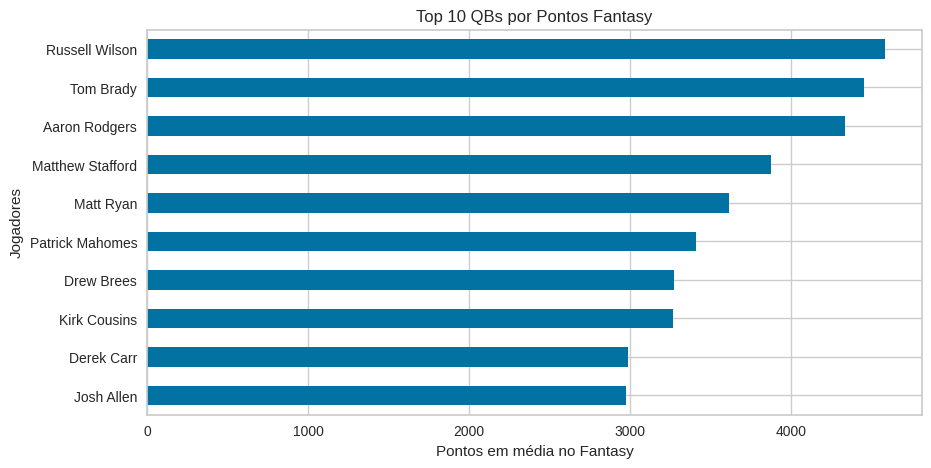

In [461]:
# Top QBs em pontos fantasy
top_qbs_fantasy = qbs.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_qbs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs por Pontos Fantasy')
plt.xlabel('Pontos em média no Fantasy')
plt.ylabel('Jogadores')
plt.show()


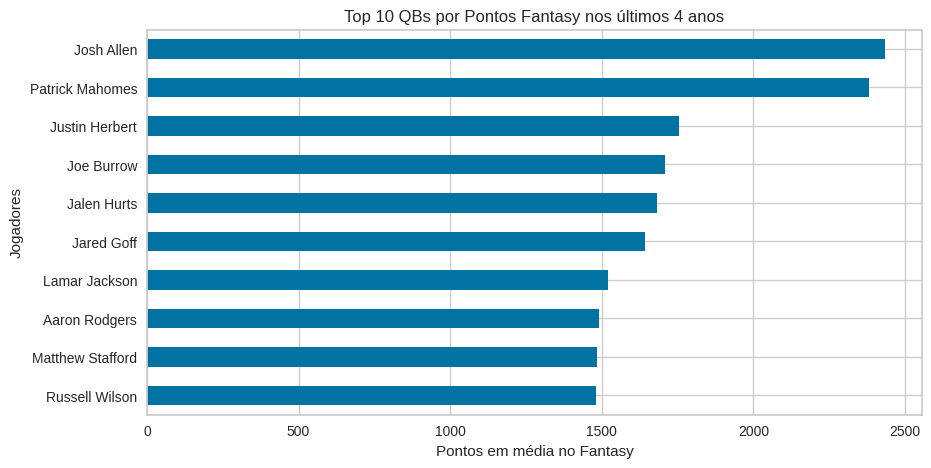

In [462]:
# Top 10 QBs por Pontos Fantasy nos últimos 4 anos
top_qbs_fantasy_recentes = qbs_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_qbs_fantasy_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs por Pontos Fantasy nos últimos 4 anos')
plt.xlabel('Pontos em média no Fantasy')
plt.ylabel('Jogadores')
plt.show()

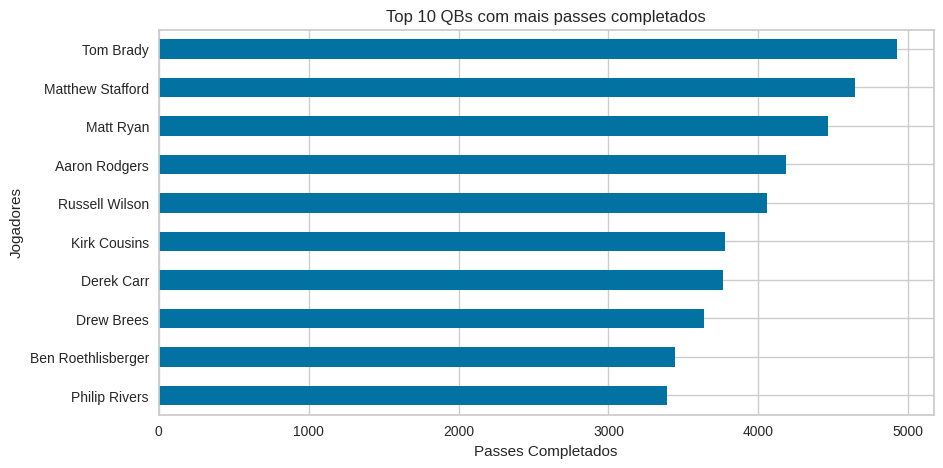

In [463]:
# Top QBs com mais passes completados
top_qbs_compl = qbs.groupby('player_name')['complete_pass'].sum().nlargest(10)
top_qbs_compl.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes completados')
plt.xlabel('Passes Completados')
plt.ylabel('Jogadores')
plt.show()

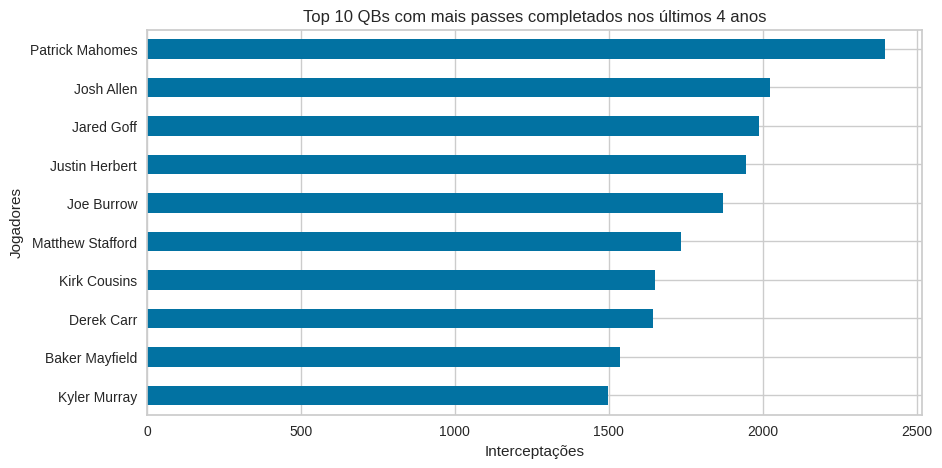

In [464]:
# Top QBs com mais passes completados os últimos 4 anos
top_qbs_compl_recentes = qbs_recentes.groupby('player_name')['complete_pass'].sum().nlargest(10)
top_qbs_compl_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes completados nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

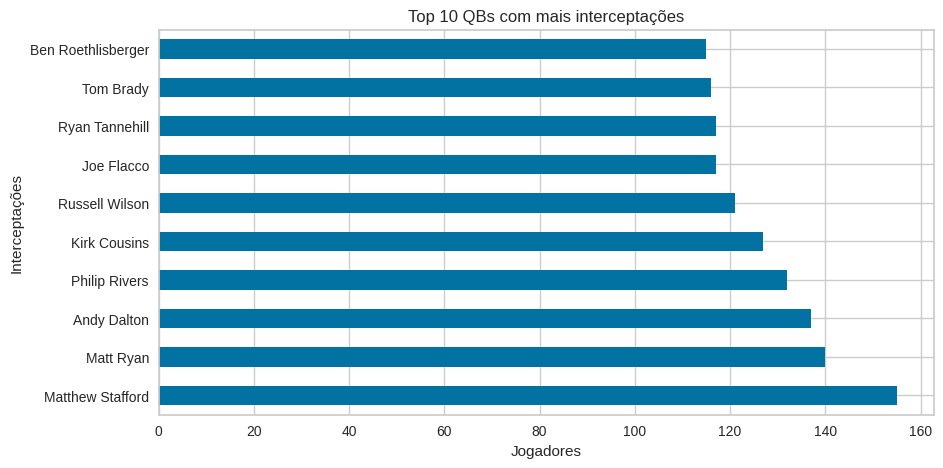

In [465]:
# Top QBs com mais interceptações
top_qbs_int = qbs.groupby('player_name')['interception'].sum().nlargest(10)
top_qbs_int.plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais interceptações')
plt.ylabel('Interceptações')
plt.xlabel('Jogadores')
plt.show()

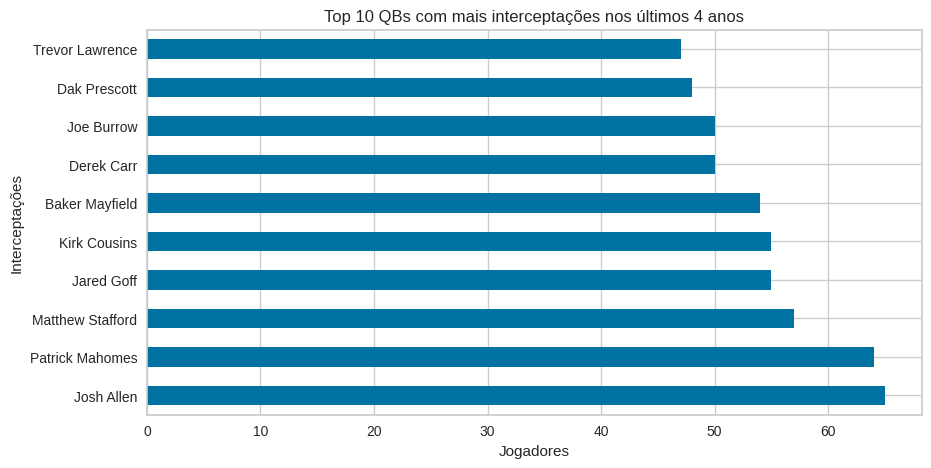

In [466]:
# Top QBs com mais interceptações nos últimos 4 anos
top_qbs_int = qbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_qbs_int.plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais interceptações nos últimos 4 anos')
plt.ylabel('Interceptações')
plt.xlabel('Jogadores')
plt.show()

####**WR**

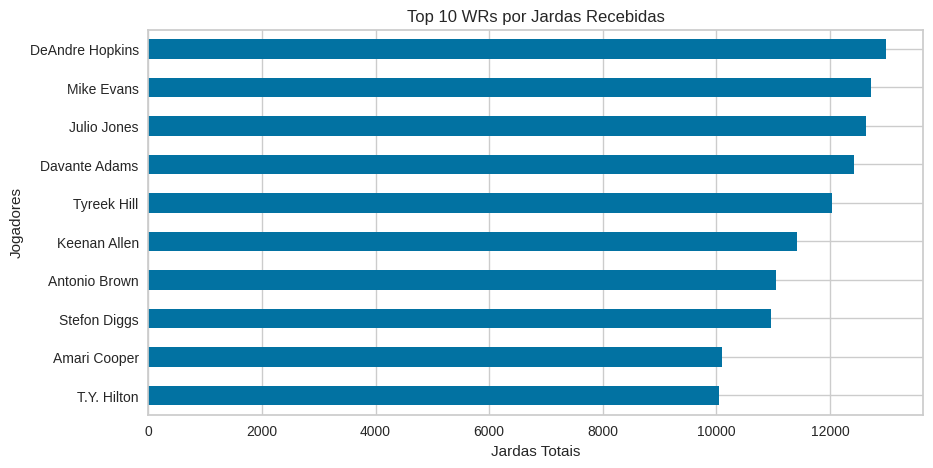

In [467]:
# Top WRs em jardas recebidas
wrs = df_ataque_limpo[df_ataque_limpo['position'] == 'WR']
top_wrs = wrs.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_wrs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


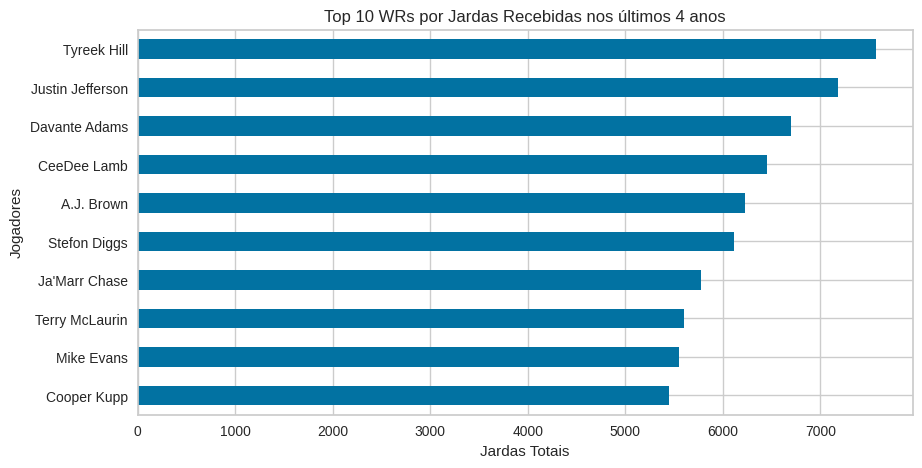

In [468]:
# Top WRs em jardas recebidas nos últimos 4 anos
top_wrs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'WR') & (df_ataque_limpo['season'] >= 2020)]
top_wrs_jardas_recentes = top_wrs_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_wrs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


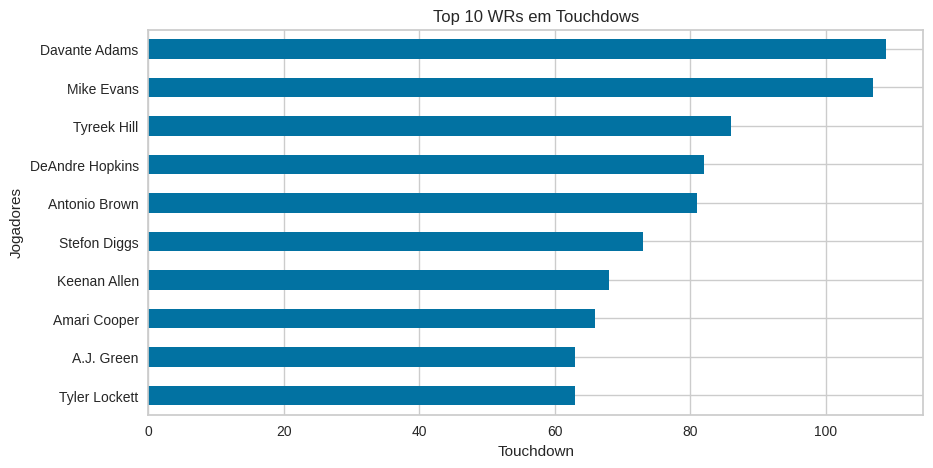

In [469]:
# Top WRs em Tochdowns
top_wrs_touch = wrs.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_wrs_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Touchdows')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

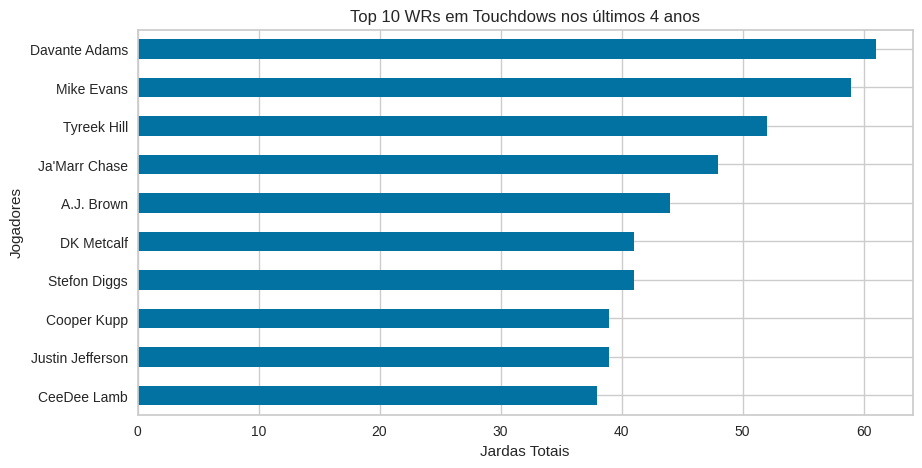

In [470]:
# Top WRs em jardas recebidas nos últimos 4 anos
top_wrs_touch_recentes = top_wrs_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_wrs_touch_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Touchdows nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


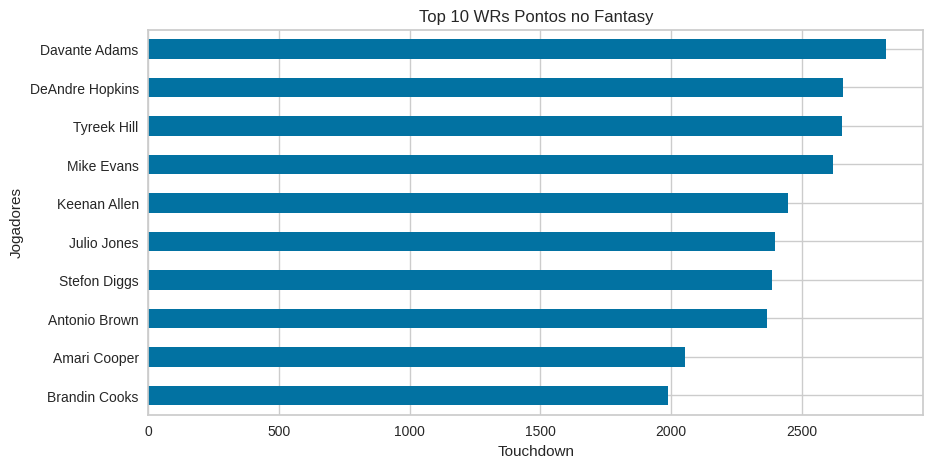

In [471]:
# Top WRs Pontos no Fantasy
top_wrs_fantasy = wrs.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_wrs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs Pontos no Fantasy')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

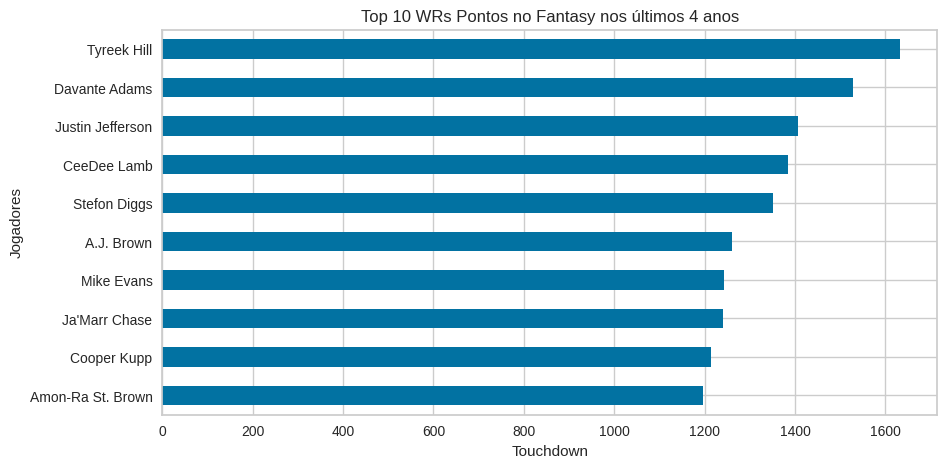

In [472]:
# Top WRs Pontos no Fantasy nos últimos 4 anos
top_wrs_fantasy_recente = top_wrs_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_wrs_fantasy_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

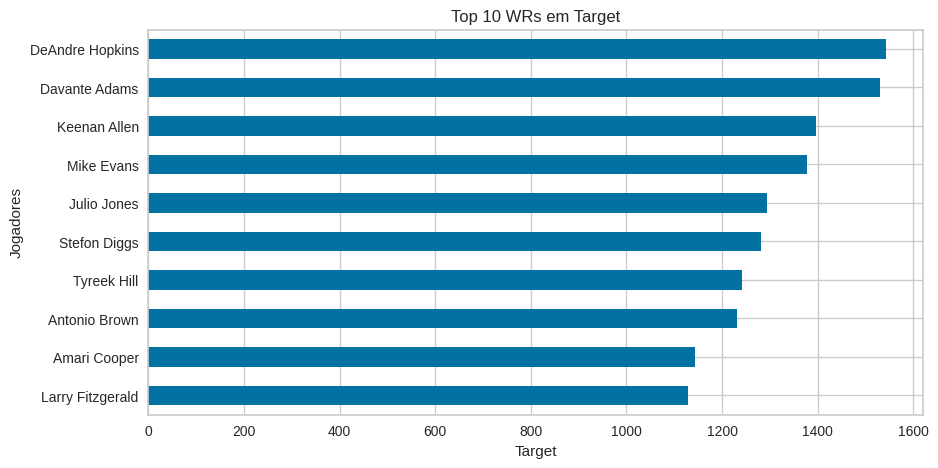

In [473]:
# Top WRs em Target
top_wrs_target = wrs.groupby('player_name')['targets'].sum().nlargest(10)
top_wrs_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()


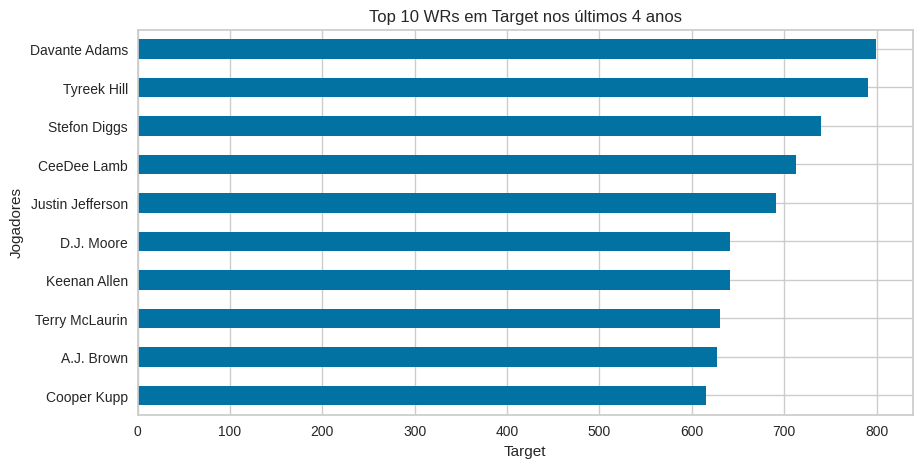

In [474]:
# Top WRs em Target nos últimos 4 anos
top_wrs_target_recentes = top_wrs_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_wrs_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Target nos últimos 4 anos')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()


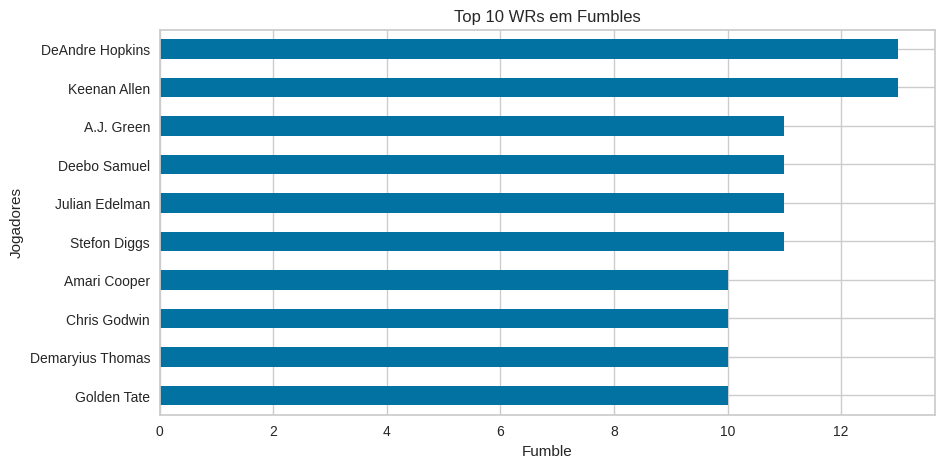

In [475]:
# Top WRs em Fumble
top_wrs_fumble = wrs.groupby('player_name')['fumble'].sum().nlargest(10)
top_wrs_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

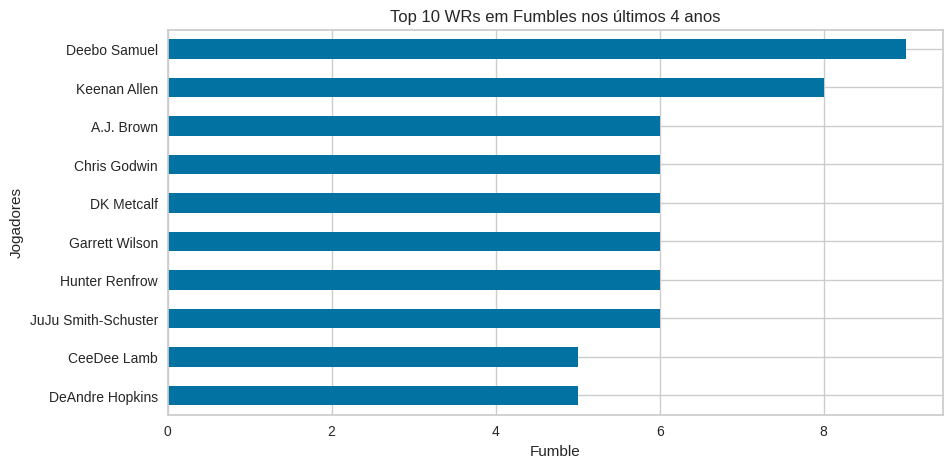

In [476]:
# Top WRs em Fumblee nos últimos 4 anos
top_wrs_fumble_recentes = top_wrs_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_wrs_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

####**TE**

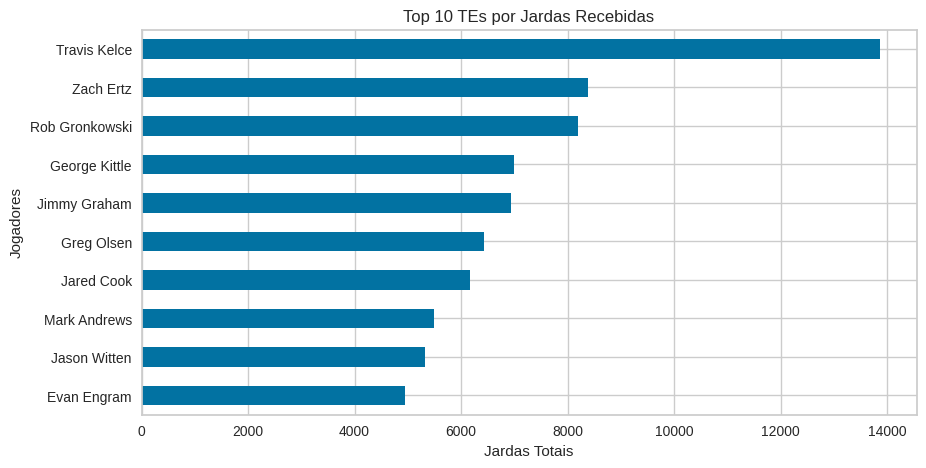

In [477]:
# Top TE em jardas recebidas
tes = df_ataque_limpo[df_ataque_limpo['position'] == 'TE']
top_tes = tes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_tes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

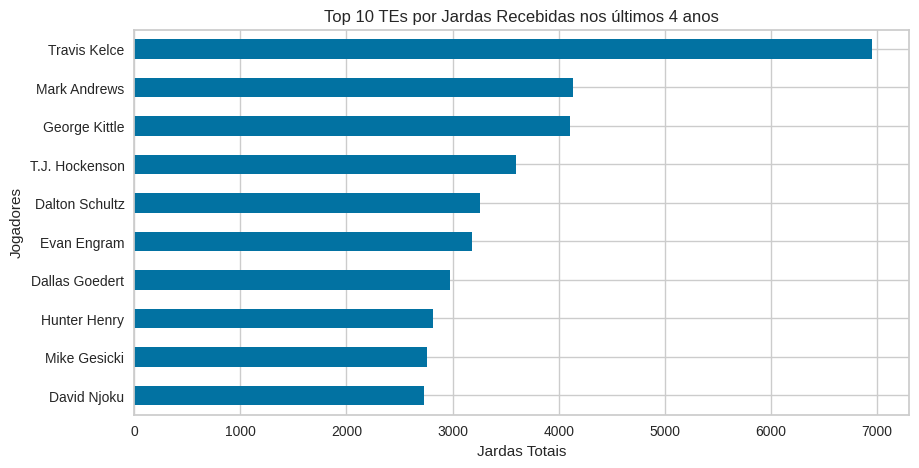

In [478]:
# Top tes em jardas recebidas nos últimos 4 anos
top_tes_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'TE') & (df_ataque_limpo['season'] >= 2020)]
top_tes_jardas_recentes = top_tes_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_tes_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

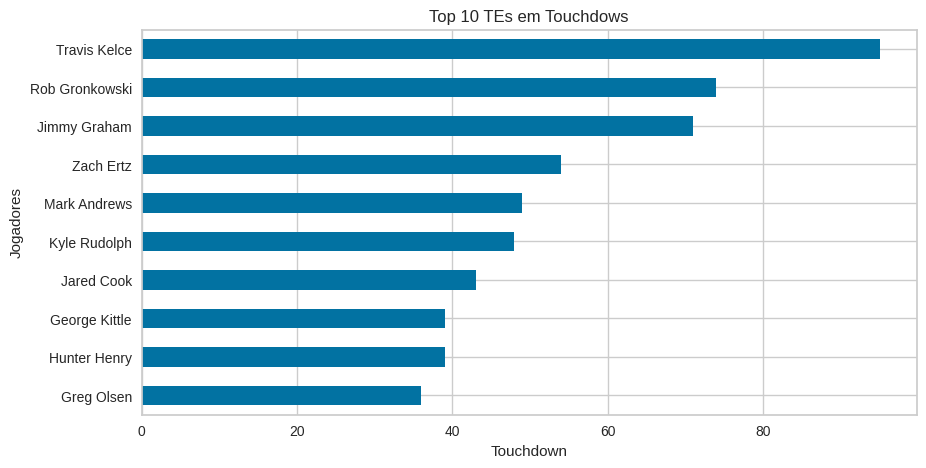

In [479]:
# Top TEs em Tochdowns
top_tes_touch = tes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_tes_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Touchdows')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

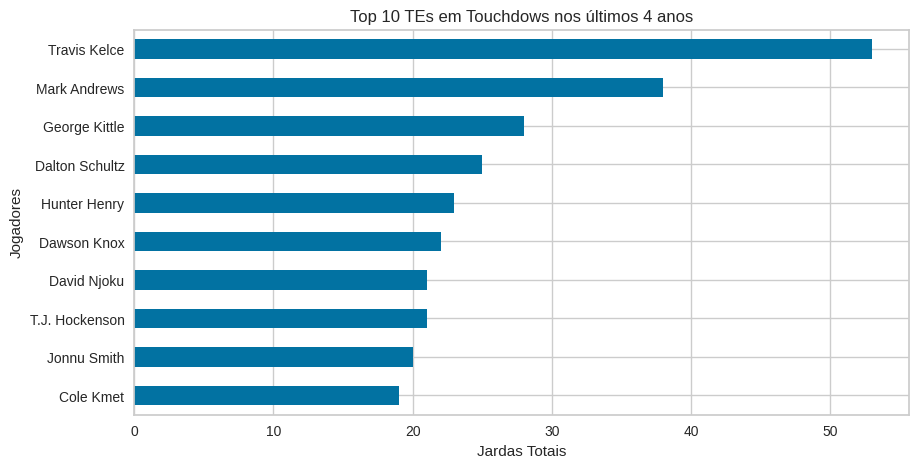

In [480]:
# Top TEs em jardas recebidas nos últimos 4 anos
top_tes_touch_recentes = top_tes_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_tes_touch_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Touchdows nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

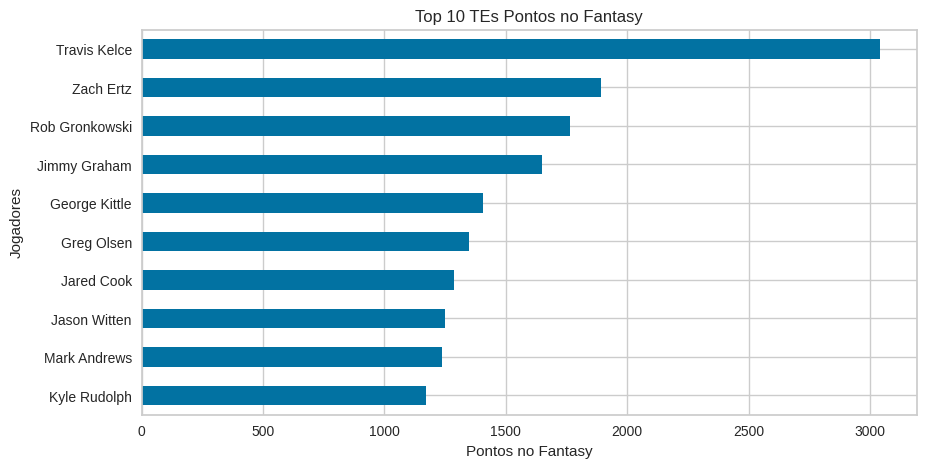

In [481]:
# Top TEs Pontos no Fantasy
top_tes_fantasy = tes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_tes_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs Pontos no Fantasy')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

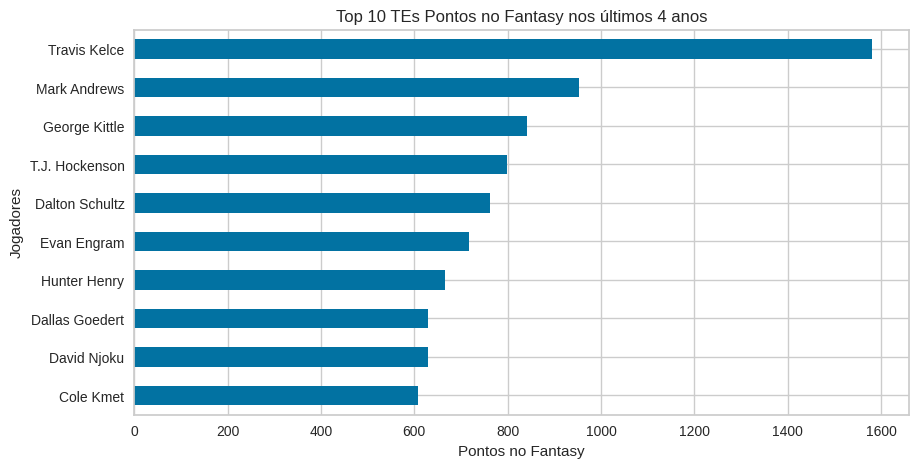

In [482]:
# Top TEs Pontos no Fantasy nos últimos 4 anos
top_tes_fantasy_recente = top_tes_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_tes_fantasy_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

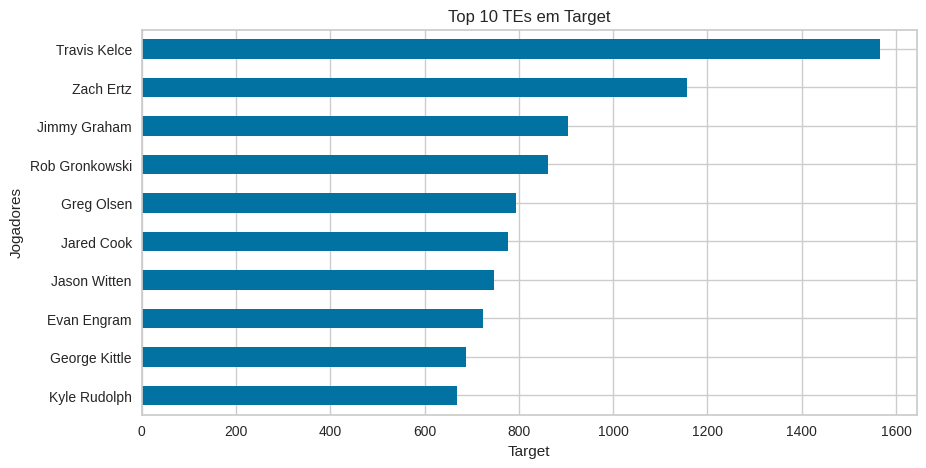

In [483]:
# Top TEs em Target
top_tes_target = tes.groupby('player_name')['targets'].sum().nlargest(10)
top_tes_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

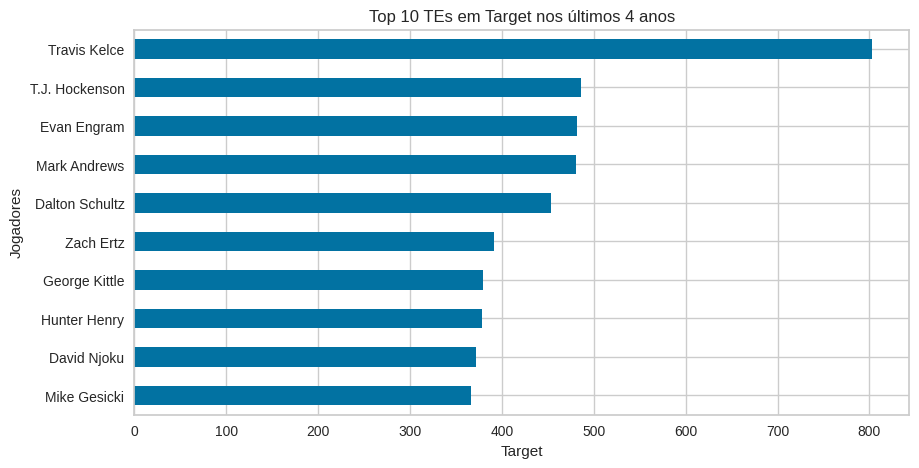

In [484]:
# Top TEs em Target nos últimos 4 anos
top_tes_target_recentes = top_tes_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_tes_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Target nos últimos 4 anos')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

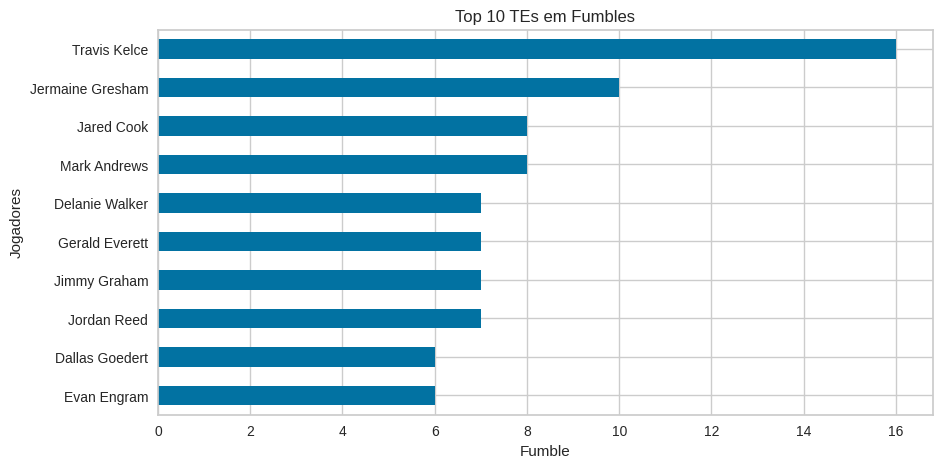

In [485]:
# Top TEs em Fumble
top_tes_fumble = tes.groupby('player_name')['fumble'].sum().nlargest(10)
top_tes_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

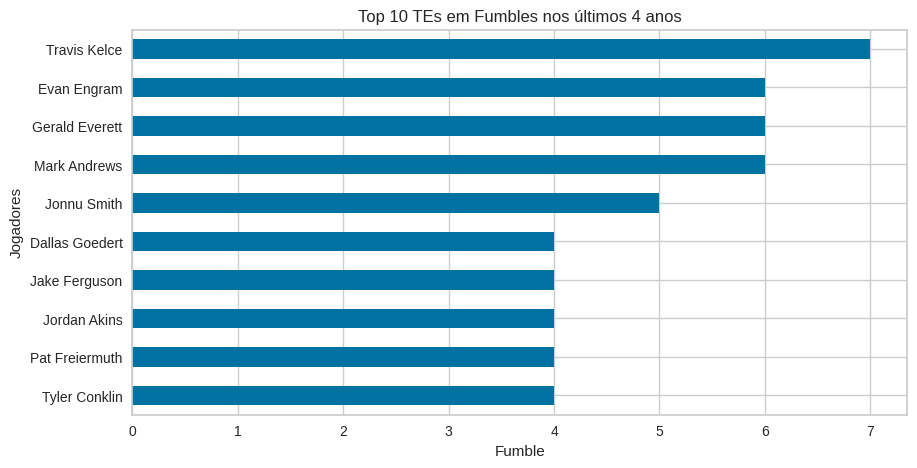

In [486]:
# Top TEs em Fumblee nos últimos 4 anos
top_tes_fumble_recentes = top_tes_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_tes_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

####**RB**

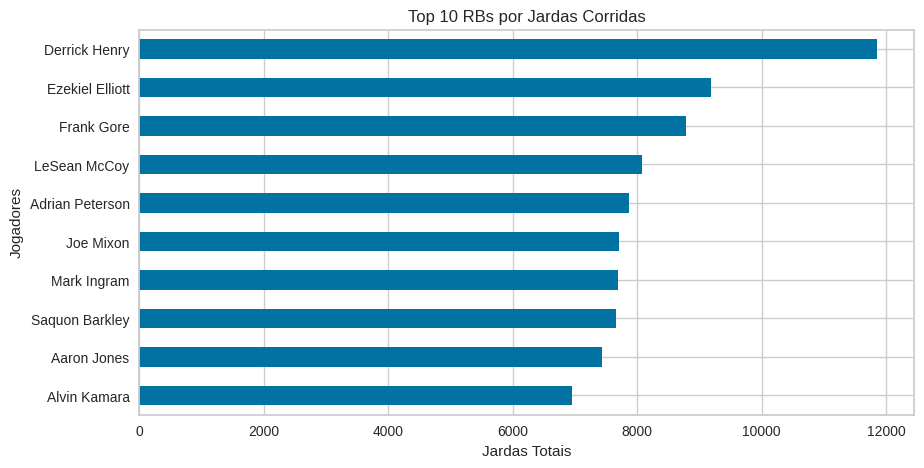

In [487]:
# Top rbs em jardas corridas
rbs = df_ataque_limpo[df_ataque_limpo['position'] == 'RB']
top_rbs = rbs.groupby('player_name')['rushing_yards'].sum().nlargest(10)
top_rbs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Corridas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

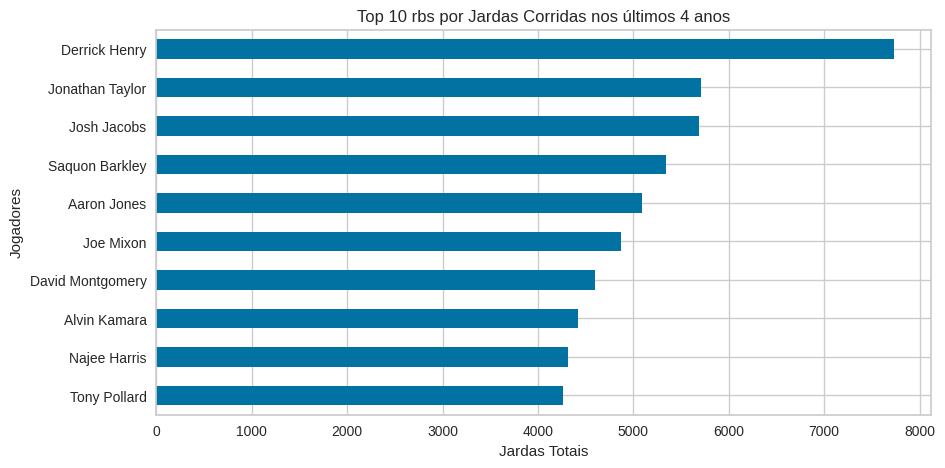

In [488]:
# Top rbs em jardas recebidas nos últimos 4 anos
top_rbs_recenrbs = df_ataque_limpo[(df_ataque_limpo['position'] == 'RB') & (df_ataque_limpo['season'] >= 2020)]
top_rbs_jardas_recentes = top_rbs_recenrbs.groupby('player_name')['rushing_yards'].sum().nlargest(10)
top_rbs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 rbs por Jardas Corridas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

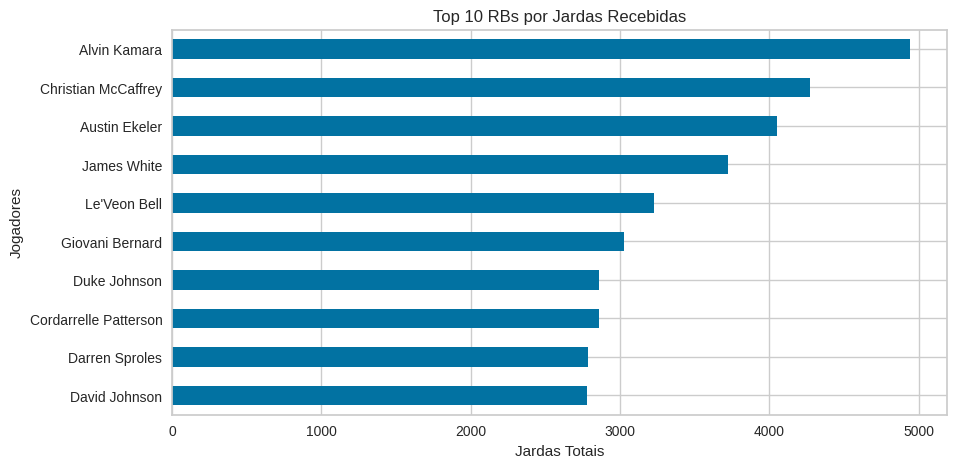

In [489]:
# Top RBs em jardas recebidas
rbs = df_ataque_limpo[df_ataque_limpo['position'] == 'RB']
top_rbs = rbs.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_rbs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

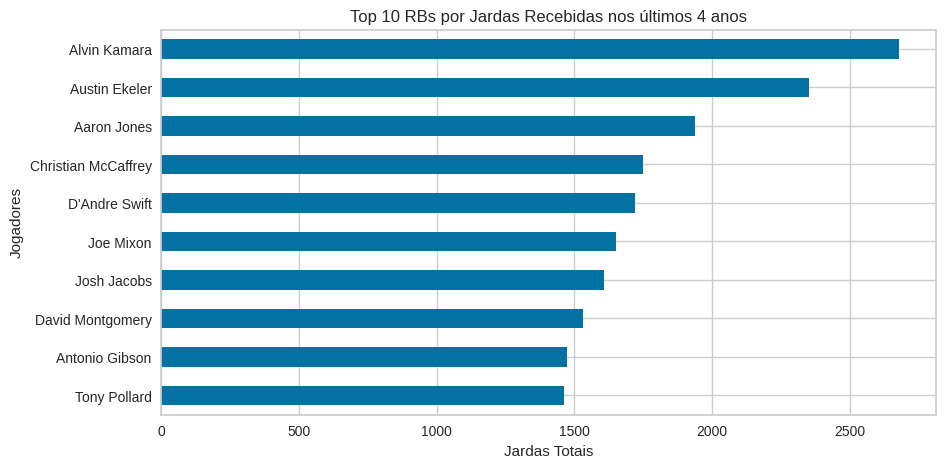

In [490]:
# Top RBs em jardas recebidas nos últimos 4 anos
top_rbs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'RB') & (df_ataque_limpo['season'] >= 2020)]
top_rbs_jardas_recentes = top_rbs_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_rbs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

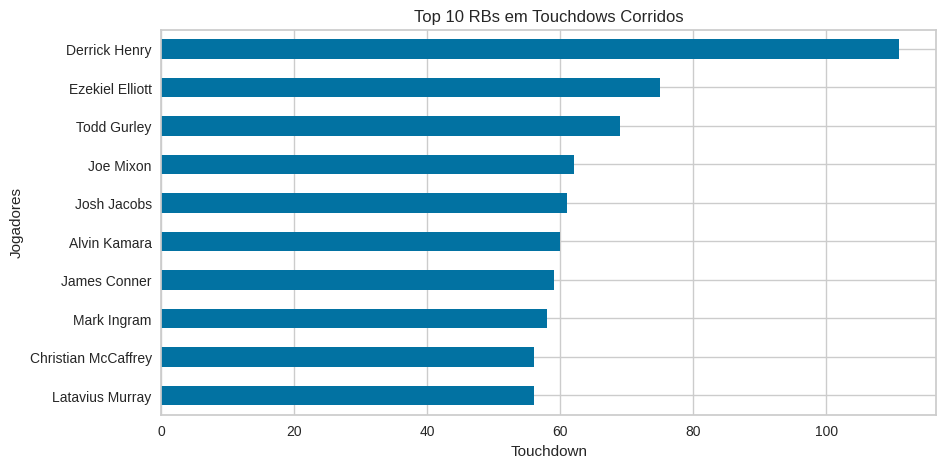

In [491]:
# Top RBs em Tochdowns Corridos
top_rbs_rush_td = rbs.groupby('player_name')['rush_touchdown'].sum().nlargest(10)
top_rbs_rush_td.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows Corridos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

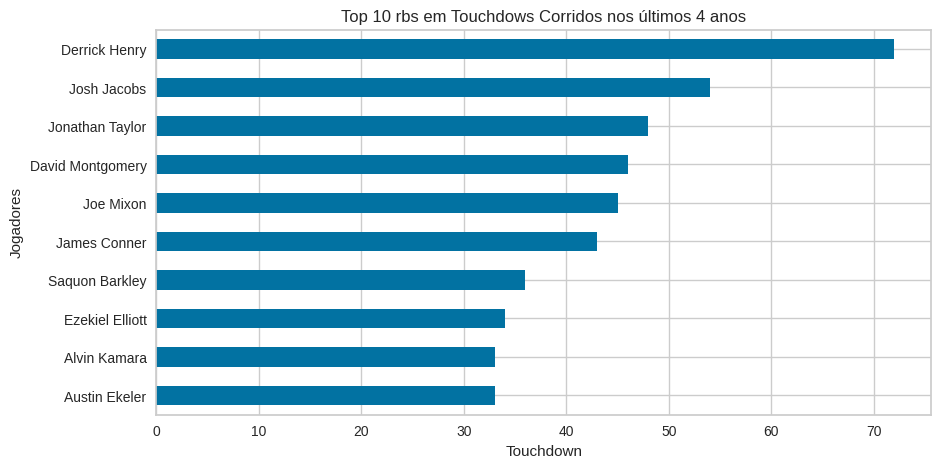

In [492]:
# Top rbs em Touchdown corridos nos últimos 4 anos
top_rbs_rush_td_recentes = top_rbs_recentes.groupby('player_name')['rush_touchdown'].sum().nlargest(10)
top_rbs_rush_td_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 rbs em Touchdows Corridos nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

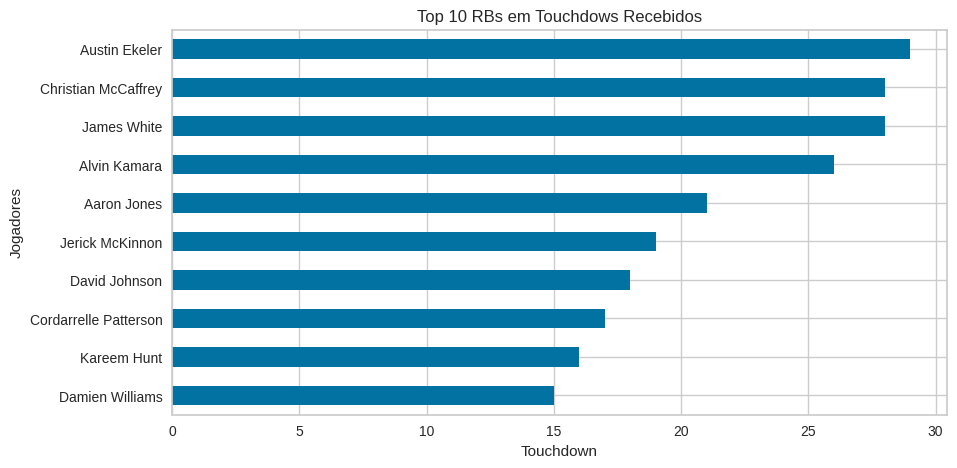

In [493]:
# Top RBs em Tochdowns Recebidos
top_rbs_td_receb = rbs.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_rbs_td_receb.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows Recebidos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

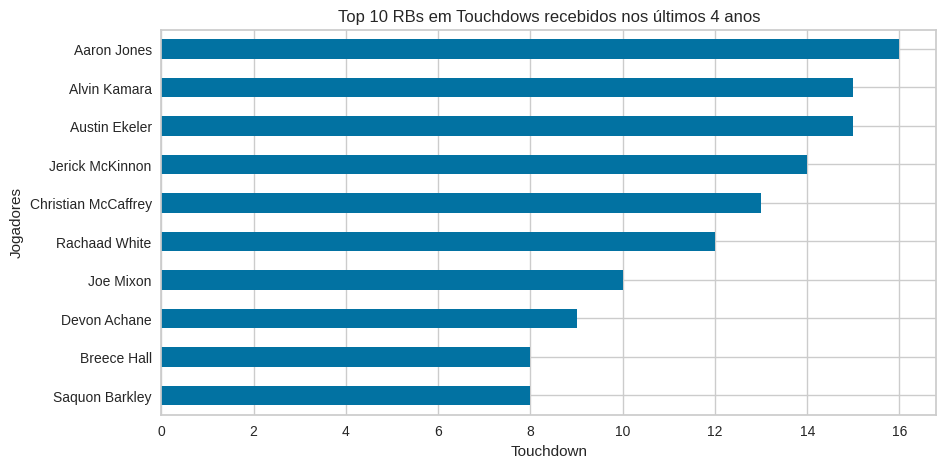

In [494]:
# Top RBs em Tochdowns recebidos nos últimos 4 anos
top_rbs_td_receb_recentes = top_rbs_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_rbs_td_receb_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows recebidos nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

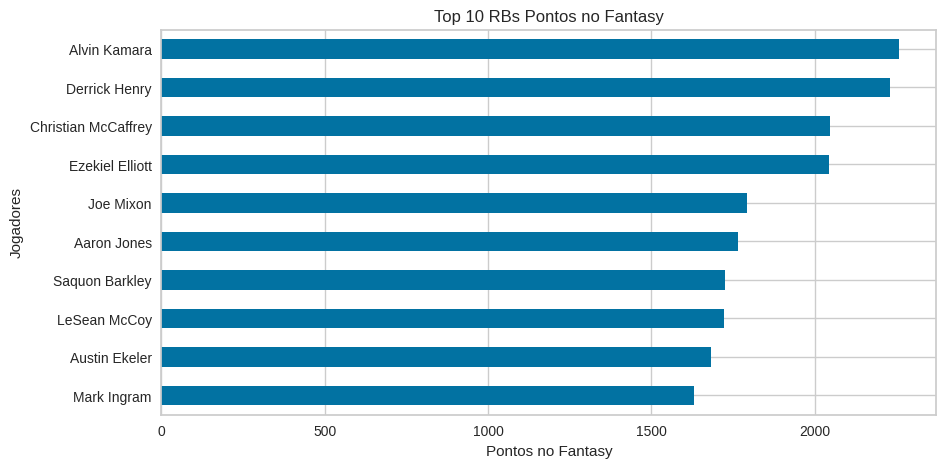

In [495]:
# Top rbs Pontos no Fantasy
top_rbs_fantasy = rbs.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_rbs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs Pontos no Fantasy')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

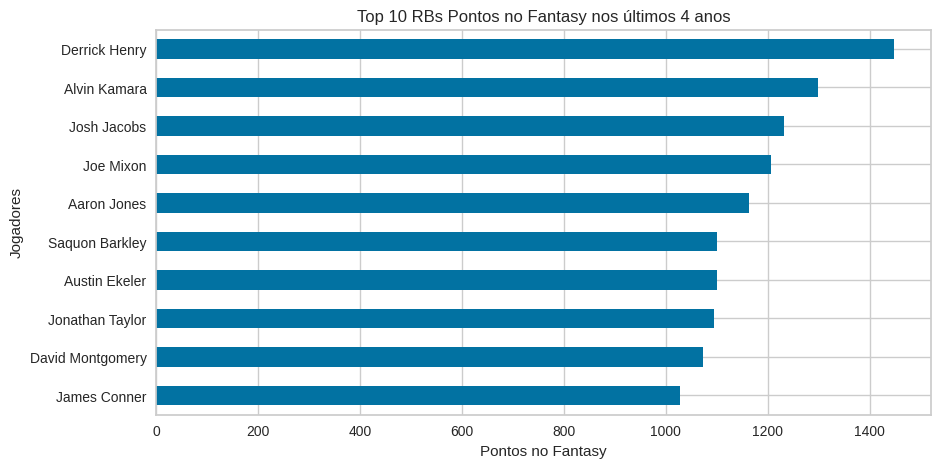

In [496]:
# Top rbs Pontos no Fantasy nos últimos 4 anos
top_rbs_fantasy_recenrb = top_rbs_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_rbs_fantasy_recenrb.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

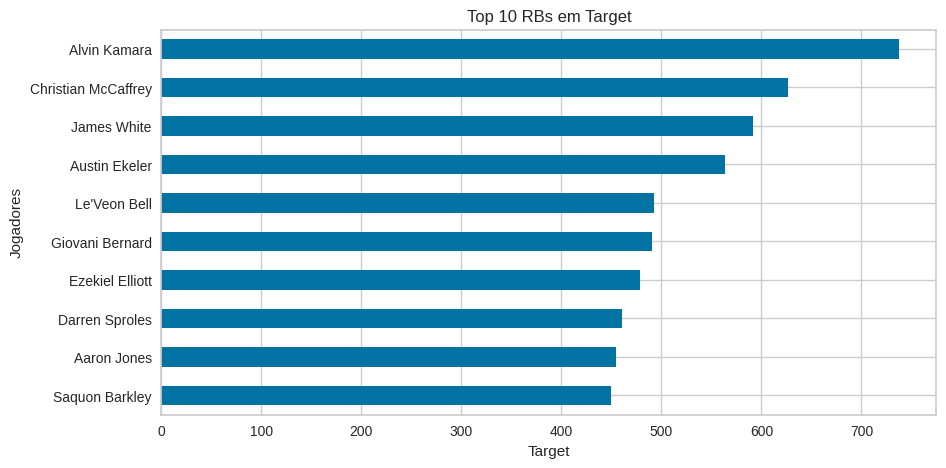

In [497]:
# Top rbs em Target
top_rbs_target = rbs.groupby('player_name')['targets'].sum().nlargest(10)
top_rbs_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

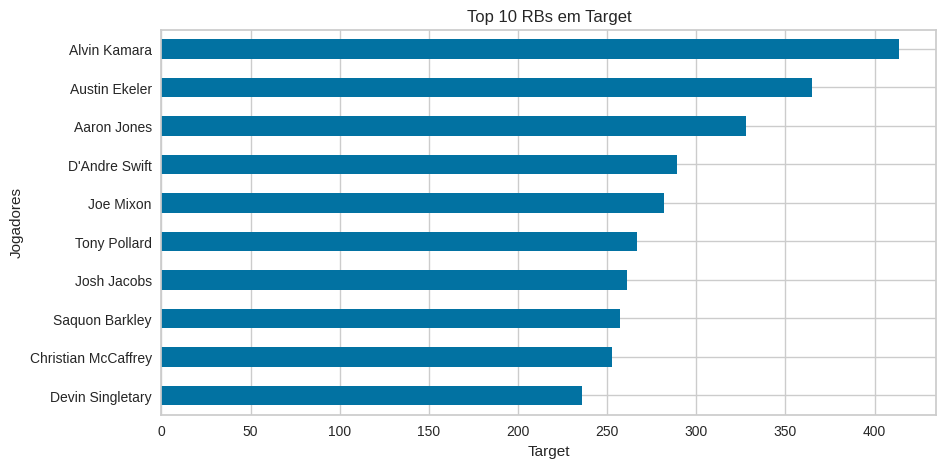

In [498]:
# Top rbs em Target nos últimos 4 anos
top_rbs_target_recentes = top_rbs_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_rbs_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

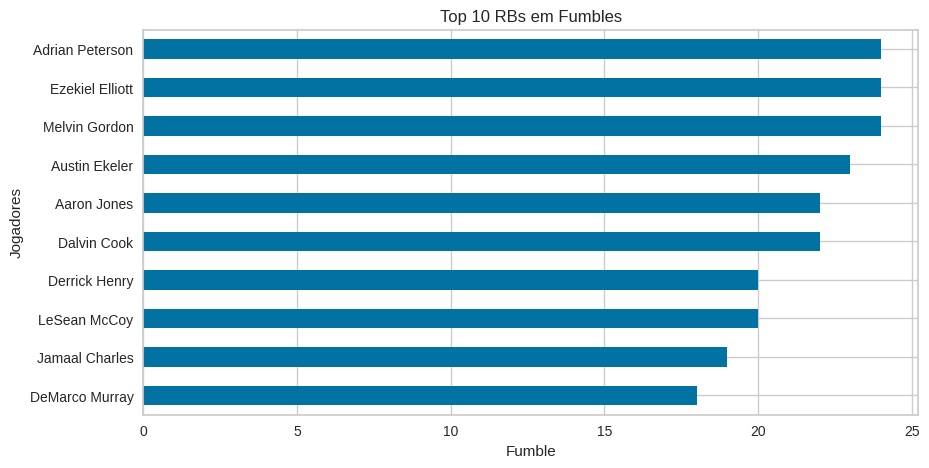

In [499]:
# Top rbs em Fumble
top_rbs_fumble = rbs.groupby('player_name')['fumble'].sum().nlargest(10)
top_rbs_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

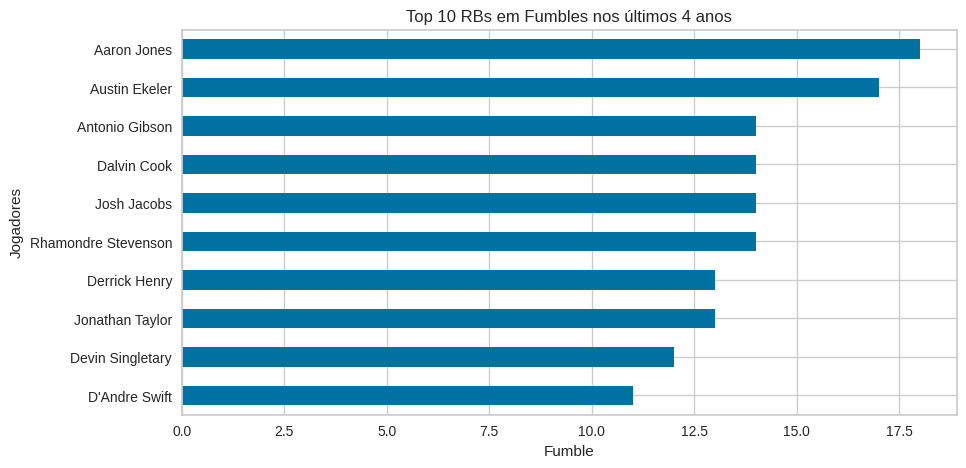

In [500]:
# Top rbs em Fumblee nos últimos 4 anos
top_rbs_fumble_recentes = top_rbs_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_rbs_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

TDs aéreos: 2012 → 2024
Total TDs na primeira temporada: 1364
Total TDs na última temporada: 1592
Variação percentual entre primeira e última: 16.7%


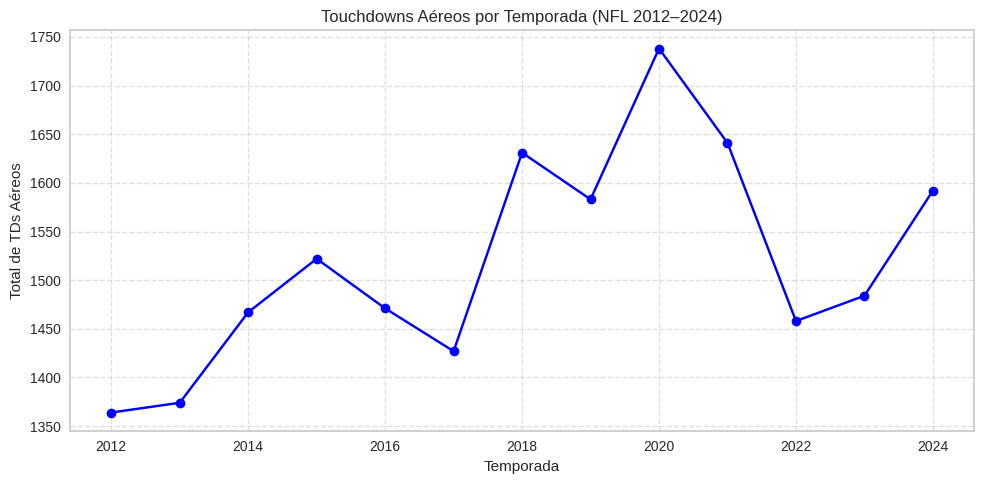

In [501]:
# Agrupando touchdowns de passe por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['pass_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['pass_touchdown'].iloc[0], td_por_temporada['pass_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs aéreos: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['pass_touchdown'], marker='o', color='blue')
plt.title('Touchdowns Aéreos por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs Aéreos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



TDs aéreos: 2012 → 2024
Total TDs na primeira temporada: 347
Total TDs na última temporada: 524
Variação percentual entre primeira e última: 51.0%


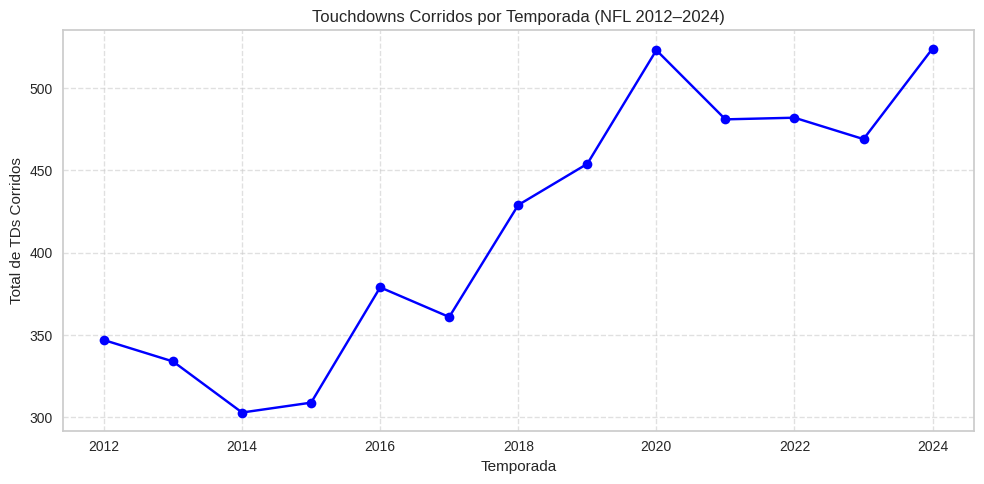

In [502]:
# Agrupando touchdowns de corrida por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['rush_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['rush_touchdown'].iloc[0], td_por_temporada['rush_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs aéreos: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['rush_touchdown'], marker='o', color='blue')
plt.title('Touchdowns Corridos por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs Corridos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

TDs totais: 2012 → 2024
Total TDs na primeira temporada: 1711
Total TDs na última temporada: 2116
Variação percentual entre primeira e última: 23.7%


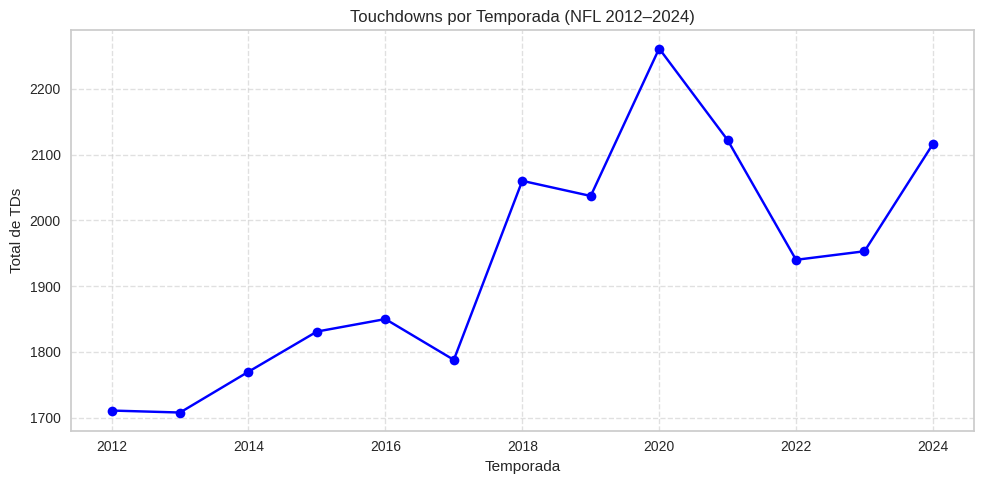

In [503]:
# Agrupando touchdowns por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['total_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['total_touchdown'].iloc[0], td_por_temporada['total_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['total_touchdown'], marker='o', color='blue')
plt.title('Touchdowns por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Passes completados totais: 2012 → 2024
Total de passes completados na primeira temporada: 10286
Total de passes completados na última temporada: 11807
Variação percentual entre primeira e última: 14.8%


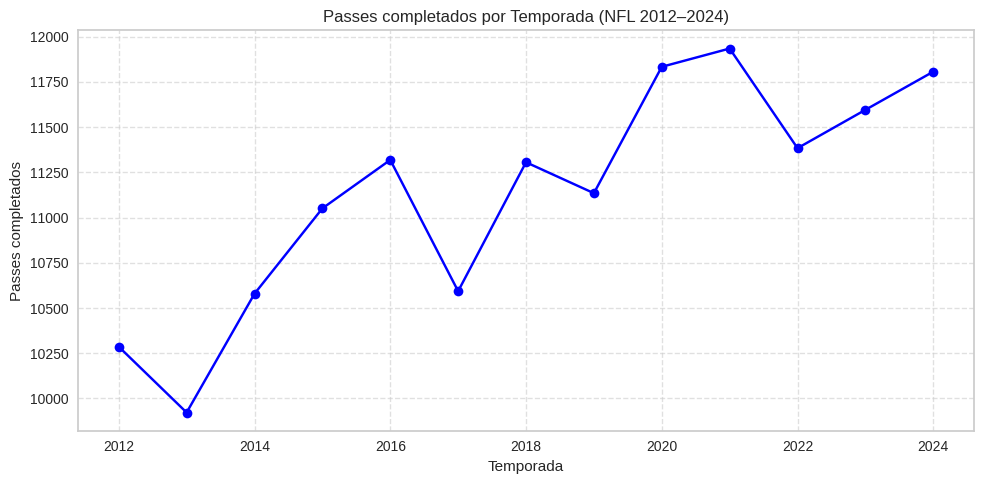

In [504]:
# Agrupando por passes completados por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['complete_pass']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['complete_pass'].iloc[0], td_por_temporada['complete_pass'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Passes completados totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de passes completados na primeira temporada: {primeira:.0f}")
print(f"Total de passes completados na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['complete_pass'], marker='o', color='blue')
plt.title('Passes completados por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Passes completados')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jardas passadas: 2012 → 2024
Jardas passadas na primeira temporada: 119740
Jardas passadas na última temporada: 129298
Variação percentual entre primeira e última: 8.0%


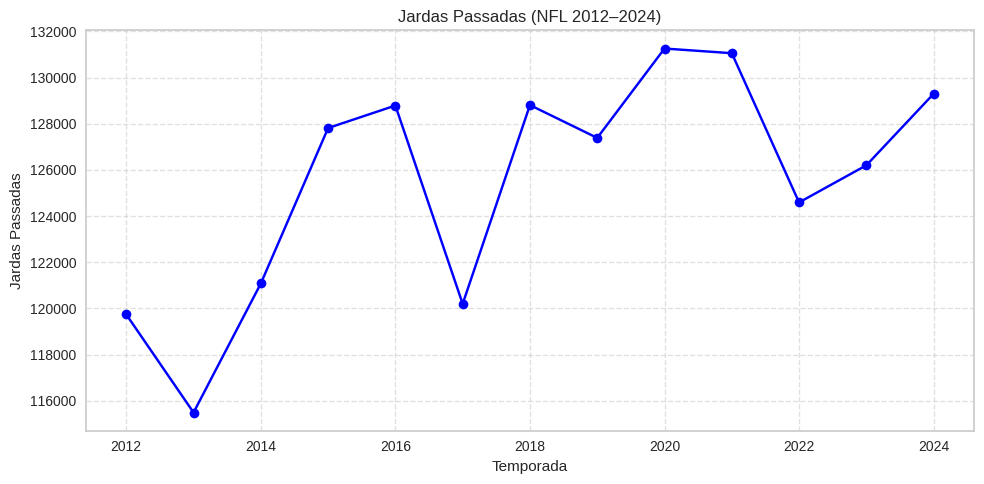

In [505]:
# Agrupando por jardas passads por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['passing_yards']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['passing_yards'].iloc[0], td_por_temporada['passing_yards'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jardas passadas: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Jardas passadas na primeira temporada: {primeira:.0f}")
print(f"Jardas passadas na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['passing_yards'], marker='o', color='blue')
plt.title('Jardas Passadas (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jardas Passadas')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Tentativa de corrida totais: 2012 → 2024
Total de tentativa de corridas na primeira temporada: 11747
Total de tentativa de corridas na última temporada: 14266
Variação percentual entre primeira e última: 21.4%


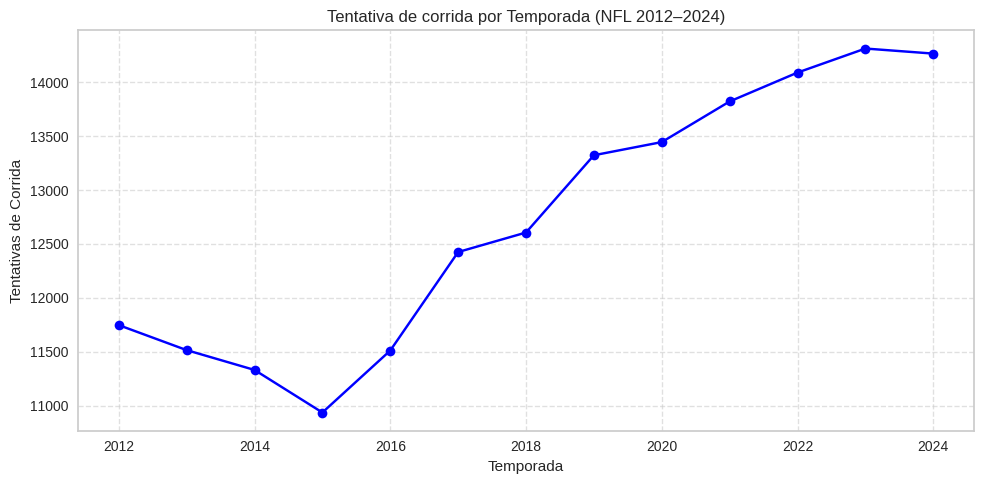

In [506]:
# Agrupando por tentativas de corridas por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['rush_attempts']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['rush_attempts'].iloc[0], td_por_temporada['rush_attempts'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Tentativa de corrida totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de tentativa de corridas na primeira temporada: {primeira:.0f}")
print(f"Total de tentativa de corridas na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['rush_attempts'], marker='o', color='blue')
plt.title('Tentativa de corrida por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Tentativas de Corrida')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jardas por carregada totais: 2012 → 2024
Total de Jardas por carregada na primeira temporada: 1042
Total de Jardas por carregada na última temporada: 1331
Variação percentual entre primeira e última: 27.6%


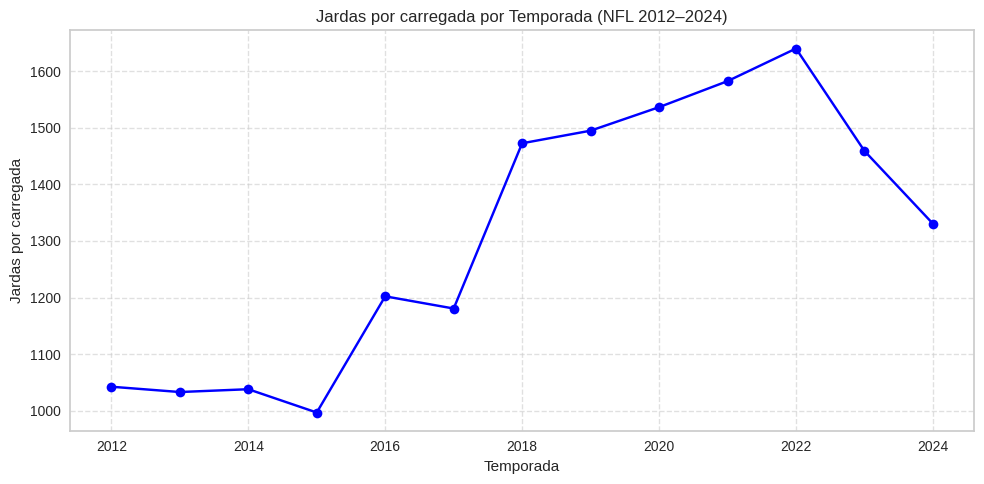

In [507]:
# Agrupando por jardas por carregada por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['yards_per_carry']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['yards_per_carry'].iloc[0], td_por_temporada['yards_per_carry'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jardas por carregada totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de Jardas por carregada na primeira temporada: {primeira:.0f}")
print(f"Total de Jardas por carregada na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['yards_per_carry'], marker='o', color='blue')
plt.title('Jardas por carregada por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jardas por carregada')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jardas por recepção totais: 2012 → 2024
Total de Jardas por recepção na primeira temporada: 3610
Total de Jardas por recepção na última temporada: 4677
Variação percentual entre primeira e última: 29.6%


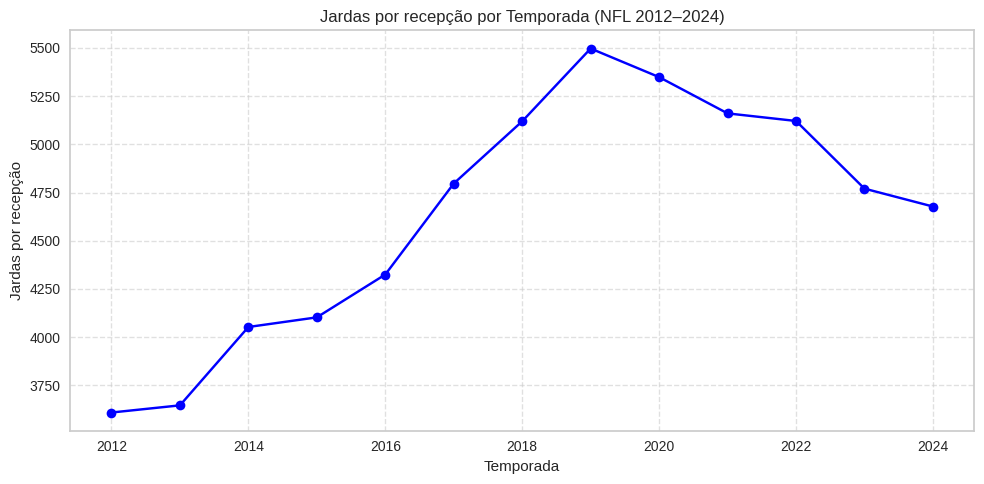

In [508]:
# Agrupando por jardas por recepção por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['yards_per_reception']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['yards_per_reception'].iloc[0], td_por_temporada['yards_per_reception'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jardas por recepção totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de Jardas por recepção na primeira temporada: {primeira:.0f}")
print(f"Total de Jardas por recepção na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['yards_per_reception'], marker='o', color='blue')
plt.title('Jardas por recepção por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jardas por recepção')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Taxa de recepção: 2012 → 2024
Total de taxa por recepção na primeira temporada: 224
Total de taxa por recepção na última temporada: 331
Variação percentual entre primeira e última: 48.0%


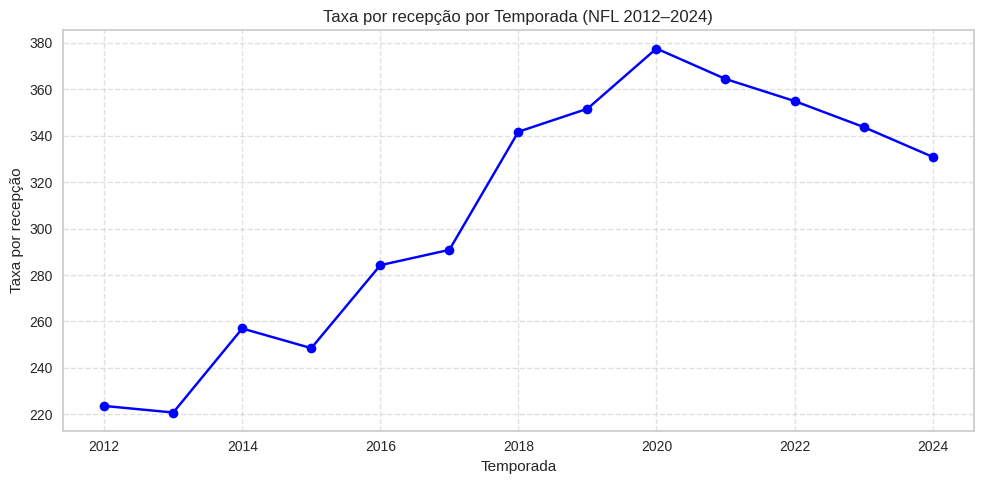

In [509]:
# Agrupando por taxa por recepção por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['catch_rate']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['catch_rate'].iloc[0], td_por_temporada['catch_rate'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Taxa de recepção: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de taxa por recepção na primeira temporada: {primeira:.0f}")
print(f"Total de taxa por recepção na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['catch_rate'], marker='o', color='blue')
plt.title('Taxa por recepção por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Taxa por recepção')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

###**Defesa**

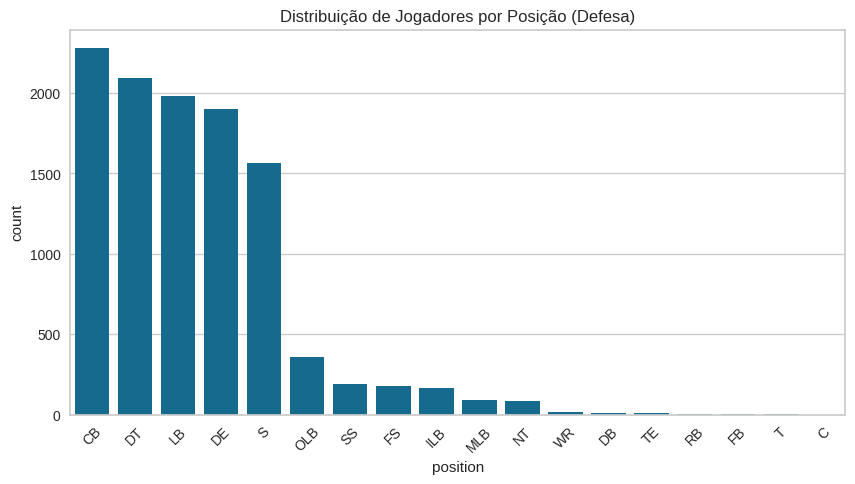

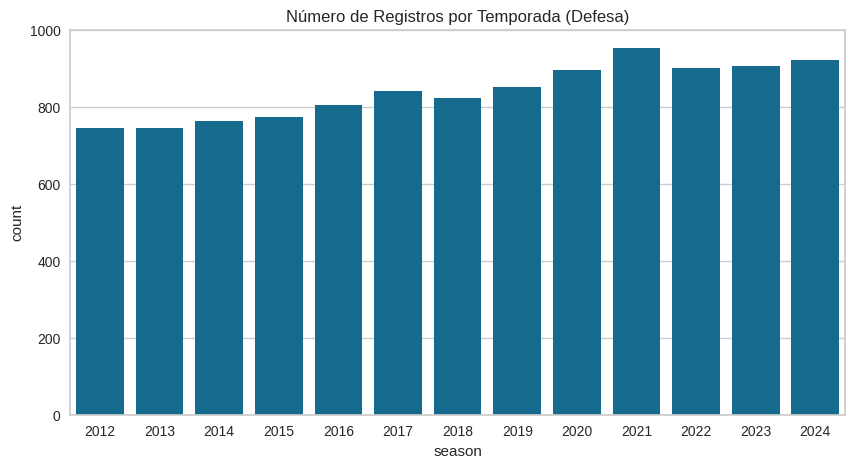

In [510]:
# Gráfico para verificar a distribuição dos jogadores por posição
plt.figure(figsize=(10,5))
sns.countplot(data=df_defesa_limpo, x='position', order=df_defesa_limpo['position'].value_counts().index)
plt.title('Distribuição de Jogadores por Posição (Defesa)')
plt.xticks(rotation=45)
plt.show()

# Número de registros por temporada
plt.figure(figsize=(10,5))
sns.countplot(data=df_defesa_limpo, x='season')
plt.title('Número de Registros por Temporada (Defesa)')
plt.show()

In [511]:
# Estatísticas da defesa
df_defesa_limpo.describe()[['tackles_total', 'sack', 'qb_hit', 'interception', 'fumble_forced', 'def_touchdown', 'impact_plays']]

tackles_total          sack        qb_hit  interception  fumble_forced  \
count   10939.000000  10939.000000  10939.000000  10939.000000   10939.000000   
mean       42.291251      5.756742      8.497669      1.126794       1.401225   
std        37.987574     10.372226     12.726330      2.165175       2.703147   
min         0.000000      0.000000      0.000000      0.000000       0.000000   
25%        10.000000      0.000000      1.000000      0.000000       0.000000   
50%        33.000000      0.000000      4.000000      0.000000       0.000000   
75%        64.000000      7.000000     10.000000      2.000000       2.000000   
max       231.000000     92.000000    112.000000     22.000000      33.000000   

       def_touchdown  impact_plays  
count   10939.000000  10939.000000  
mean        0.161075      8.493555  
std         0.620856     12.608796  
min         0.000000      0.000000  
25%         0.000000      0.000000  
50%         0.000000      4.000000  
75%         0.000000     11.000000  
max        10.000000    111.000000

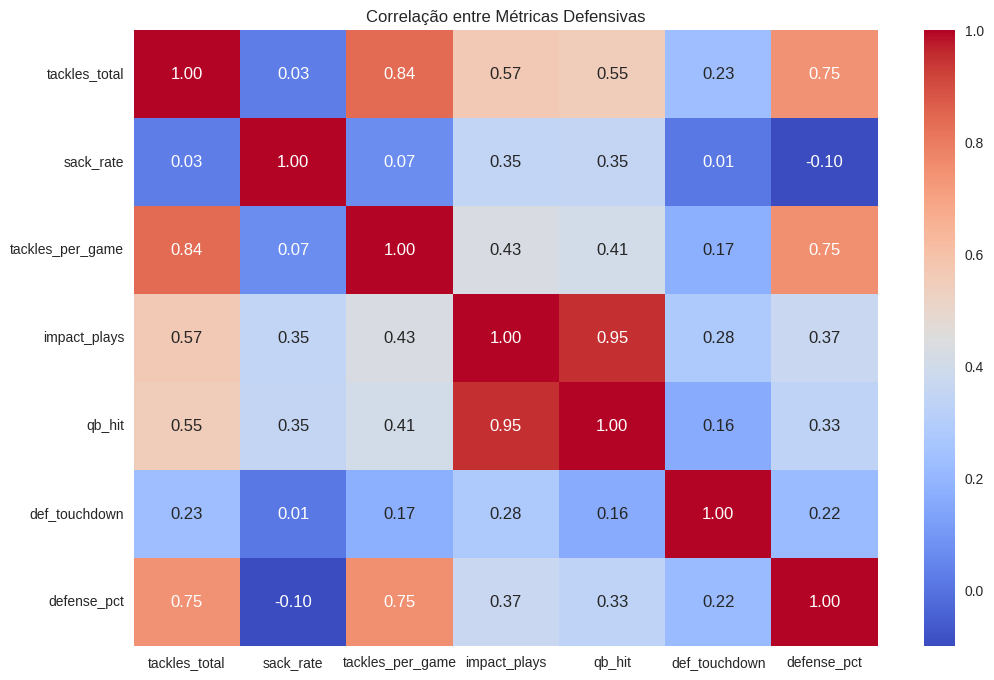

In [512]:
# Correlação entre variáveis
corr_cols = ['tackles_total', 'sack_rate', 'tackles_per_game', 'impact_plays',
             'qb_hit',  'def_touchdown', 'defense_pct']
plt.figure(figsize=(12, 8))
sns.heatmap(df_defesa_limpo[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Métricas Defensivas')
plt.show()

####**CBs (DBs)**

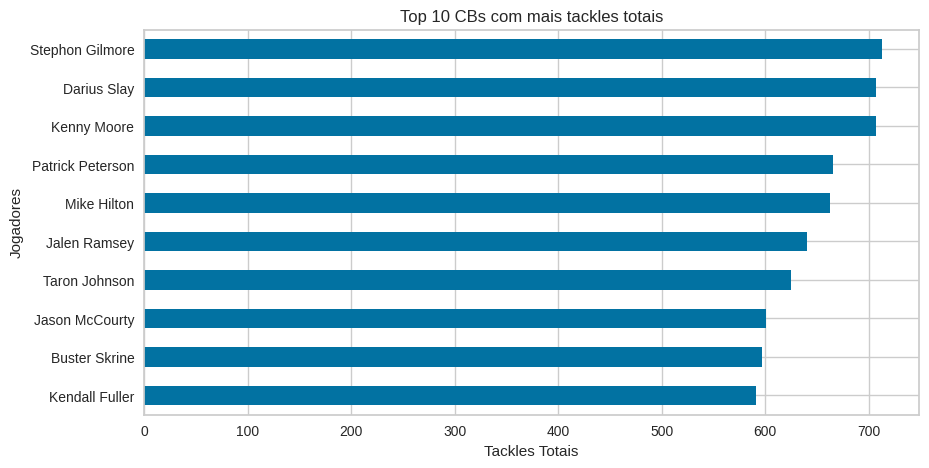

In [513]:
# Top CBs com mais tackles totais
cbs = df_defesa_limpo[(df_defesa_limpo['position'] == 'CB') | (df_defesa_limpo['position'] == 'DB')]
top_cbs_tackles = cbs.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_cbs_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

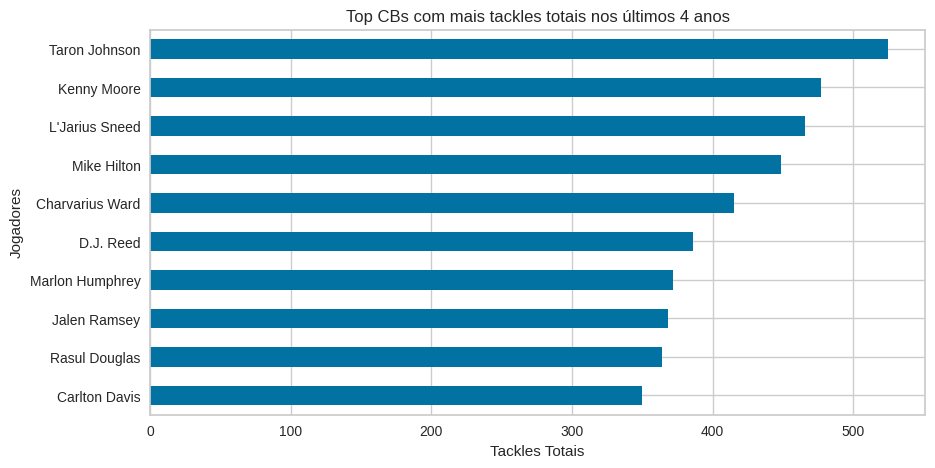

In [514]:
# Top CBs com mais tackles totais nos últimos 4 anos
cbs_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'CB') | (df_defesa_limpo['position'] == 'DB')) & (df_defesa_limpo['season'] >= 2020)]
top_cbs_tackles_recente = cbs_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_cbs_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

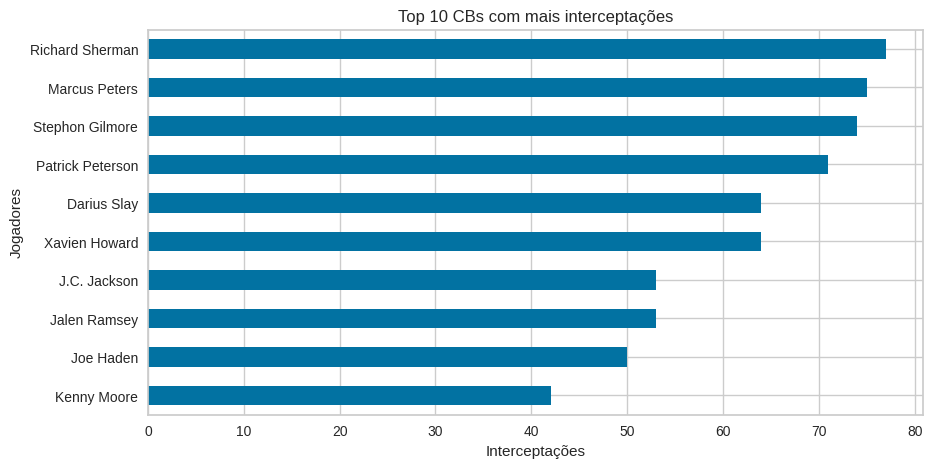

In [515]:
# Top CBs com mais interceptações
top_cbs_int = cbs.groupby('player_name')['interception'].sum().nlargest(10)
top_cbs_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

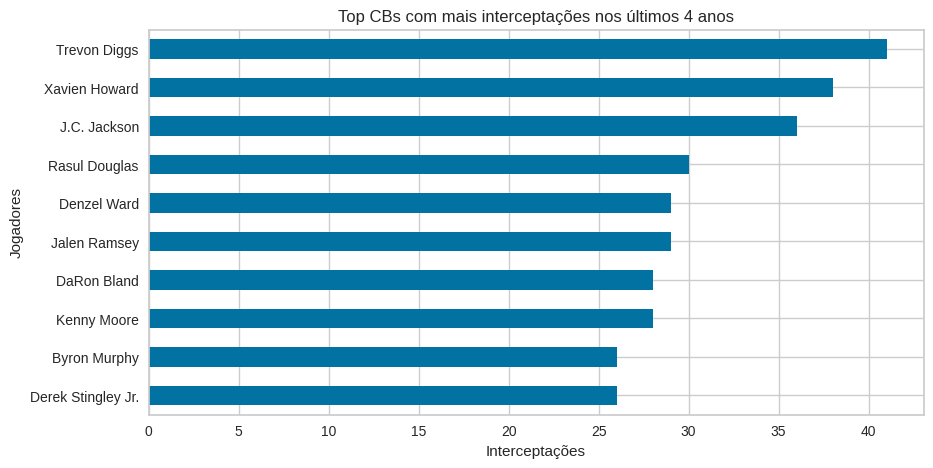

In [516]:
# Top CBs com mais interceptações nos últimos 4 anos
top_cbs_int_recente = cbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_cbs_int_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

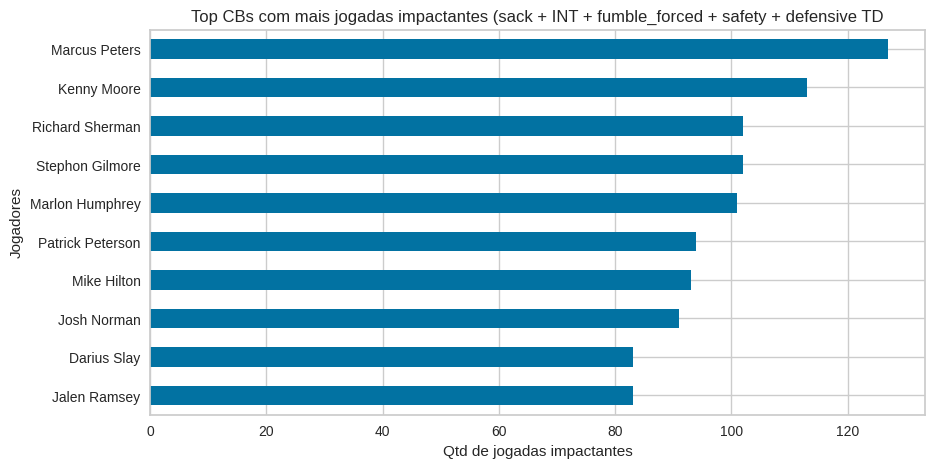

In [517]:
# Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_cbs_impact = cbs.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_cbs_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

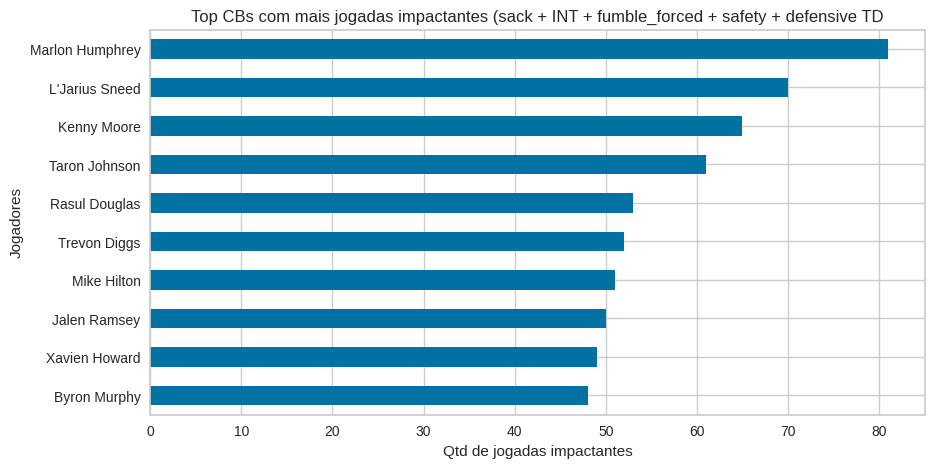

In [518]:
# Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_cbs_impact_recente = cbs_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_cbs_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

####**Safeties(FS, SS, S)**

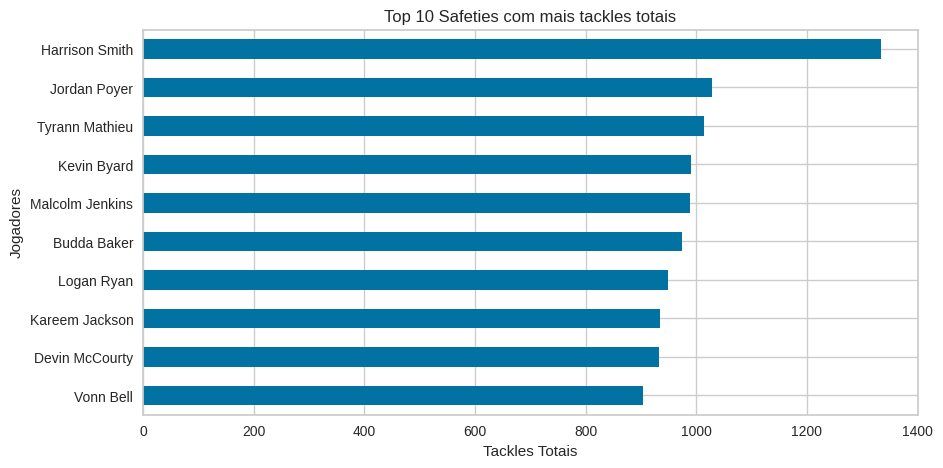

In [519]:
# Top Safeties com mais tackles totais
safeties = df_defesa_limpo[(df_defesa_limpo['position'] == 'FS') | (df_defesa_limpo['position'] == 'SS') | (df_defesa_limpo['position'] == 'S')]
top_safeties_tackles = safeties.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_safeties_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Safeties com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

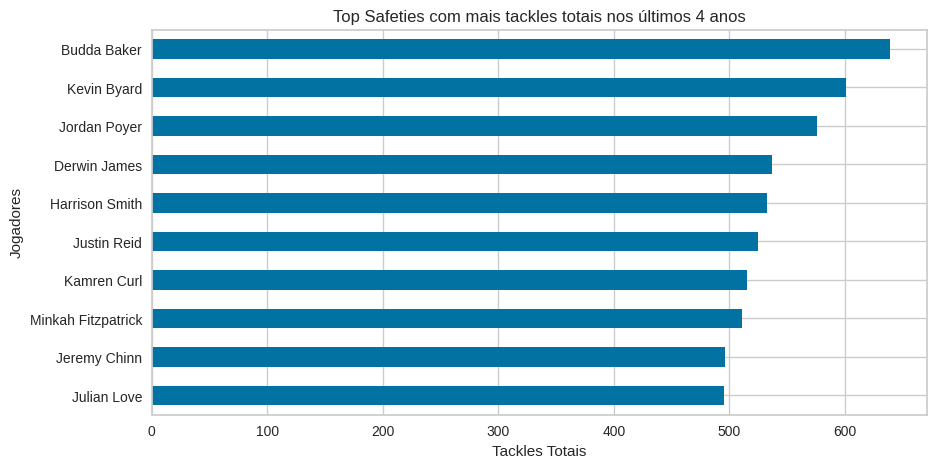

In [520]:
# Top CBs com mais tackles totais nos últimos 4 anos
safeties_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'FS') | (df_defesa_limpo['position'] == 'SS') | (df_defesa_limpo['position'] == 'S'))
& (df_defesa_limpo['season'] >= 2020)]
top_safeties_tackles_recente = safeties_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_safeties_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Safeties com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

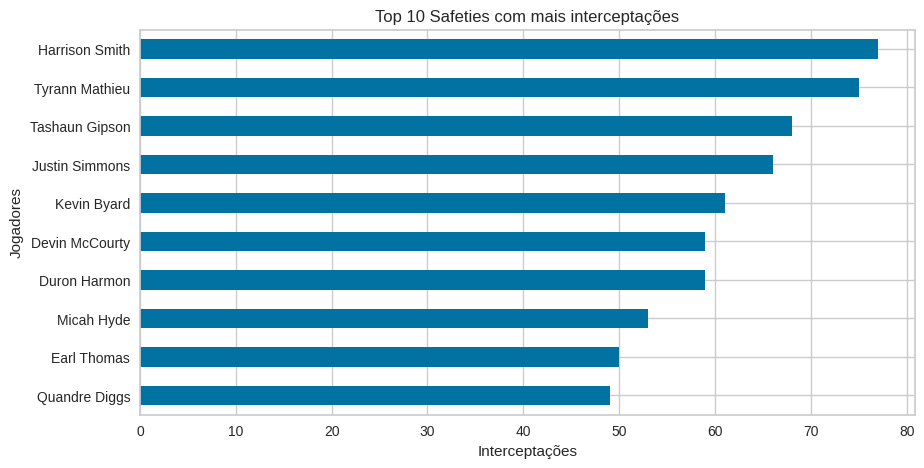

In [521]:
# Top Safeties com mais interceptações
top_safeties_int = safeties.groupby('player_name')['interception'].sum().nlargest(10)
top_safeties_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Safeties com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

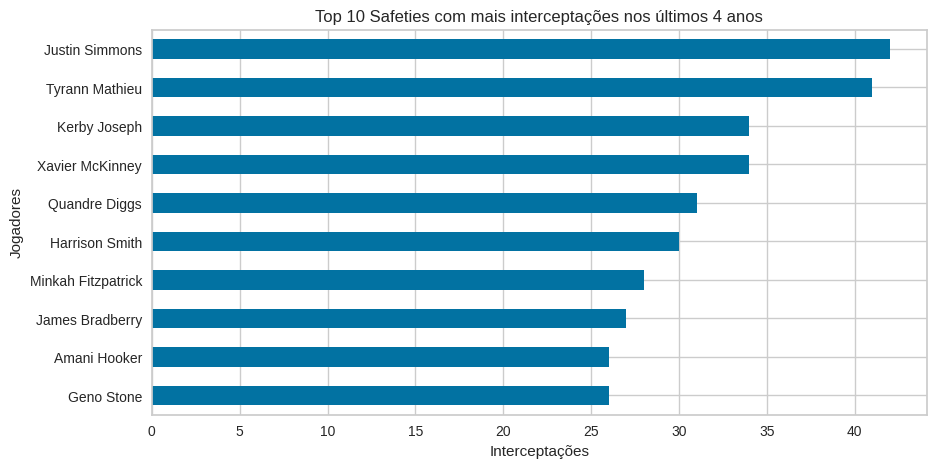

In [522]:
# Top Safeties com mais interceptações nos últimos 4 anos
top_safeties_int_recentes = safeties_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_safeties_int_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Safeties com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

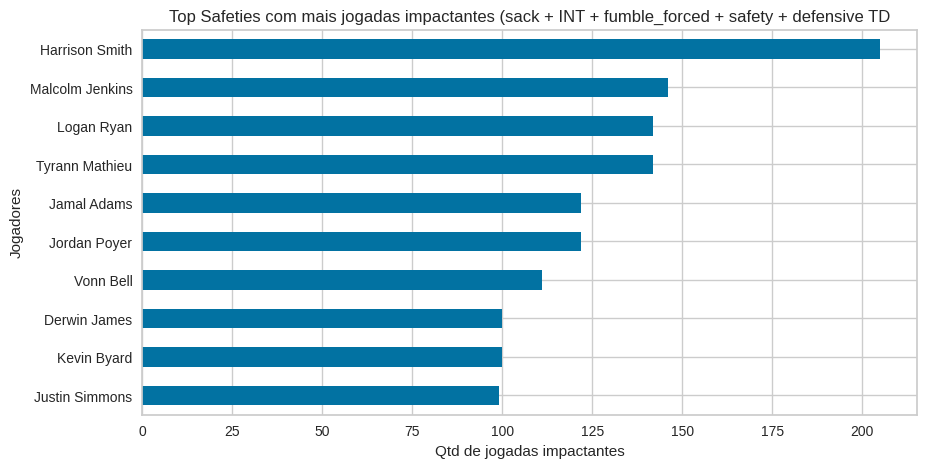

In [523]:
# Top safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_safeties_impact = safeties.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_safeties_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

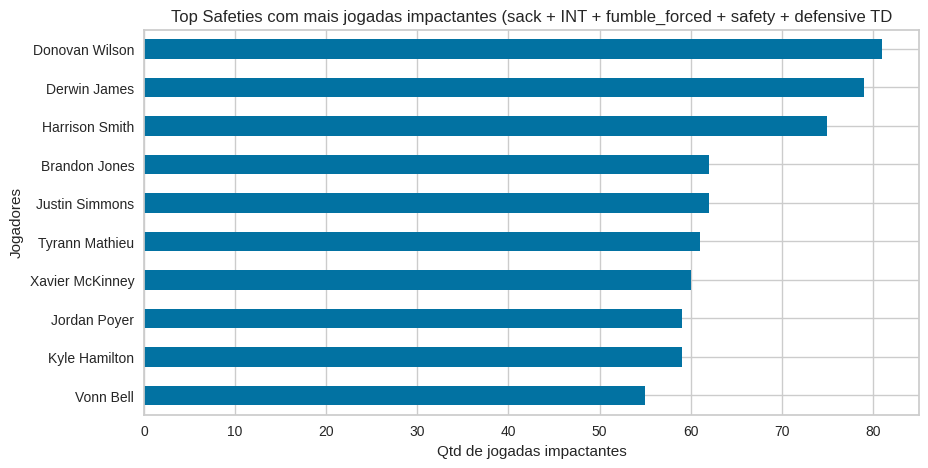

In [524]:
# Top Safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_safeties_impact_recente = safeties_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_safeties_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

####**Linebackers (ILB, OLB, MLB, LB)**

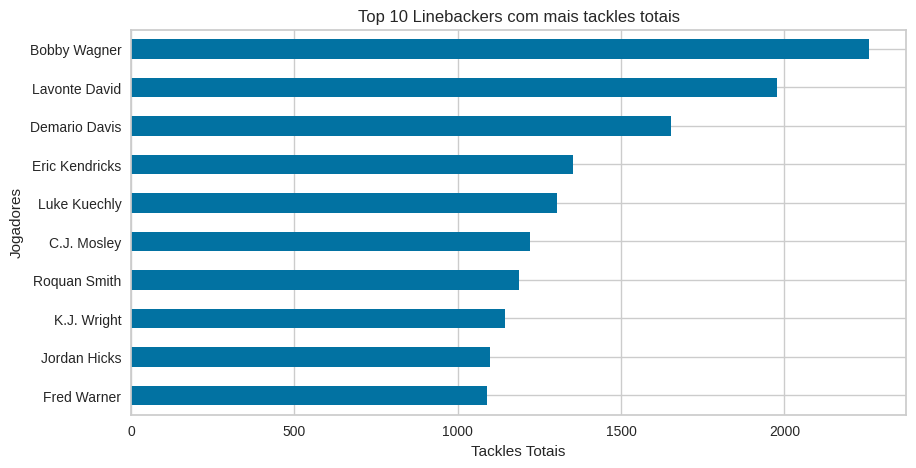

In [525]:
# Top Linebackers com mais tackles totais
lbs = df_defesa_limpo[(df_defesa_limpo['position'] == 'ILB') | (df_defesa_limpo['position'] == 'OLB') | (df_defesa_limpo['position'] == 'MLB') |
                      (df_defesa_limpo['position'] == 'LB')]
top_lbs_tackles = lbs.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_lbs_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

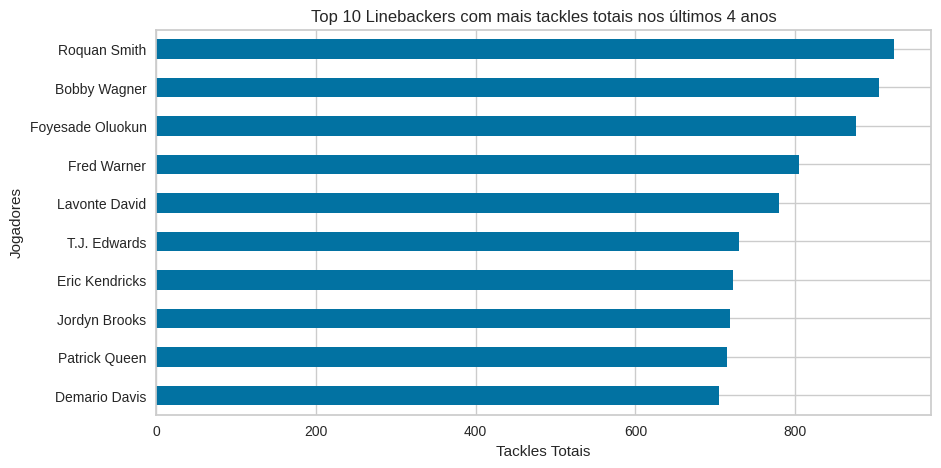

In [526]:
# Top Linebackers com mais tackles totais nos últimos 4 anos
lbs_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'ILB') | (df_defesa_limpo['position'] == 'OLB') | (df_defesa_limpo['position'] == 'MLB') |
                      (df_defesa_limpo['position'] == 'LB'))
& (df_defesa_limpo['season'] >= 2020)]
top_lbs_tackles_recente = lbs_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_lbs_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

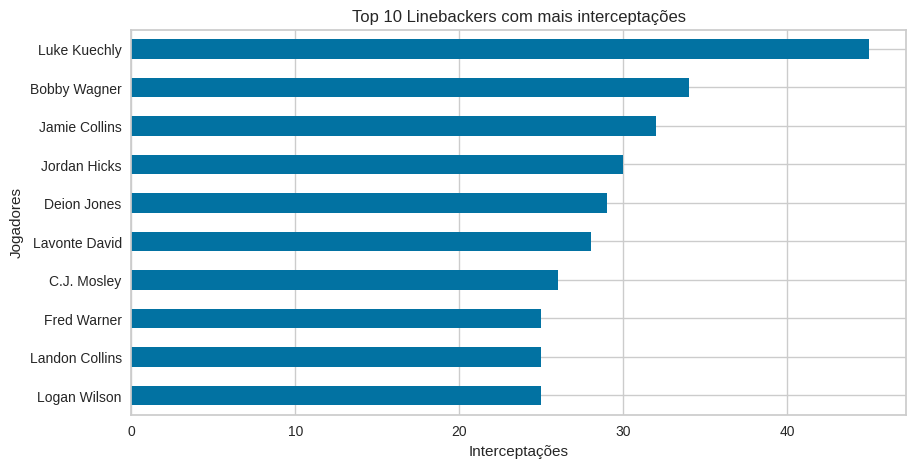

In [527]:
# Top Linebackers com mais interceptações
top_lbs_int = lbs.groupby('player_name')['interception'].sum().nlargest(10)
top_lbs_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

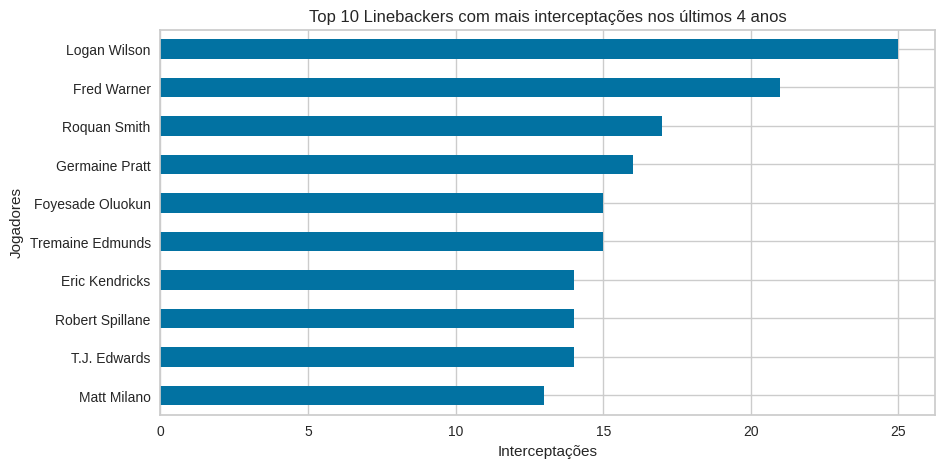

In [528]:
# Top Linebackers com mais interceptações nos últimos 4 anos
top_lbs_int_recentes = lbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_lbs_int_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

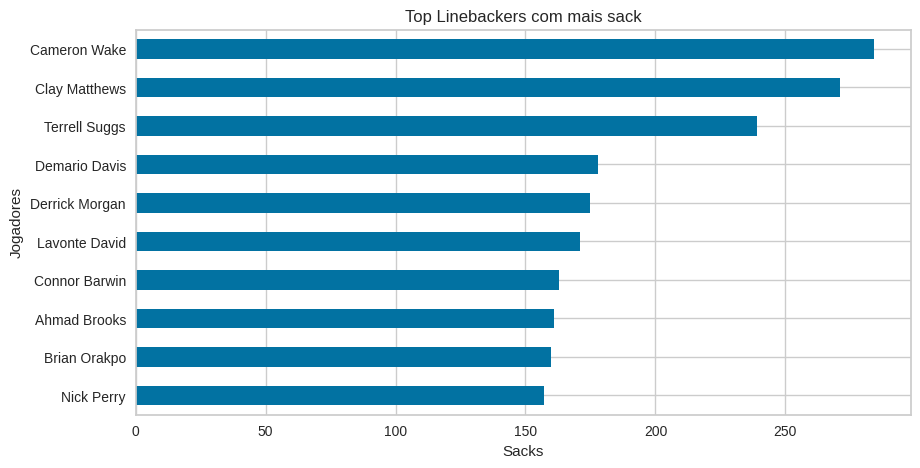

In [529]:
# Top Linebackers com mais sacks
top_lbs_sack = lbs.groupby('player_name')['sack'].sum().nlargest(10)
top_lbs_sack.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais sack')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

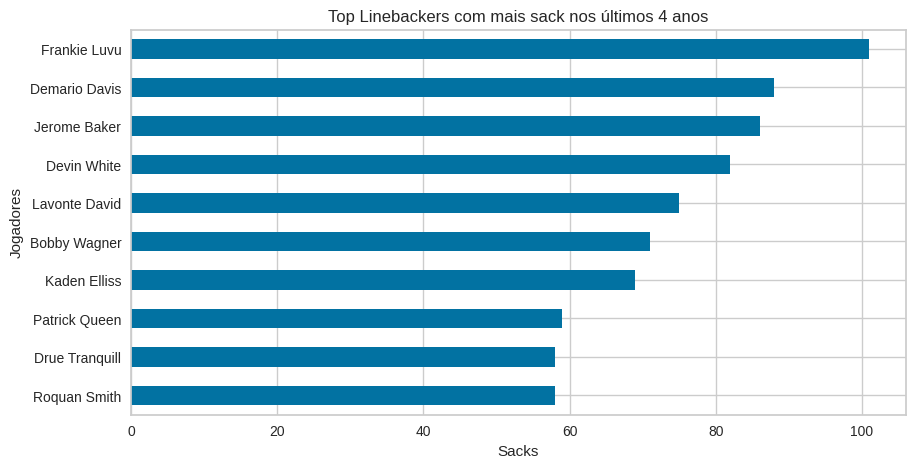

In [530]:
# Top Linebackers com mais sacks nos últimos 4 anos
top_lbs_sack_recente = lbs_recentes.groupby('player_name')['sack'].sum().nlargest(10)
top_lbs_sack_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais sack nos últimos 4 anos')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

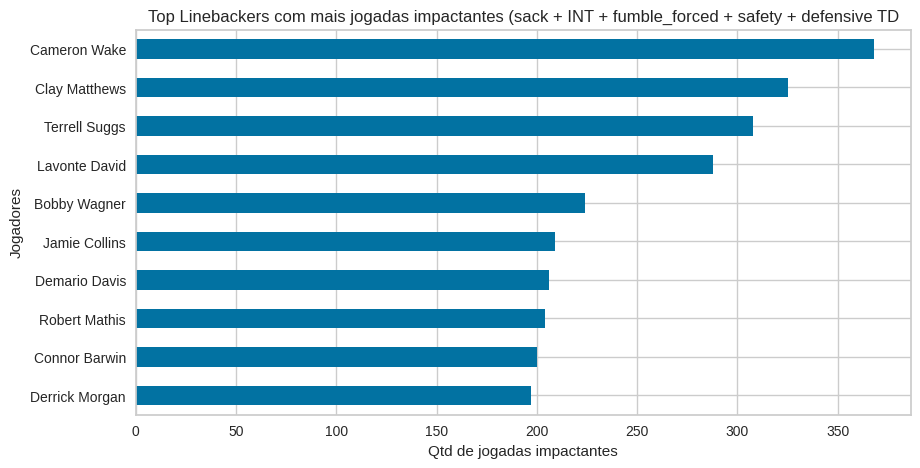

In [531]:
# Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_lbs_impact = lbs.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_lbs_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

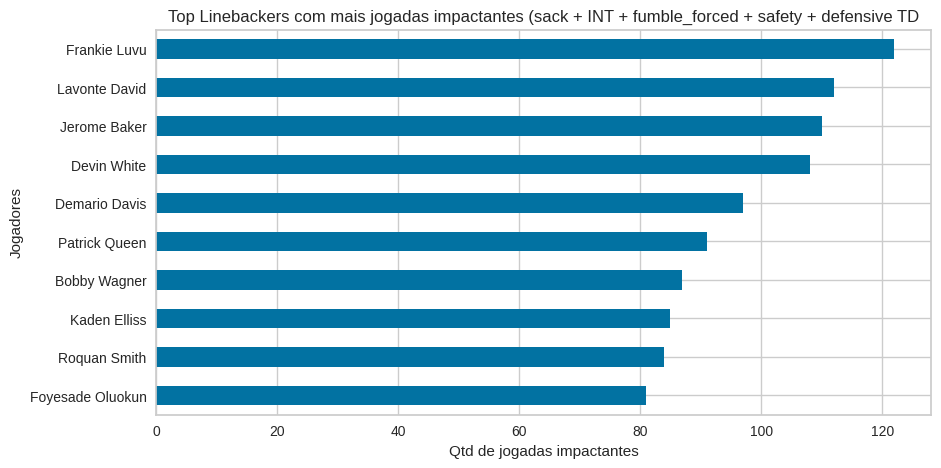

In [532]:
# Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_lbs_impact_recente = lbs_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_lbs_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

####**Defensives Lineman (DE, NT, DT e T)**

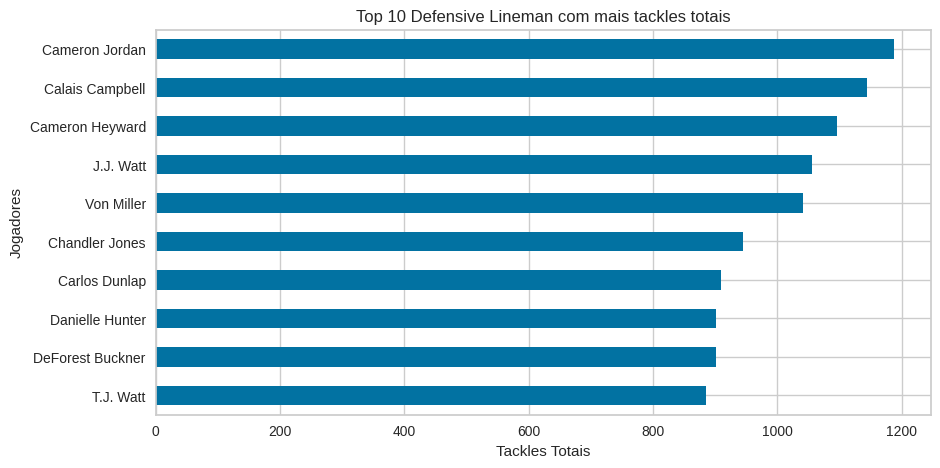

In [533]:
# Top Defensives Lineman com mais tackles totais
dl = df_defesa_limpo[(df_defesa_limpo['position'] == 'DE') | (df_defesa_limpo['position'] == 'NT') | (df_defesa_limpo['position'] == 'DT') |
                      (df_defesa_limpo['position'] == 'T')]
top_dl_tackles = dl.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_dl_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Defensive Lineman com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

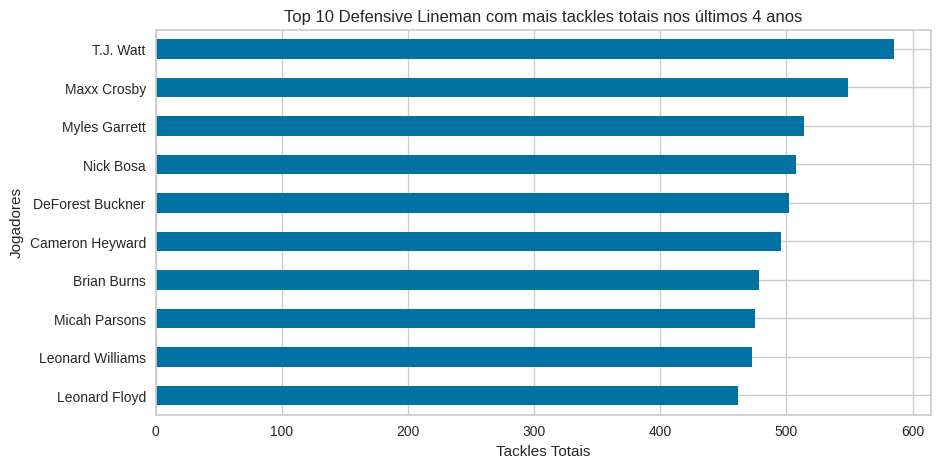

In [534]:
# Top Defensives Lineman com mais tackles totais nos últimos 4 anos
dl_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'DE') | (df_defesa_limpo['position'] == 'NT') | (df_defesa_limpo['position'] == 'DT') |
                      (df_defesa_limpo['position'] == 'T'))
& (df_defesa_limpo['season'] >= 2020)]
top_dl_tackles_recente = dl_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_dl_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Defensive Lineman com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

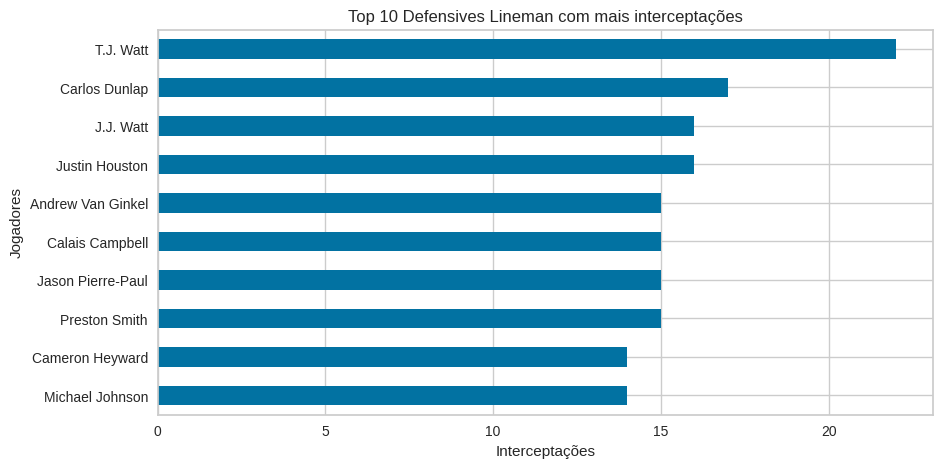

In [535]:
# Top Defensives Lineman com mais interceptações
top_dl_int = dl.groupby('player_name')['interception'].sum().nlargest(10)
top_dl_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Defensives Lineman com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

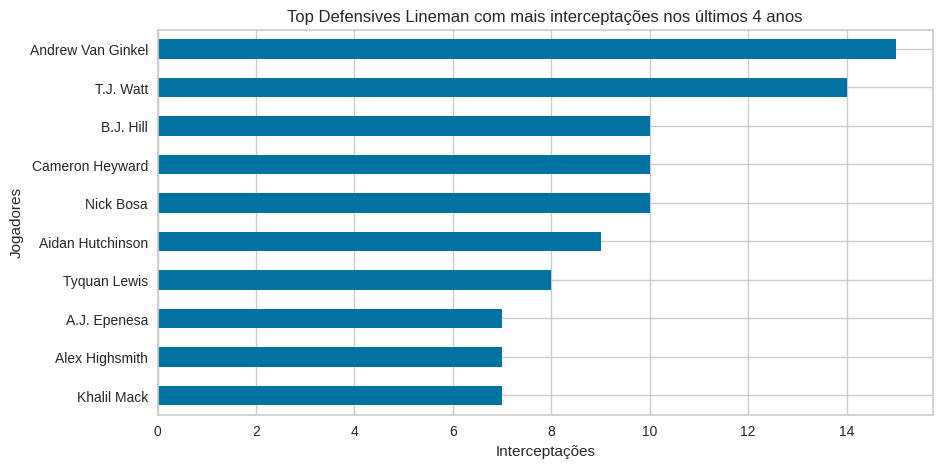

In [536]:
# Top Defensives Lineman com mais interceptações nos últimos 4 anos
top_dl_int_recentes = dl_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_dl_int_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

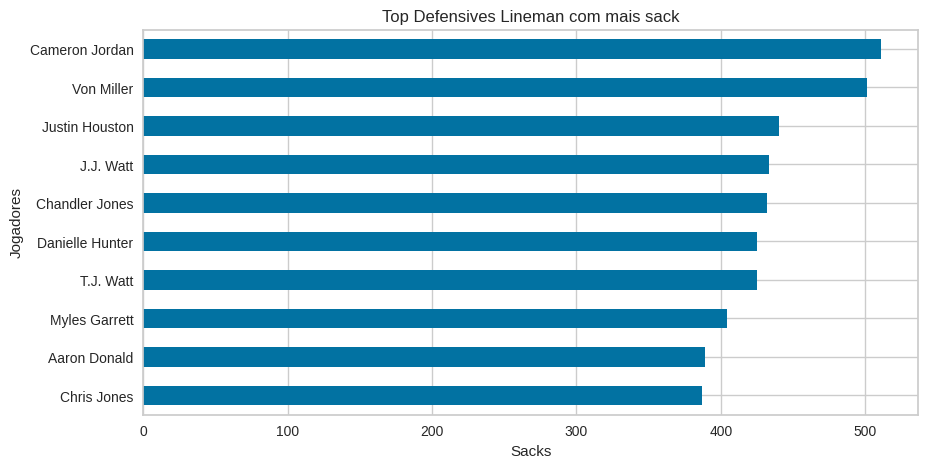

In [537]:
# Top Defensives Lineman com mais sacks
top_dl_sack = dl.groupby('player_name')['sack'].sum().nlargest(10)
top_dl_sack.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais sack')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

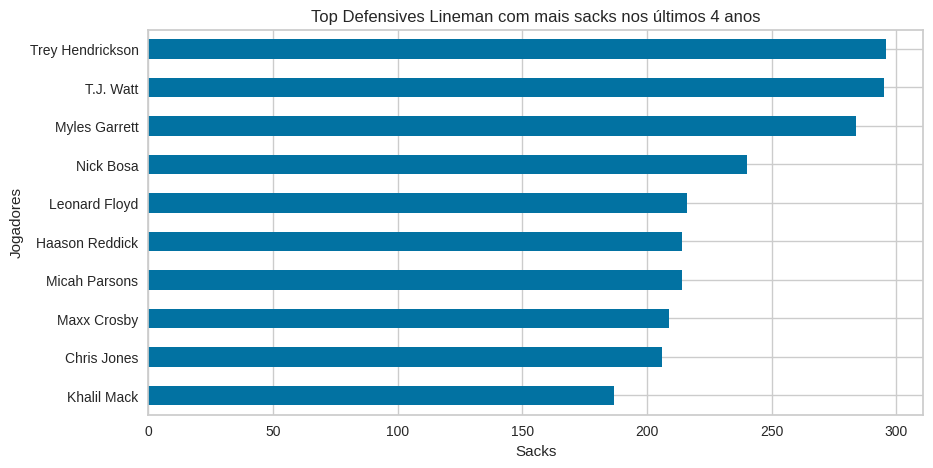

In [538]:
# Top Defensives Lineman com mais sacks nos últimos 4 anos
top_dl_sack_recente = dl_recentes.groupby('player_name')['sack'].sum().nlargest(10)
top_dl_sack_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais sacks nos últimos 4 anos')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

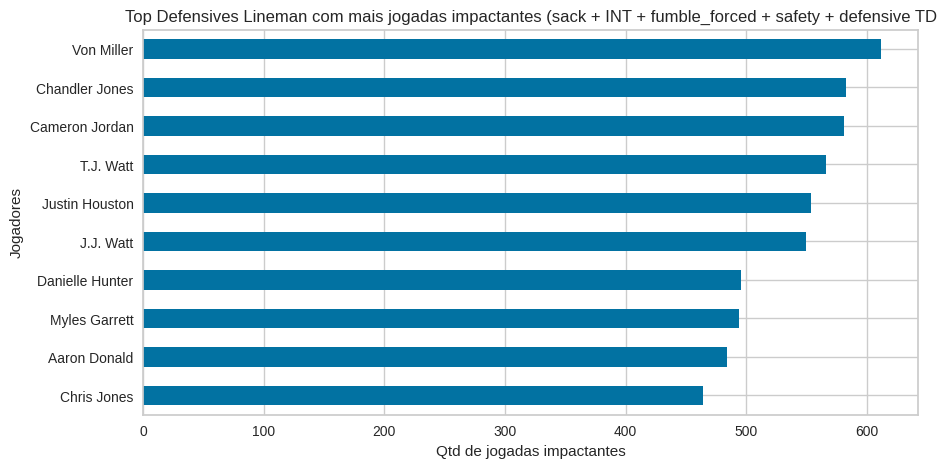

In [539]:
# Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_dl_impact = dl.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_dl_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

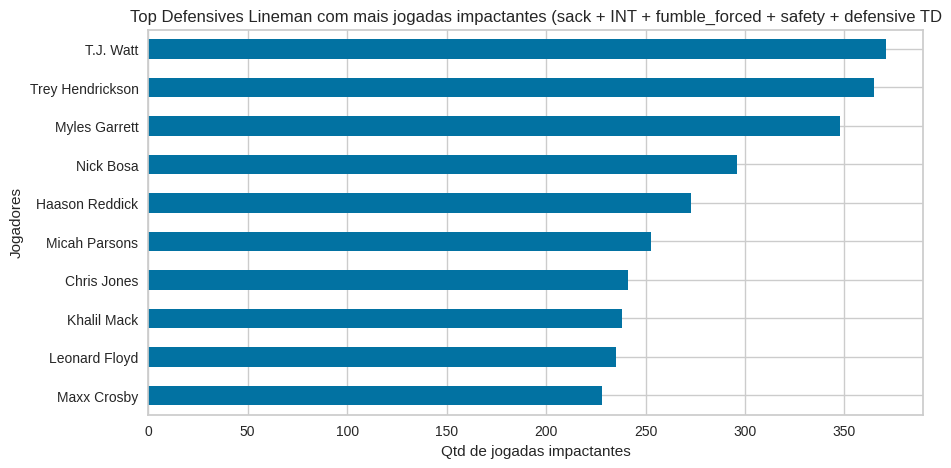

In [540]:
# Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_dl_impact_recente = dl_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_dl_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

Tackles por jogo: 2012 → 2024
Tackles por jogo na primeira temporada: 2790
Tackles por jogo na última temporada: 3512
Variação percentual entre primeira e última: 25.9%


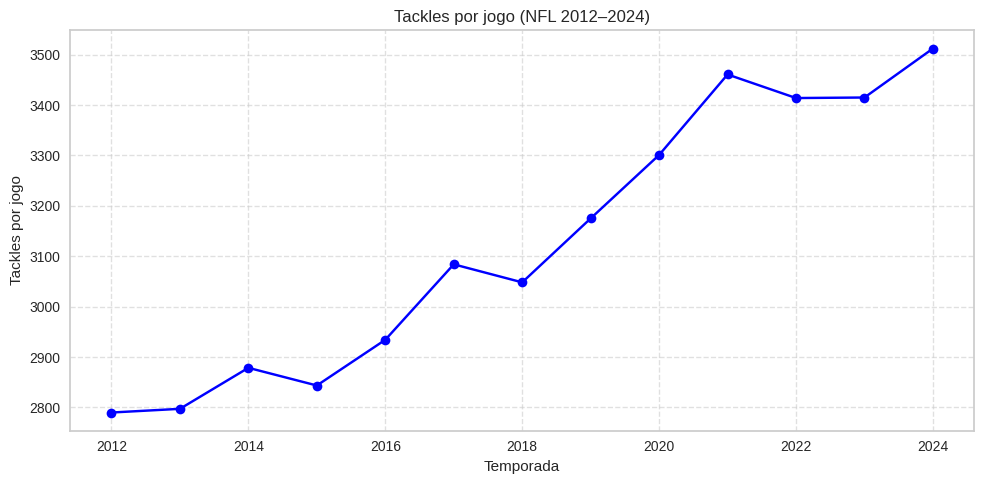

In [541]:
# Agrupando tackles por jogo por temporada
tackle_per_game_por_temporada = (
    df_defesa_limpo
    .groupby('season')['tackles_per_game']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = tackle_per_game_por_temporada['tackles_per_game'].iloc[0], tackle_per_game_por_temporada['tackles_per_game'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Tackles por jogo: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Tackles por jogo na primeira temporada: {primeira:.0f}")
print(f"Tackles por jogo na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(tackle_per_game_por_temporada['season'], tackle_per_game_por_temporada['tackles_per_game'], marker='o', color='blue')
plt.title('Tackles por jogo (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Tackles por jogo')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Sack: 2012 → 2024
Sack na primeira temporada: 4317.00
Sacks na última temporada: 5421.00
Variação percentual entre primeira e última: 25.6%


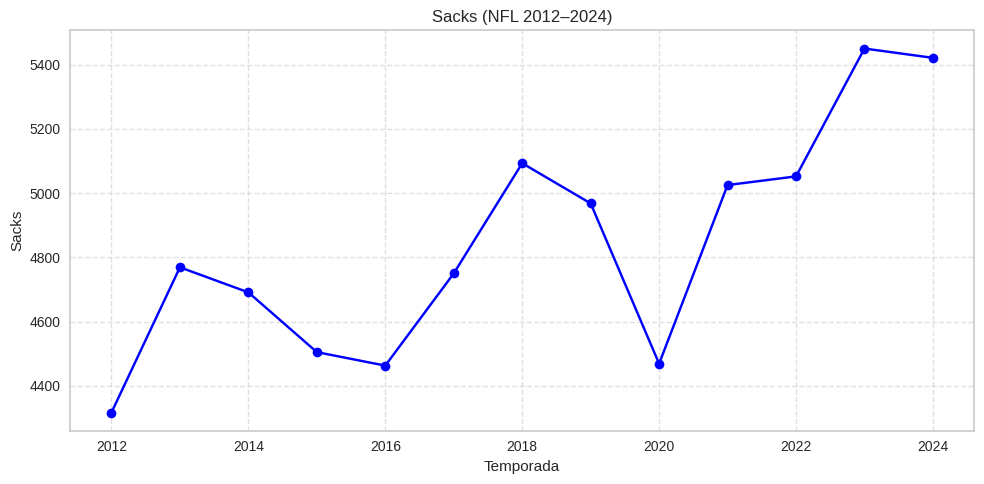

In [542]:
# Agrupando Sacks por temporada
sack_por_temporada = (
    df_defesa_limpo
    .groupby('season')['sack']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = sack_por_temporada['sack'].iloc[0], sack_por_temporada['sack'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Sack: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Sack na primeira temporada: {primeira:.2f}")
print(f"Sacks na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(sack_por_temporada['season'], sack_por_temporada['sack'], marker='o', color='blue')
plt.title('Sacks (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Sacks')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

QB HIT: 2012 → 2024
QB HIT na primeira temporada: 6018.00
QB HIT na última temporada: 7845.00
Variação percentual entre primeira e última: 30.4%


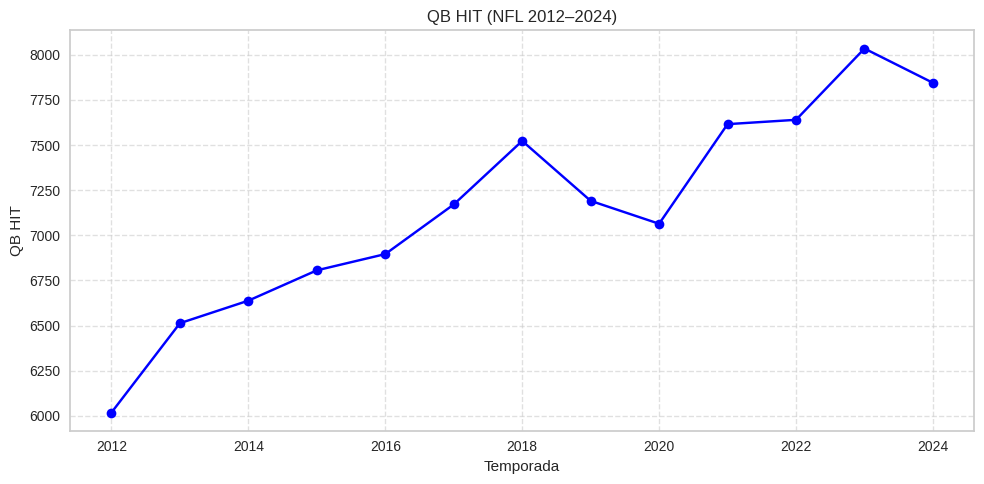

In [543]:
# Agrupando QB hit por temporada
qb_hit_por_temporada = (
    df_defesa_limpo
    .groupby('season')['qb_hit']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = qb_hit_por_temporada['qb_hit'].iloc[0], qb_hit_por_temporada['qb_hit'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"QB HIT: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"QB HIT na primeira temporada: {primeira:.2f}")
print(f"QB HIT na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(qb_hit_por_temporada['season'], qb_hit_por_temporada['qb_hit'], marker='o', color='blue')
plt.title('QB HIT (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('QB HIT')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Interceptações: 2012 → 2024
Interceptações na primeira temporada: 977.00
Interceptações na última temporada: 889.00
Variação percentual entre primeira e última: -9.0%


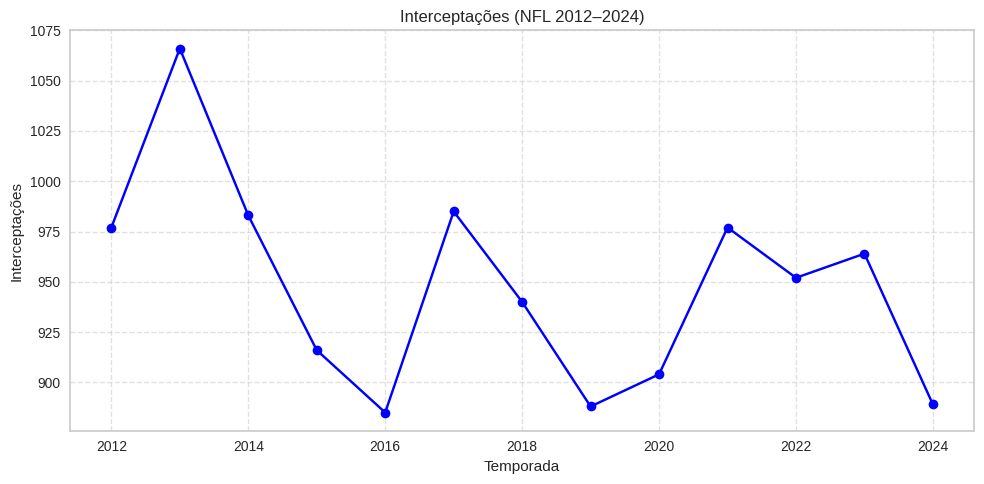

In [544]:
# Agrupando interceptações por temporada
int_por_temporada = (
    df_defesa_limpo
    .groupby('season')['interception']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = int_por_temporada['interception'].iloc[0], int_por_temporada['interception'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Interceptações: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Interceptações na primeira temporada: {primeira:.2f}")
print(f"Interceptações na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(int_por_temporada['season'], int_por_temporada['interception'], marker='o', color='blue')
plt.title('Interceptações (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Interceptações')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Touchdown Defensivos: 2012 → 2024
Touchdown Defensivos na primeira temporada: 157.00
Touchdown Defensivos na última temporada: 114.00
Variação percentual entre primeira e última: -27.4%


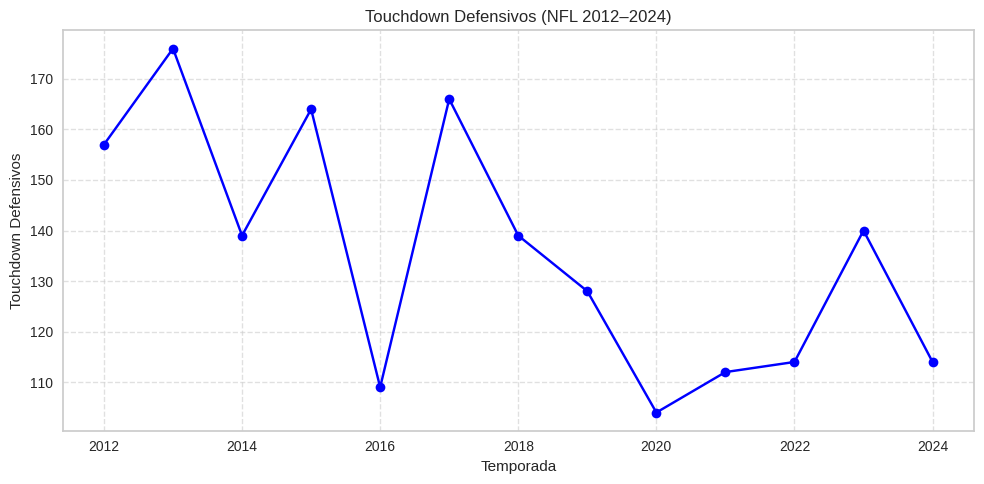

In [545]:
# Agrupando TD defensivos por temporada
td_defensivo_por_temporada = (
    df_defesa_limpo
    .groupby('season')['def_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_defensivo_por_temporada['def_touchdown'].iloc[0], td_defensivo_por_temporada['def_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Touchdown Defensivos: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Touchdown Defensivos na primeira temporada: {primeira:.2f}")
print(f"Touchdown Defensivos na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_defensivo_por_temporada['season'], td_defensivo_por_temporada['def_touchdown'], marker='o', color='blue')
plt.title('Touchdown Defensivos (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Touchdown Defensivos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jogadas Impactantes: 2012 → 2024
Jogadas Impactantes na primeira temporada: 6685.00
Jogadas Impactantes na última temporada: 7792.00
Variação percentual entre primeira e última: 16.6%


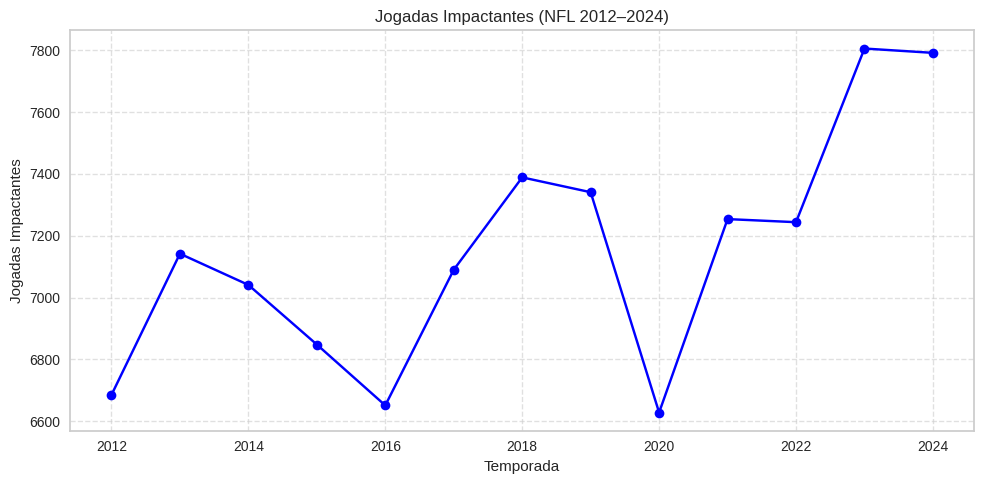

In [546]:
# Agrupando Jogadas Impactantes por temporada
impact_por_temporada = (
    df_defesa_limpo
    .groupby('season')['impact_plays']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = impact_por_temporada['impact_plays'].iloc[0], impact_por_temporada['impact_plays'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jogadas Impactantes: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Jogadas Impactantes na primeira temporada: {primeira:.2f}")
print(f"Jogadas Impactantes na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(impact_por_temporada['season'], impact_por_temporada['impact_plays'], marker='o', color='blue')
plt.title('Jogadas Impactantes (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jogadas Impactantes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

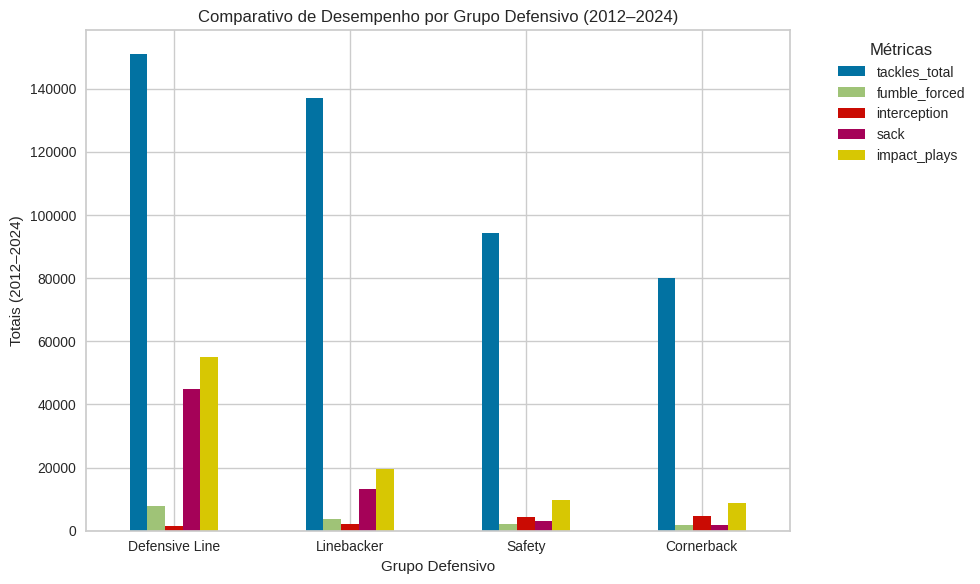

In [547]:
df_defesa_agrupada = df_defesa_limpo.copy()

# Dicionário para agrupar posições semelhantes
map_posicoes = {
    'FS': 'Safety', 'SS': 'Safety', 'S': 'Safety',
    'CB': 'Cornerback', 'DB': 'Cornerback',
    'ILB': 'Linebacker', 'OLB': 'Linebacker', 'MLB': 'Linebacker', 'LB': 'Linebacker',
    'DE': 'Defensive Line', 'NT': 'Defensive Line', 'DT': 'Defensive Line', 'T': 'Defensive Line'
}

# Criar uma nova coluna com o grupo de posição
df_defesa_agrupada['pos_agrupada'] = df_defesa_agrupada['position'].map(map_posicoes)

# Remover linhas com posições não defensivas (sem grupo)
df_defesa_grupos = df_defesa_agrupada.dropna(subset=['pos_agrupada'])

# Agrupar por grupo de posição e somar métricas relevantes
pos_agrupada_status = (
    df_defesa_grupos
    .groupby('pos_agrupada')[['tackles_total', 'fumble_forced', 'interception', 'sack', 'impact_plays']]
    .sum()
    .sort_values('impact_plays', ascending=False)
)

# Plotar gráfico
pos_agrupada_status.plot(
    kind='bar',
    figsize=(10,6),
    title='Comparativo de Desempenho por Grupo Defensivo (2012–2024)',
    rot=0
)

plt.xlabel('Grupo Defensivo')
plt.ylabel('Totais (2012–2024)')
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

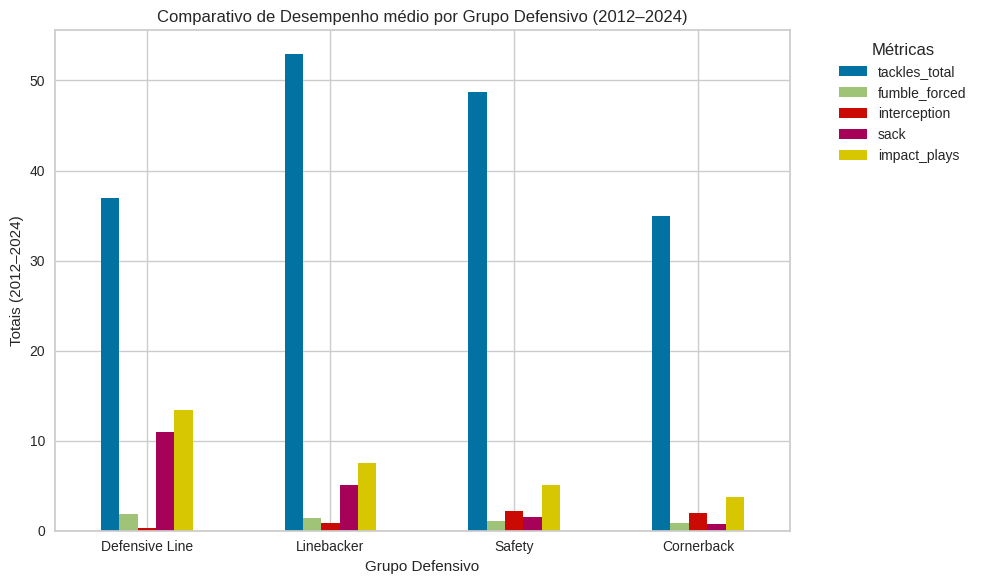

In [548]:
df_defesa_agrupada = df_defesa_limpo.copy()

# Dicionário para agrupar posições semelhantes
map_posicoes = {
    'FS': 'Safety', 'SS': 'Safety', 'S': 'Safety',
    'CB': 'Cornerback', 'DB': 'Cornerback',
    'ILB': 'Linebacker', 'OLB': 'Linebacker', 'MLB': 'Linebacker', 'LB': 'Linebacker',
    'DE': 'Defensive Line', 'NT': 'Defensive Line', 'DT': 'Defensive Line', 'T': 'Defensive Line'
}

# Criar uma nova coluna com o grupo de posição
df_defesa_agrupada['pos_agrupada'] = df_defesa_agrupada['position'].map(map_posicoes)

# Remover linhas com posições não defensivas (sem grupo)
df_defesa_grupos = df_defesa_agrupada.dropna(subset=['pos_agrupada'])

# Agrupar por grupo de posição e somar métricas relevantes
pos_agrupada_status = (
    df_defesa_grupos
    .groupby('pos_agrupada')[['tackles_total', 'fumble_forced', 'interception', 'sack', 'impact_plays']]
    .mean()
    .sort_values('impact_plays', ascending=False)
)

# Plotar gráfico
pos_agrupada_status.plot(
    kind='bar',
    figsize=(10,6),
    title='Comparativo de Desempenho médio por Grupo Defensivo (2012–2024)',
    rot=0
)

plt.xlabel('Grupo Defensivo')
plt.ylabel('Totais (2012–2024)')
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**Ataque**

In [549]:
media_ataque = (
    df_ataque_limpo
    .groupby('season')[['pass_attempts', 'complete_pass', 'passing_yards', 'pass_touchdown', 'interception',
    'passer_rating', 'comp_pct', 'ypa', 'rush_attempts', 'rushing_yards', 'rush_touchdown',
    'fumble', 'fumble_lost', 'ypc', 'targets', 'receptions', 'receiving_yards',
    'receiving_touchdown', 'yards_after_catch', 'yptarget', 'ypr', 'total_yards',
    'total_tds', 'fantasy_points_ppr', 'fantasy_points_standard', 'season_ypg',
    'season_yptouch', 'season_average_ppr_ppg', 'offense_snaps', 'offense_pct',
    'yards_per_pass_attempt', 'yards_per_carry', 'yards_per_reception',
    'catch_rate', 'touches', 'yards_per_touch']]
    .mean()
    .reset_index()
)

# Exibir as 5 primeiras linhas
media_ataque.head()



season  pass_attempts  complete_pass  passing_yards  pass_touchdown  \
0    2012      40.732673      25.460396     296.386139        3.376238   
1    2013      37.924939      24.024213     279.648910        3.326877   
2    2014      35.034115      22.556503     258.172708        3.127932   
3    2015      38.073333      24.557778     284.031111        3.382222   
4    2016      34.562130      22.325444     254.021696        2.901381   

   interception  passer_rating  comp_pct       ypa  rush_attempts  ...  \
0      2.014851      11.419703  0.106094  1.569183      29.076733  ...   
1      2.070218      14.826538  0.106203  1.346780      27.881356  ...   
2      1.727079       8.774606  0.103333  1.292559      24.159915  ...   
3      1.768889      12.624111  0.101573  1.198244      24.302222  ...   
4      1.516765      11.331499  0.094625  1.196469      22.704142  ...   

   season_yptouch  season_average_ppr_ppg  offense_snaps  offense_pct  \
0        9.106411                8.870767     392.925743     0.561184   
1        9.077966                8.415593     383.702179     0.557074   
2        8.955096                8.290341     348.910448     0.547732   
3        9.274733                8.532267     368.315556     0.550887   
4        8.785878                7.998245     334.220907     0.516303   

   yards_per_pass_attempt  yards_per_carry  yards_per_reception  catch_rate  \
0                1.569161         2.580245             8.935442    0.553398   
1                1.346708         2.501310             8.830591    0.534468   
2                1.292635         2.213235             8.642082    0.547873   
3                1.198216         2.215143             9.117864    0.552171   
4                1.196508         2.371203             8.530652    0.560612   

     touches  yards_per_touch  
0  50.754950        24.159017  
1  49.682809        23.582945  
2  44.371002        20.699303  
3  45.671111        21.841072  
4  42.390533        21.679484  

[5 rows x 37 columns]

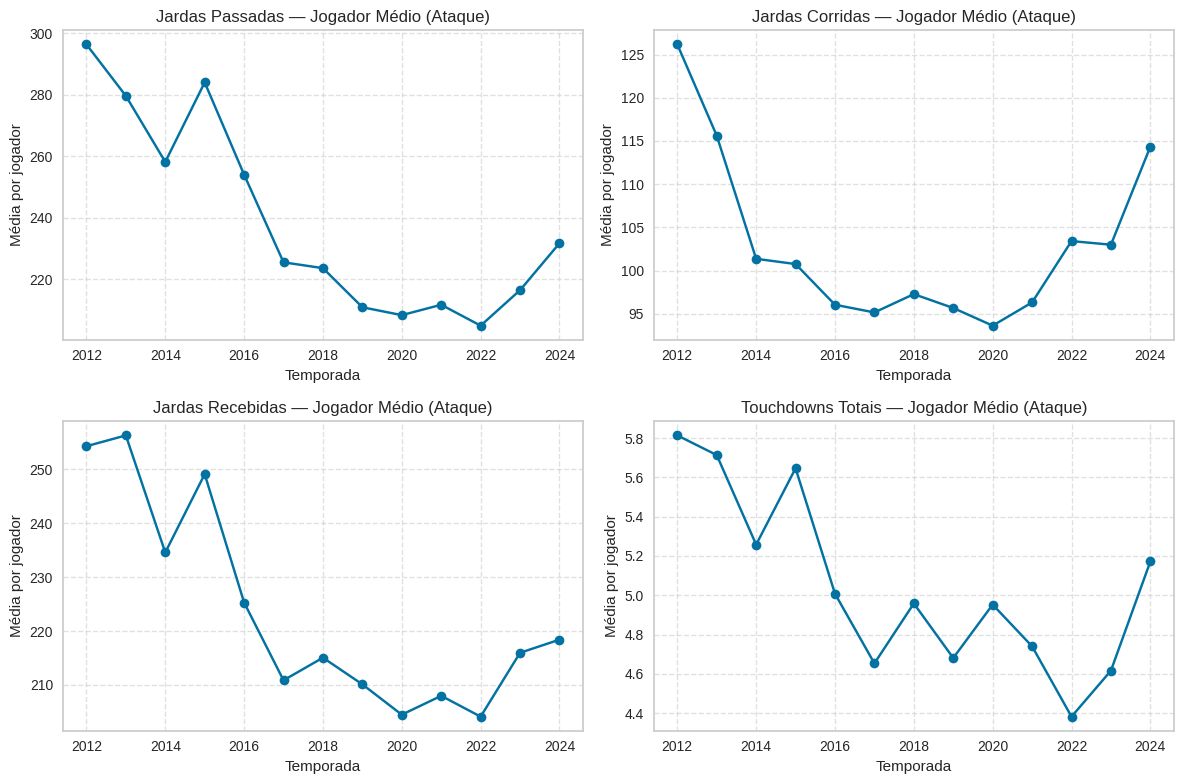

In [550]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

cols = ['passing_yards', 'rushing_yards', 'receiving_yards', 'total_tds']
titles = ['Jardas Passadas', 'Jardas Corridas', 'Jardas Recebidas', 'Touchdowns Totais']

for i, col in enumerate(cols):
    axes[i].plot(media_ataque['season'], media_ataque[col], marker='o')
    axes[i].set_title(f'{titles[i]} — Jogador Médio (Ataque)')
    axes[i].set_xlabel('Temporada')
    axes[i].set_ylabel('Média por jogador')
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()




###**Defesa**

In [551]:
media_defesa = (
    df_defesa_limpo
    .groupby('season')[['solo_tackle',
       'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit', 'interception',
       'fumble_forced', 'safety', 'def_touchdown', 'defense_snaps',
       'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard',
       'tackles_total', 'sack_rate', 'tackles_per_game', 'impact_plays']]
    .mean()
    .reset_index()
)

# Exibir as 5 primeiras linhas
media_defesa.head()

season  solo_tackle  assist_tackle  tackle_with_assist      sack    qb_hit  \
0    2012    30.403485      13.250670            4.608579  5.786863  8.067024   
1    2013    30.535475      13.560910            4.613119  6.384203  8.718876   
2    2014    29.832680      13.232680            4.278431  6.132026  8.677124   
3    2015    29.238710      12.651613            4.122581  5.812903  8.781935   
4    2016    28.762733      12.813665            4.001242  5.544099  8.566460   

   interception  fumble_forced    safety  def_touchdown  defense_snaps  \
0      1.309651       1.605898  0.048257       0.210456     443.071046   
1      1.427041       1.441767  0.072289       0.235609     447.109772   
2      1.284967       1.534641  0.070588       0.181699     433.618301   
3      1.181935       1.588387  0.041290       0.211613     427.332903   
4      1.099379       1.422360  0.060870       0.135404     423.392547   

   defense_pct  fantasy_points_ppr  fantasy_points_standard  tackles_total  \
0     0.571963                 0.0                      0.0      43.654155   
1     0.558312                 0.0                      0.0      44.096386   
2     0.557270                 0.0                      0.0      43.065359   
3     0.550113                 0.0                      0.0      41.890323   
4     0.545732                 0.0                      0.0      41.576398   

   sack_rate  tackles_per_game  impact_plays  
0   0.012735          3.739940      8.961126  
1   0.014100          3.744739      9.560910  
2   0.015206          3.762974      9.203922  
3   0.014767          3.669158      8.836129  
4   0.015085          3.645067      8.262112

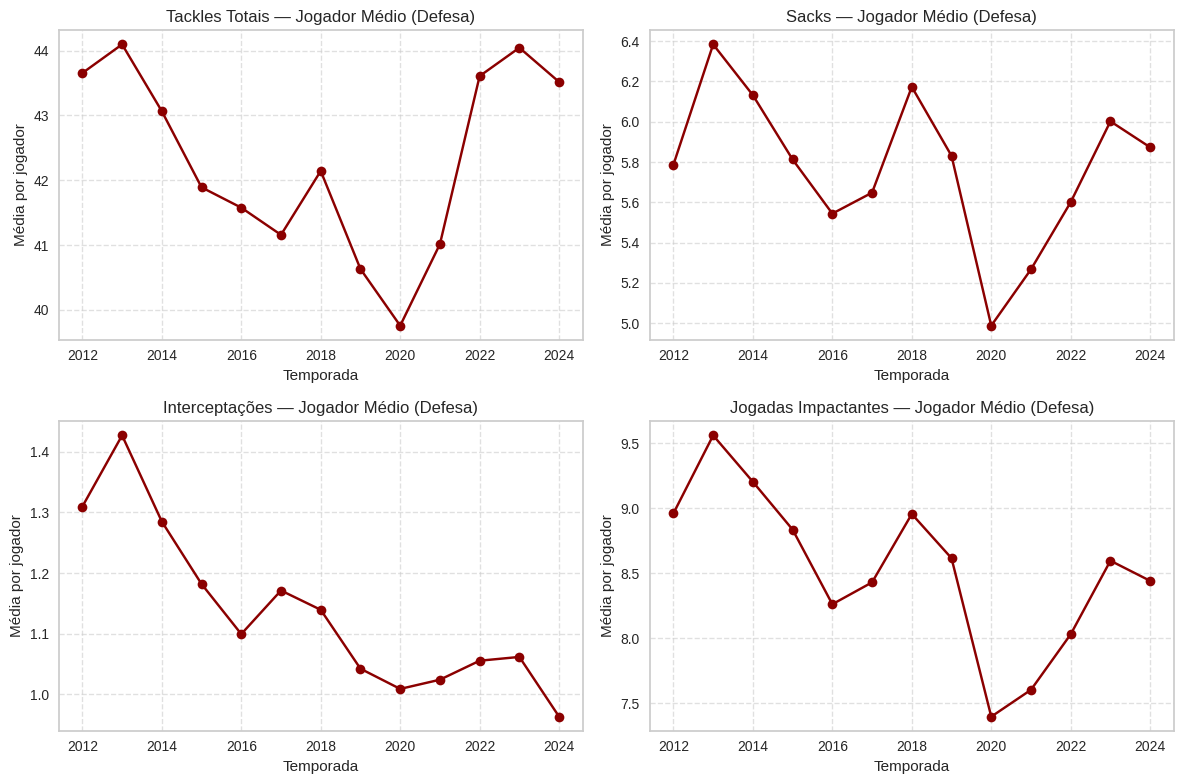

In [552]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

cols = ['tackles_total', 'sack', 'interception', 'impact_plays']
titles = ['Tackles Totais', 'Sacks', 'Interceptações', 'Jogadas Impactantes']

for i, col in enumerate(cols):
    axes[i].plot(media_defesa['season'], media_defesa[col], marker='o', color='darkred')
    axes[i].set_title(f'{titles[i]} — Jogador Médio (Defesa)')
    axes[i].set_xlabel('Temporada')
    axes[i].set_ylabel('Média por jogador')
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


##**Machine Learning**

In [553]:
# Função avaliar o resultado das métricas dos modelos
def avaliar_modelos_clusterizacao(X, modelo_base, k_min=2, k_max=10, metricas=None):
  if metricas is None:
    metricas = [silhouette_score, davies_bouldin_score, calinski_harabasz_score]
    resultados = []
    for k in range(k_min, k_max + 1):
      modelo = clone(modelo_base)
      # Para modelos como KMeans e AgglomerativeClustering que aceitam n_clusters
      if hasattr(modelo, 'n_clusters'):
        modelo.set_params(n_clusters=k)
        labels = modelo.fit_predict(X)
        linha_resultado = {'k': k}
        for metrica in metricas:
          try:
            linha_resultado[metrica.__name__] = metrica(X, labels)
          except:
            linha_resultado[metrica.__name__] = None  # Caso a métrica falhe
        resultados.append(linha_resultado)

    return pd.DataFrame(resultados).set_index('k')

###**Ataque**

####**QB**

In [554]:
# Features importantes para o ataque
features_cluster = [
    'pass_attempts', 'complete_pass', 'passing_yards', 'pass_touchdown',
    'interception', 'passer_rating', 'rush_attempts', 'rushing_yards',
    'rush_touchdown', 'fumble', 'receptions', 'receiving_yards',
    'receiving_touchdown', 'total_yards', 'total_tds',
    'fantasy_points_ppr', 'touches', 'yards_per_touch'
]

In [555]:
# Agrupar por jogador e calcular a média de suas estatísticas ao longo dos anos
qbs_mean = (
    qbs.groupby(['player_id', 'player_name', 'position'])
    [features_cluster]
    .mean()
    .reset_index()
)

# Preencher valores nulos com 0
X_qbs = qbs_mean[features_cluster].fillna(0)

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_qbs)

# Rodar o KMeans (com o K que você definiu, por ex. 6)
kmeans = KMeans(n_clusters=6, random_state=42)
qbs_mean["cluster"] = kmeans.fit_predict(X_scaled)


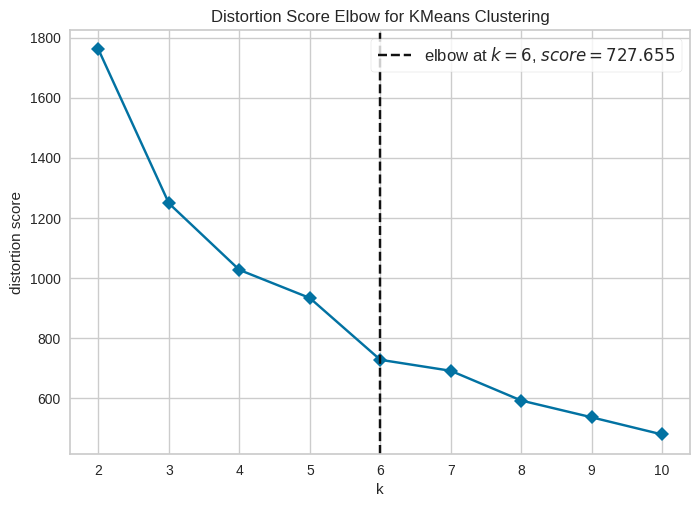

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [556]:
# Plotando o gráfico do Cotovelo pra descobrir o K
kelbow_visualizer(KMeans(), X_scaled, k=10, timings=False)

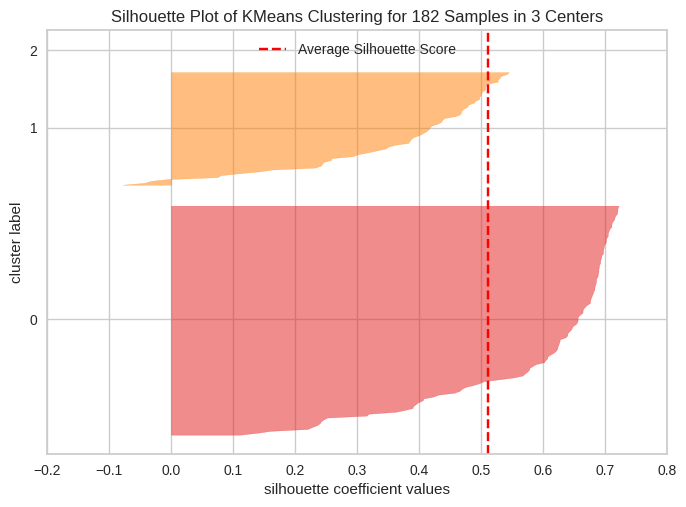

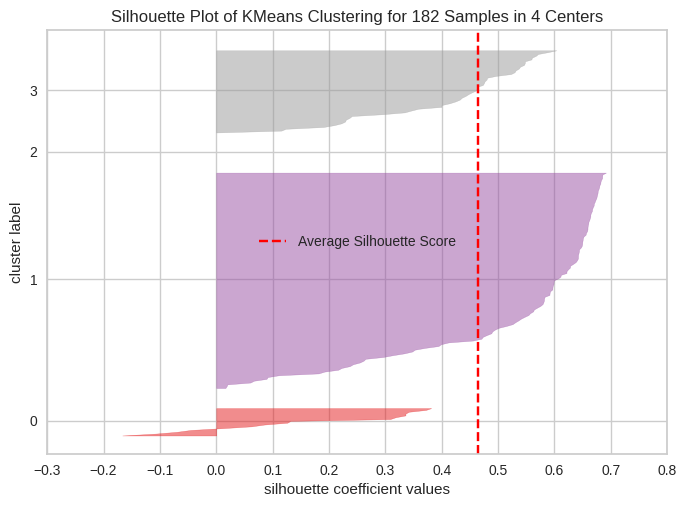

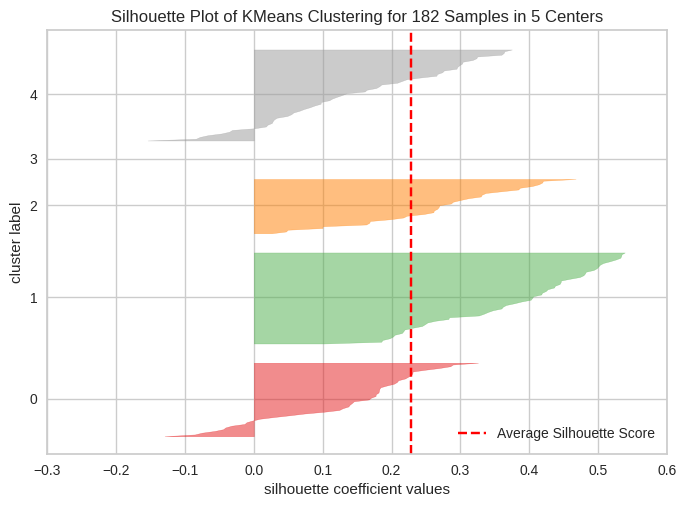

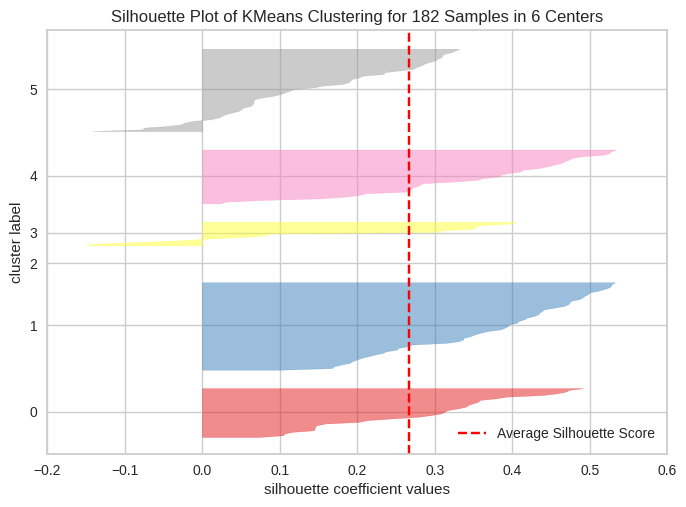

In [557]:
# Gera os gráficos de Silhouette para avaliar a qualidade da clusterização
for cluster in range(3,7): # Mostra o gráfico de 3 até 6 clusters
  silhouette_visualizer(
      KMeans(n_clusters=cluster),  # Algoritmo KMeans configurado para os clusters
      X_scaled                      # Conjunto de dados a ser analisado
)

In [558]:
# Chamando a função para avaliar as métricas do Kmeans
resultados_kmeans = avaliar_modelos_clusterizacao(X_scaled, KMeans(random_state=42))
resultados_kmeans.style.background_gradient()

In [559]:
# Calcula médias das principais features por cluster
cluster = qbs_mean.groupby('cluster')[features_cluster].mean().round(2)

# Mostra o resumo
cluster

pass_attempts  complete_pass  passing_yards  pass_touchdown  \
cluster                                                                
0                42.86          25.75         266.09            1.07   
1               351.23         229.58        2522.32           16.38   
2               400.64         266.72        3017.83           19.47   
3               163.39         102.37        1118.93            5.61   
4                36.29          23.86         288.43            3.00   
5               322.82         208.69        2340.99           14.34   

         interception  passer_rating  rush_attempts  rushing_yards  \
cluster                                                              
0                1.53          59.80           6.31          21.89   
1                7.42          91.65          78.35         438.47   
2                9.29          94.12          20.52          48.99   
3                4.85          74.98          15.61          62.19   
4                1.29         116.52          55.14         300.57   
5                7.98          87.67          37.21         172.02   

         rush_touchdown  fumble  receptions  receiving_yards  \
cluster                                                        
0                  0.16    0.99        0.03             0.23   
1                  4.00    6.44        0.19             0.43   
2                  0.68    5.56        0.06             0.20   
3                  0.64    3.00        0.05             0.04   
4                  3.86    2.29       11.00           108.29   
5                  1.67    5.30        0.13             0.29   

         receiving_touchdown  total_yards  total_tds  fantasy_points_ppr  \
cluster                                                                    
0                       0.01       288.21       1.24               15.86   
1                       0.09      2961.22      20.47              245.38   
2                       0.01      3067.02      20.16              220.97   
3                       0.00      1181.16       6.26               74.90   
4                       1.71       697.29       8.57               98.99   
5                       0.03      2513.29      16.04              183.74   

         touches  yards_per_touch  
cluster                            
0           6.34            38.37  
1          78.54            39.48  
2          20.58           162.92  
3          15.66            97.70  
4          66.14             9.58  
5          37.34            71.12

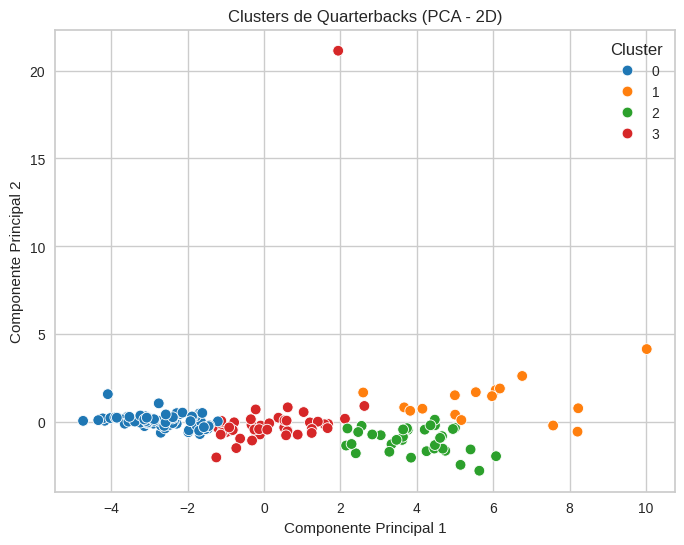

In [560]:
# Rodar o modelo final com k=5
kmeans_qb = KMeans(n_clusters=4, random_state=42)
qbs_mean['cluster'] = kmeans_qb.fit_predict(X_scaled)

# Criar o resumo médio por cluster
df_summary = qbs_mean.groupby('cluster')[[
    'passing_yards', 'rushing_yards', 'pass_touchdown',
    'interception', 'fantasy_points_ppr'
]].mean()


# Reduzindo para 2 dimensões com PCA
pca = PCA(n_components=2)
qbs_pca = pca.fit_transform(X_scaled)

# Adicionando os componentes principais ao dataframe
qbs_mean['pca1'] = qbs_pca[:, 0]
qbs_mean['pca2'] = qbs_pca[:, 1]

# Plotando os clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=qbs_mean, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters de Quarterbacks (PCA - 2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()


In [565]:
qbs_mean['cluster'].value_counts()


cluster
0    86
3    45
2    35
1    16
Name: count, dtype: int64

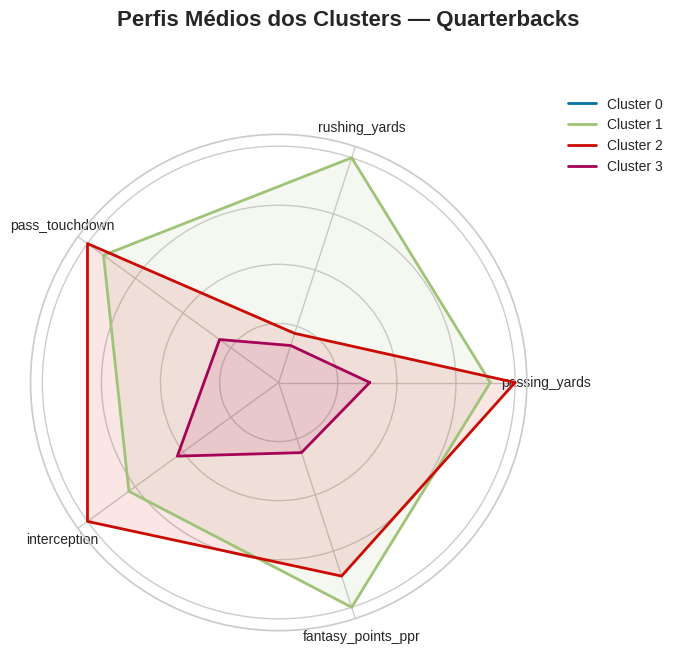

In [566]:
def make_df_summary_from_qbs_mean(qbs_mean, features=None):
    """
    Recebe qbs_mean (cada linha = jogador, com coluna 'cluster') e retorna
    df_summary: índice = cluster, colunas = médias das features escolhidas.
    """
    if 'cluster' not in qbs_mean.columns:
        raise ValueError("qbs_mean precisa ter a coluna 'cluster'.")
    if features is None:
        features = ['passing_yards', 'rushing_yards', 'pass_touchdown',
                    'interception', 'fantasy_points_ppr']
    features = [f for f in features if f in qbs_mean.columns]
    df_summary = qbs_mean.groupby('cluster')[features].mean()
    return df_summary


def plot_radar_clusters(df_or_qbs_mean, posicao='QB', features=None):
    """
    Plota um radar chart comparando o perfil médio dos clusters.
    Aceita:
      - df_summary (index = cluster, colunas = features médias)
      - qbs_mean (coluna 'cluster' presente)
    """
    # Detecta tipo de entrada
    if isinstance(df_or_qbs_mean, pd.DataFrame) and 'cluster' in df_or_qbs_mean.columns:
        df_summary = make_df_summary_from_qbs_mean(df_or_qbs_mean, features)
    else:
        df_summary = df_or_qbs_mean.copy()
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    # Define colunas padrão
    if features is None:
        features = ['passing_yards', 'rushing_yards', 'pass_touchdown',
                    'interception', 'fantasy_points_ppr']
    features = [c for c in features if c in df_summary.columns]

    if len(features) == 0:
        raise ValueError("Nenhuma das colunas esperadas está presente no dataframe.")

    # Normaliza os dados 0–1
    df_norm = (df_summary[features] - df_summary[features].min()) / (df_summary[features].max() - df_summary[features].min())

    # Ângulos para cada variável
    N = len(features)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # fecha o círculo

    # Plot
    plt.figure(figsize=(7, 7))
    plt.suptitle(f'Perfis Médios dos Clusters — {posicao}', fontsize=16, fontweight='bold')

    # Para cada cluster
    for cluster_id, row in df_norm.iterrows():
        values = row.tolist()
        values += values[:1]
        plt.polar(angles, values, label=f'Cluster {cluster_id}', linewidth=2)
        plt.fill(angles, values, alpha=0.1)

    # Eixos
    plt.xticks(angles[:-1], features, fontsize=10)
    plt.yticks(np.linspace(0, 1, 5), [], color='gray', size=8)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

plot_radar_clusters(qbs_mean, posicao='Quarterbacks')


In [567]:
def make_df_summary_from_qbs_mean(qbs_mean, features=None):
    """
    Recebe qbs_mean (cada linha = jogador, com coluna 'cluster') e retorna
    df_summary: índice = cluster, colunas = médias das features escolhidas.
    """
    if 'cluster' not in qbs_mean.columns:
        raise ValueError("qbs_mean precisa ter a coluna 'cluster'.")
    if features is None:
        # features padrão (ajuste se quiser)
        features = ['passing_yards', 'rushing_yards', 'pass_touchdown',
                    'interception', 'fantasy_points_ppr']
    # filtra colunas existentes
    features = [f for f in features if f in qbs_mean.columns]
    df_summary = qbs_mean.groupby('cluster')[features].mean()
    return df_summary

def interpretar_clusters(df_or_qbs_mean, posicao='QB', features=None):
    """
    Interpreta clusters automaticamente.
    Aceita:
      - df_summary: index = cluster, colunas = features médias
      - qbs_mean: dataframe por jogador com coluna 'cluster' (então cria df_summary)
    Retorna string com interpretações.
    """
    # Detectar se foi passado o qbs_mean (com coluna 'cluster') ou um df_summary
    df_summary = None
    if isinstance(df_or_qbs_mean, pd.DataFrame) and 'cluster' in df_or_qbs_mean.columns:
        # Recebeu qbs_mean
        df_summary = make_df_summary_from_qbs_mean(df_or_qbs_mean, features)
    else:
        # Assume que recebeu df_summary (index = cluster)
        df_summary = df_or_qbs_mean.copy()
        # se 'cluster' for coluna, transformar para índice
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    # Features padrão se não passadas
    if features is None:
        features = ['passing_yards', 'rushing_yards', 'pass_touchdown',
                    'interception', 'fantasy_points_ppr']
    # Filtra somente as que existem
    features = [f for f in features if f in df_summary.columns]

    # Proteção contra df_summary vazio
    if df_summary.shape[0] == 0:
        return "df_summary vazio. Verifique a entrada."

    # Calcular percentis globais por feature para comparação
    percentis = {f: {
                    'p25': np.percentile(df_summary[f].dropna(), 25),
                    'p75': np.percentile(df_summary[f].dropna(), 75)
                   } for f in features}

    interpretacoes = []
    clusters_sorted = sorted(df_summary.index.tolist())

    for cluster_id in clusters_sorted:
        row = df_summary.loc[cluster_id]
        texto = f"### Cluster {cluster_id} — {posicao}\n"

        # 1️⃣ Força aérea vs terrestre (exemplo simples)
        if 'passing_yards' in features:
            if row['passing_yards'] > percentis['passing_yards']['p75']:
                texto += "- Perfil **passador dominante**: alto volume de jardas aéreas.\n"
            elif row['passing_yards'] < percentis['passing_yards']['p25']:
                texto += "- Menor produção aérea (pode ser QB móvel ou reserva).\n"

        if 'rushing_yards' in features:
            if row['rushing_yards'] > percentis['rushing_yards']['p75']:
                texto += "- Forte contribuição terrestre — **QB móvel / dual-threat**.\n"
            elif row['rushing_yards'] < percentis['rushing_yards']['p25']:
                texto += "- Pouca produção terrestre → **pocket QB** típico.\n"

        # 2️⃣ Eficiência (TD / INT)
        if 'pass_touchdown' in features and 'interception' in features:
            ratio = row['pass_touchdown'] / (row['interception'] + 1e-9)
            if ratio > 3:
                texto += "- **Excelente relação TD/INT** — baixa propensão a turnovers.\n"
            elif ratio < 1.5:
                texto += "- **Risco maior**: baixa relação TD/INT.\n"
            else:
                texto += "- Relação TD/INT **moderada**.\n"

        # 3️⃣ Fantasy as proxy
        if 'fantasy_points_ppr' in features:
            if row['fantasy_points_ppr'] > percentis['fantasy_points_ppr']['p75']:
                texto += "- Produção em fantasy alta → provável jogador de destaque.\n"
            elif row['fantasy_points_ppr'] < percentis['fantasy_points_ppr']['p25']:
                texto += "- Baixa produção média em fantasy → provável reserva ou especialista.\n"

        # 4️⃣ Estatísticas médias resumidas
        resumo_stats = ", ".join([f"{f}: {row[f]:.1f}" for f in features])
        texto += f"\n📊 Estatísticas médias (por cluster): {resumo_stats}\n\n---\n"
        interpretacoes.append(texto)

    return "\n".join(interpretacoes)

# 1) Criar df_summary automaticamente (a função interna fará isso se passar qbs_mean)
df_summary = make_df_summary_from_qbs_mean(qbs_mean)   # opcional, pois interpretar_clusters aceita qbs_mean direto

# 2) Interpretar clusters a partir do qbs_mean (ou de df_summary)
texto = interpretar_clusters(qbs_mean, posicao='Quarterbacks')
print(texto)


### Cluster 0 — Quarterbacks
- Menor produção aérea (pode ser QB móvel ou reserva).
- Pouca produção terrestre → **pocket QB** típico.
- **Risco maior**: baixa relação TD/INT.
- Baixa produção média em fantasy → provável reserva ou especialista.

📊 Estatísticas médias (por cluster): passing_yards: 324.6, rushing_yards: 22.2, pass_touchdown: 1.4, interception: 1.7, fantasy_points_ppr: 19.3

---

### Cluster 1 — Quarterbacks
- Forte contribuição terrestre — **QB móvel / dual-threat**.
- Relação TD/INT **moderada**.
- Produção em fantasy alta → provável jogador de destaque.

📊 Estatísticas médias (por cluster): passing_yards: 2480.4, rushing_yards: 411.8, pass_touchdown: 16.1, interception: 7.2, fantasy_points_ppr: 237.7

---

### Cluster 2 — Quarterbacks
- Perfil **passador dominante**: alto volume de jardas aéreas.
- Relação TD/INT **moderada**.

📊 Estatísticas médias (por cluster): passing_yards: 2732.6, rushing_yards: 107.4, pass_touchdown: 17.5, interception: 8.7, fantasy_points_ppr:

In [568]:
# Dicionário com nomes para cada cluster (você pode ajustar depois)
cluster_names = {
    0: "Backup/Baixo números",
    1: "QBs Elite de ameaça dupla (área e terrestre)",
    2: "QBS Elite de Pocket",
    3: "QBs medianos"
}

# Loop mostrando exemplos de cada cluster
for c in sorted(qbs_mean['cluster'].unique()):
    cluster_name = cluster_names.get(c, "Cluster Sem Nome")
    print(f"\n🔹 Cluster {c} — {cluster_name}:")
    display(qbs_mean[qbs_mean['cluster'] == c][['player_name']].head(5))




🔹 Cluster 0 — Backup/Baixo números:


player_name
0    Charlie Batch
1  Matt Hasselbeck
5       David Carr
8   Seneca Wallace
9   Byron Leftwich


🔹 Cluster 1 — QBs Elite de ameaça dupla (área e terrestre):


player_name
44         Cam Newton
49   Colin Kaepernick
53     Russell Wilson
101    Deshaun Watson
117     Lamar Jackson


🔹 Cluster 2 — QBS Elite de Pocket:


player_name
2   Peyton Manning
3        Tom Brady
4       Drew Brees
7    Carson Palmer
11     Eli Manning


🔹 Cluster 3 — QBs medianos:


player_name
6   Josh McCown
17   Kyle Orton
20  Matt Cassel
28  Brady Quinn
29   Kevin Kolb